In [2]:
from sklearn import preprocessing,metrics,neighbors
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import GridSearchCV,train_test_split
from scipy.stats import kurtosis, skew
import numpy as np
import pylab as pl
import pandas as pd
import time
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

C:\Users\saivi\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Reading and transforming data

Dataset 1

In [3]:
#Reading data
#remove non-predictive variables
data=pd.read_csv('OnlineNewsPopularity.csv')
print("shape",data.shape)

data.drop(['url', ' timedelta'], axis=1, inplace=True)
data.shape

print("\n type of the variables \n", data.dtypes)

shape (39644, 61)

 type of the variables 
  n_tokens_title                   float64
 n_tokens_content                 float64
 n_unique_tokens                  float64
 n_non_stop_words                 float64
 n_non_stop_unique_tokens         float64
 num_hrefs                        float64
 num_self_hrefs                   float64
 num_imgs                         float64
 num_videos                       float64
 average_token_length             float64
 num_keywords                     float64
 data_channel_is_lifestyle        float64
 data_channel_is_entertainment    float64
 data_channel_is_bus              float64
 data_channel_is_socmed           float64
 data_channel_is_tech             float64
 data_channel_is_world            float64
 kw_min_min                       float64
 kw_max_min                       float64
 kw_avg_min                       float64
 kw_min_max                       float64
 kw_max_max                       float64
 kw_avg_max                     

In [4]:
#identifying categorical and numerical variables
#Shares variables will be the numerical variable
categorical_var=[' data_channel_is_lifestyle',' data_channel_is_entertainment',' data_channel_is_bus',
             ' data_channel_is_socmed',' data_channel_is_tech',' data_channel_is_world',
             ' weekday_is_monday',' weekday_is_tuesday',' weekday_is_wednesday',' weekday_is_thursday',
             ' weekday_is_friday',' weekday_is_saturday',' weekday_is_sunday',' is_weekend']

data_vars=data.columns.values.tolist()
numerical_var=[i for i in data_vars if i not in categorical_var]
numerical_var=numerical_var[0:len(numerical_var)-1]

In [5]:
#normalizing the numerical variables
data_numerical=data[numerical_var]
scaler = preprocessing.StandardScaler()
scaler.fit(data_numerical)  
data_numerical_scaled = pd.DataFrame(scaler.transform(data_numerical))
data_numerical_scaled.columns=data_numerical.columns

data_catergorical = data[categorical_var]
data_catergorical=data_catergorical.astype(object)


data2 = pd.concat([data_numerical_scaled,data_catergorical,data[' shares']], axis=1)
data2.columns=data.columns

mean :  3395.3801836343455
median: 1400.0
var  :  135182573.71299252
skew :  33.9625997792866
kurt :  1832.4413727401281


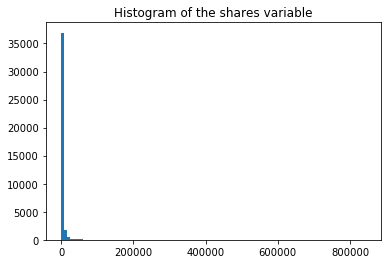

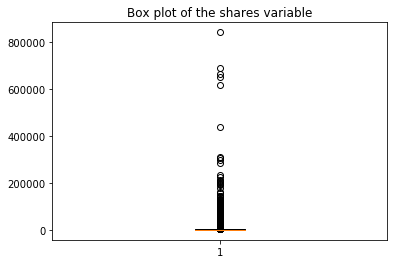

In [6]:
#checking for skewness and kurtosis of the outcome variable (shares)
print("mean : ", np.mean(data[' shares']))
print("median:", np.median(data[' shares']))
print("var  : ", np.var(data[' shares']))
print("skew : ",skew(data[' shares']))
print("kurt : ",kurtosis(data[' shares']))

pl.hist(data[' shares'],bins=100)
pl.title('Histogram of the shares variable')
pl.show()

pl.boxplot(data[' shares'])
pl.title('Box plot of the shares variable')
pl.show()

In [7]:
data3=pd.concat([data_numerical_scaled,data_catergorical,data[' shares']], axis=1)

#Considering if the number of shares above 1400 as high (denoted by 1) and the rest as low (denoted by 0)
#since the shares is skewed, considering a mid point (median) instead of mean
data3[' shares2']=np.where(data3[' shares']>1400, 1, 0)
Y_lo=data3[' shares2']
Y_lo=Y_lo.astype(object)
X_lo=data3.drop([' shares2',' shares'], axis=1)
print("split of number of records classified as high shares (1) vs low shares(0)\n",Y_lo.value_counts())

split of number of records classified as high shares (1) vs low shares(0)
 0    20082
1    19562
Name:  shares2, dtype: int64


In [8]:
#split the data into test and train
X_train_1, X_test_1, Y_train_1, Y_test_1 = train_test_split(X_lo, Y_lo, test_size=0.3, random_state=42)
Y_train_1=list(Y_train_1)
Y_test_1=list(Y_test_1)

Dataset 2

In [9]:
#reading data
bank=pd.read_csv('bankdata.csv', delimiter=';')
print("Total number of records:",len(bank),"\n")
#number of records: 
print("Variable and their data type")
bank.dtypes

Total number of records: 41188 

Variable and their data type


age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

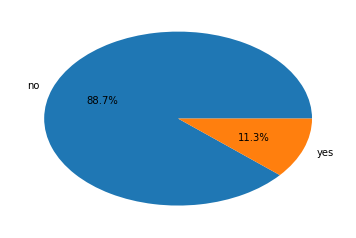

In [10]:
#proportion of clients subscribed for a CD
data=bank.groupby('y')['y'].count()/len(bank)*100
pl.pie(data,autopct='%1.1f%%', labels=[data.index[0],data.index[1]])
pl.show()
# % of clients subsribed for CD is 11.3%

In [11]:
#missing values
data.isnull().sum()
#no missing values 

0

In [12]:
bank["y"]=np.where(bank["y"] == "yes", 1, 0)
bank["y"].value_counts()
bank_y=bank["y"]

In [13]:
#one hot encoding for categorical variables
cat_vars=['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome','y']

data_vars=bank.columns.values.tolist()
numerical_var=[i for i in data_vars if i not in cat_vars]

bank_cat=bank[cat_vars]
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(bank[var], prefix=var)
    data1=bank_cat.join(cat_list)
    bank_cat=data1

cat_vars=['previous','duration','job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome','y_0','y_1','y']
data_vars=bank_cat.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]
bank_cat=bank_cat[to_keep]

#bank_cat.dtypes

In [14]:
#normalizing the numerical variables

bank[numerical_var]
data_numerical=bank[numerical_var]
scaler = preprocessing.StandardScaler()
scaler.fit(data_numerical)  
data_numerical_scaled = pd.DataFrame(scaler.transform(data_numerical))
data_numerical_scaled.columns=data_numerical.columns

bank2 = pd.concat([data_numerical_scaled,bank_cat,bank_y], axis=1)
#bank2.dtypes

In [15]:
bank2_Y=bank2['y']
bank2_X=bank2.drop(['y'], axis=1)
print("split of number of records classified as high shares (1) vs low shares(0)\n",bank2_Y.value_counts())

split of number of records classified as high shares (1) vs low shares(0)
 0    36548
1     4640
Name: y, dtype: int64


In [16]:
#split the data into test and train
X_train_2, X_test_2, Y_train_2, Y_test_2 = train_test_split(bank2_X, bank2_Y, test_size=0.3, random_state=42)
Y_train_2=list(Y_train_2)
Y_test_2=list(Y_test_2)

# NN

In [16]:
#small network function def
def small_network(X_train,Y_train,input_dims,output_dims,parameters,cv):
    def build_classifier(optimizer,first_hidden_units,second_hidden_units,hidden_activation_fun,output_activation_func):
        classifier = Sequential()
        classifier.add(Dense(output_dim = first_hidden_units, init = 'uniform', activation = hidden_activation_fun, input_dim = input_dims))
        # Adding the second hidden layer
        classifier.add(Dense(output_dim = second_hidden_units, init = 'uniform', activation = hidden_activation_fun))
        # Adding the output layer
        classifier.add(Dense(output_dim = output_dims, init = 'uniform', activation = output_activation_func))
        classifier.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
        return classifier

    classifier = KerasClassifier(build_fn = build_classifier)

    grid_search = GridSearchCV(estimator = classifier,
                       param_grid = parameters,
                       scoring = 'accuracy',
                       cv = cv)
    grid_search = grid_search.fit(X_train, Y_train)
    return grid_search

In [17]:
#large netwrork function def
def large_network(X_train,Y_train,input_dims,output_dims,parameters,cv):
    def build_classifier(optimizer,first_hidden_units,second_hidden_units,third_hidden_units,hidden_activation_fun,output_activation_func):
        classifier = Sequential()
        classifier.add(Dense(output_dim = first_hidden_units, init = 'uniform', activation = hidden_activation_fun, input_dim = input_dims))
        classifier.add(Dense(output_dim = second_hidden_units, init = 'uniform', activation = hidden_activation_fun, input_dim = input_dims))
        classifier.add(Dense(output_dim = third_hidden_units, init = 'uniform', activation = hidden_activation_fun))
        
        classifier.add(Dense(output_dim = output_dims, init = 'uniform', activation = output_activation_func))
        classifier.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
        return classifier

    classifier = KerasClassifier(build_fn = build_classifier)

    grid_search = GridSearchCV(estimator = classifier,
                       param_grid = parameters,
                       scoring = 'accuracy',
                       cv = cv)
    grid_search = grid_search.fit(X_train, Y_train)
    return grid_search

In [21]:
#results
def nn_result(grid_search,X_train,Y_train,X_test,Y_test):
    print("")
    print("CV results:")
    means = grid_search.cv_results_['mean_test_score']
    stds = grid_search.cv_results_['std_test_score']
    time = grid_search.cv_results_['mean_fit_time']
    
    for mean, std, params, time in zip(means, stds, grid_search.cv_results_['params'], time):
        #print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
        print(params,"| acv acc:",np.round(mean,4),"| time in seconds:",np.round(time,2))
    print("")
    print("Maximum cv accuracy :",np.round(max(means),4))
    print("Estimator with maximum cv accuracy :",grid_search.cv_results_['params'][np.argmax([means==max(means)])])
    print("")
    print("Train accuracy score of best model:",np.round(accuracy_score(grid_search.predict(X_train),Y_train),4))
    print("Test accuracy score of best model:",np.round(accuracy_score(grid_search.predict(X_test),Y_test),4))
    print("")
    x_label=np.array(range(1,len(grid_search.cv_results_['mean_test_score'])+1))
    pl.plot(grid_search.cv_results_['mean_test_score'])
    pl.xlabel('id')
    pl.ylabel('mean cv accuracy')
    pl.xticks(np.arange(len(grid_search.cv_results_['mean_test_score'])), x_label)
    pl.title('Average Accuracy for cv across different hyperparamters')
    pl.show()
    print("")
    x_label=np.array(range(1,len(grid_search.cv_results_['mean_test_score'])+1))
    pl.plot(grid_search.cv_results_['mean_fit_time'])
    pl.xlabel('id')
    pl.ylabel('mean time in seconds')
    pl.xticks(np.arange(len(grid_search.cv_results_['mean_test_score'])), x_label)
    pl.title('Average Time taken in seconds for cv across different hyperparamters')
    pl.show()
    print("")
    for i in range(0,len(x_label)):
        print("id:",x_label[i],"| hyperparamter:",grid_search.cv_results_['params'][i])
    print("")
    print("")
    print("")
    return None

First dataset

In [19]:
#first dataset
#paramters and calling function
small_parameters_1 = {'batch_size': [32,64],
          'epochs': [10,20,30],
          'optimizer': ['adam','rmsprop'],
             'first_hidden_units':[30],
             'second_hidden_units':[15],
              'hidden_activation_fun':['relu','sigmoid'],
            'output_activation_func':['sigmoid']
                   }

small_parameters_2 = {'batch_size': [32,64],
          'epochs': [10,20,30],
          'optimizer': ['adam','rmsprop'],
             'first_hidden_units':[20],
             'second_hidden_units':[10],
              'hidden_activation_fun':['relu','sigmoid'],
            'output_activation_func':['sigmoid']
                   }

large_parameters_1 = {'batch_size': [32,64],
          'epochs': [10,20,30],
          'optimizer': ['adam','rmsprop'],
             'first_hidden_units':[30],
             'second_hidden_units':[15],
              'third_hidden_units':[8],
             'hidden_activation_fun':['relu','sigmoid'],
            'output_activation_func':['sigmoid']
                   }

large_parameters_2 = {'batch_size': [32,64],
          'epochs': [10,20,30],
          'optimizer': ['adam','rmsprop'],
             'first_hidden_units':[20],
             'second_hidden_units':[10],
              'third_hidden_units':[5],
             'hidden_activation_fun':['relu','sigmoid'],
            'output_activation_func':['sigmoid']
                   }

small_network_large_hidden_1=small_network(X_train_1,Y_train_1,X_train_1.shape[1],1,small_parameters_1,cv=5)
print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")
small_network_small_hidden_1=small_network(X_train_1,Y_train_1,X_train_1.shape[1],1,small_parameters_2,cv=5)
print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")
large_network_large_hidden_1=large_network(X_train_1,Y_train_1,X_train_1.shape[1],1,large_parameters_1,cv=5)
print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")
large_network_small_hidden_1=large_network(X_train_1,Y_train_1,X_train_1.shape[1],1,large_parameters_2,cv=5)


C:\Users\saivi\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=58, units=30, kernel_initializer="uniform")`
  """
C:\Users\saivi\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=15, kernel_initializer="uniform")`
  import sys
C:\Users\saivi\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", units=1, kernel_initializer="uniform")`
  if __name__ == '__main__':


Epoch 1/10
22200/22200 [==============================] - 2s 96us/step - loss: 0.6425 - acc: 0.6335
Epoch 2/10
22200/22200 [==============================] - 2s 90us/step - loss: 0.6225 - acc: 0.6554
Epoch 3/10
22200/22200 [==============================] - 2s 69us/step - loss: 0.6176 - acc: 0.6623
Epoch 4/10
22200/22200 [==============================] - 2s 89us/step - loss: 0.6137 - acc: 0.6655
Epoch 5/10
22200/22200 [==============================] - 1s 60us/step - loss: 0.6110 - acc: 0.6678
Epoch 6/10
22200/22200 [==============================] - 1s 56us/step - loss: 0.6080 - acc: 0.6701
Epoch 7/10
22200/22200 [==============================] - 1s 54us/step - loss: 0.6057 - acc: 0.6709
Epoch 8/10
22200/22200 [==============================] - 1s 51us/step - loss: 0.6040 - acc: 0.6749
Epoch 9/10
22200/22200 [==============================] - 1s 54us/step - loss: 0.6023 - acc: 0.6749
Epoch 10/10
22200/22200 [==============================] - 1s 53us/step - loss: 0.6004 - acc: 0.6759

C:\Users\saivi\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", input_dim=58, units=30, kernel_initializer="uniform")`
  """
C:\Users\saivi\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", units=15, kernel_initializer="uniform")`
  import sys


Epoch 1/10
22200/22200 [==============================] - 2s 70us/step - loss: 0.6658 - acc: 0.5955
Epoch 2/10
22200/22200 [==============================] - 1s 52us/step - loss: 0.6333 - acc: 0.6488
Epoch 3/10
22200/22200 [==============================] - 1s 53us/step - loss: 0.6301 - acc: 0.6508
Epoch 4/10
22200/22200 [==============================] - 1s 54us/step - loss: 0.6287 - acc: 0.6536
Epoch 5/10
22200/22200 [==============================] - 1s 53us/step - loss: 0.6282 - acc: 0.6535
Epoch 6/10
22200/22200 [==============================] - 1s 53us/step - loss: 0.6276 - acc: 0.6537
Epoch 7/10
22200/22200 [==============================] - 1s 53us/step - loss: 0.6270 - acc: 0.6549
Epoch 8/10
22200/22200 [==============================] - 1s 54us/step - loss: 0.6268 - acc: 0.6547
Epoch 9/10
22200/22200 [==============================] - 1s 53us/step - loss: 0.6262 - acc: 0.6551
Epoch 10/10
22200/22200 [==============================] - 1s 53us/step - loss: 0.6262 - acc: 0.6544

22200/22200 [==============================] - 1s 58us/step - loss: 0.6154 - acc: 0.6616
Epoch 4/20
22200/22200 [==============================] - 1s 58us/step - loss: 0.6114 - acc: 0.6656
Epoch 5/20
22200/22200 [==============================] - 1s 58us/step - loss: 0.6095 - acc: 0.6665
Epoch 6/20
22200/22200 [==============================] - 1s 58us/step - loss: 0.6069 - acc: 0.6698
Epoch 7/20
22200/22200 [==============================] - 1s 58us/step - loss: 0.6043 - acc: 0.6719
Epoch 8/20
22200/22200 [==============================] - 1s 57us/step - loss: 0.6033 - acc: 0.6723
Epoch 9/20
22200/22200 [==============================] - 1s 58us/step - loss: 0.6006 - acc: 0.6750
Epoch 10/20
22200/22200 [==============================] - 1s 58us/step - loss: 0.6002 - acc: 0.6750
Epoch 11/20
22200/22200 [==============================] - 1s 58us/step - loss: 0.5991 - acc: 0.6755
Epoch 12/20
22200/22200 [==============================] - 1s 57us/step - loss: 0.5974 - acc: 0.6766
Epoch 13

22200/22200 [==============================] - 1s 60us/step - loss: 0.6285 - acc: 0.6527
Epoch 6/20
22200/22200 [==============================] - 1s 60us/step - loss: 0.6277 - acc: 0.6528
Epoch 7/20
22200/22200 [==============================] - 1s 61us/step - loss: 0.6271 - acc: 0.6562
Epoch 8/20
22200/22200 [==============================] - 1s 61us/step - loss: 0.6267 - acc: 0.6541
Epoch 9/20
22200/22200 [==============================] - 1s 60us/step - loss: 0.6264 - acc: 0.6531
Epoch 10/20
22200/22200 [==============================] - 1s 61us/step - loss: 0.6263 - acc: 0.6558
Epoch 11/20
22200/22200 [==============================] - 1s 60us/step - loss: 0.6256 - acc: 0.6559
Epoch 12/20
22200/22200 [==============================] - 1s 60us/step - loss: 0.6249 - acc: 0.6538
Epoch 13/20
22200/22200 [==============================] - 1s 61us/step - loss: 0.6245 - acc: 0.6550
Epoch 14/20
22200/22200 [==============================] - 1s 60us/step - loss: 0.6242 - acc: 0.6555
Epoch 

22200/22200 [==============================] - 1s 64us/step - loss: 0.6266 - acc: 0.6553
Epoch 8/20
22200/22200 [==============================] - 2s 75us/step - loss: 0.6263 - acc: 0.6571
Epoch 9/20
22200/22200 [==============================] - 1s 64us/step - loss: 0.6256 - acc: 0.6577
Epoch 10/20
22200/22200 [==============================] - 1s 62us/step - loss: 0.6249 - acc: 0.6578
Epoch 11/20
22200/22200 [==============================] - 1s 62us/step - loss: 0.6245 - acc: 0.6555
Epoch 12/20
22200/22200 [==============================] - 1s 63us/step - loss: 0.6236 - acc: 0.6555
Epoch 13/20
22200/22200 [==============================] - 1s 63us/step - loss: 0.6234 - acc: 0.6550
Epoch 14/20
22200/22200 [==============================] - 1s 63us/step - loss: 0.6223 - acc: 0.6582
Epoch 15/20
22200/22200 [==============================] - 1s 63us/step - loss: 0.6213 - acc: 0.6580
Epoch 16/20
22200/22200 [==============================] - 1s 62us/step - loss: 0.6209 - acc: 0.6575
Epoc

22200/22200 [==============================] - 1s 67us/step - loss: 0.5838 - acc: 0.6894
Epoch 30/30
22200/22200 [==============================] - 1s 65us/step - loss: 0.5829 - acc: 0.6891
Epoch 1/30
22200/22200 [==============================] - 2s 102us/step - loss: 0.6461 - acc: 0.6349
Epoch 2/30
22200/22200 [==============================] - 1s 55us/step - loss: 0.6253 - acc: 0.6532
Epoch 3/30
22200/22200 [==============================] - 1s 55us/step - loss: 0.6206 - acc: 0.6586
Epoch 4/30
22200/22200 [==============================] - 1s 55us/step - loss: 0.6170 - acc: 0.6629
Epoch 5/30
22200/22200 [==============================] - 1s 54us/step - loss: 0.6147 - acc: 0.6664
Epoch 6/30
22200/22200 [==============================] - 1s 55us/step - loss: 0.6128 - acc: 0.6697
Epoch 7/30
22200/22200 [==============================] - 1s 55us/step - loss: 0.6110 - acc: 0.6674
Epoch 8/30
22200/22200 [==============================] - 1s 55us/step - loss: 0.6089 - acc: 0.6693
Epoch 9/3

22200/22200 [==============================] - 1s 56us/step - loss: 0.6258 - acc: 0.6544
Epoch 12/30
22200/22200 [==============================] - 1s 53us/step - loss: 0.6253 - acc: 0.6562
Epoch 13/30
22200/22200 [==============================] - 1s 53us/step - loss: 0.6250 - acc: 0.6562
Epoch 14/30
22200/22200 [==============================] - 1s 55us/step - loss: 0.6245 - acc: 0.6572
Epoch 15/30
22200/22200 [==============================] - 1s 54us/step - loss: 0.6237 - acc: 0.6580
Epoch 16/30
22200/22200 [==============================] - 1s 56us/step - loss: 0.6231 - acc: 0.6572
Epoch 17/30
22200/22200 [==============================] - 1s 58us/step - loss: 0.6229 - acc: 0.6575
Epoch 18/30
22200/22200 [==============================] - 1s 58us/step - loss: 0.6222 - acc: 0.6571
Epoch 19/30
22200/22200 [==============================] - 1s 53us/step - loss: 0.6213 - acc: 0.6594
Epoch 20/30
22200/22200 [==============================] - 1s 57us/step - loss: 0.6206 - acc: 0.6598
Ep

22200/22200 [==============================] - 1s 53us/step - loss: 0.6203 - acc: 0.6589
Epoch 24/30
22200/22200 [==============================] - 1s 53us/step - loss: 0.6195 - acc: 0.6606
Epoch 25/30
22200/22200 [==============================] - 1s 53us/step - loss: 0.6189 - acc: 0.6617
Epoch 26/30
22200/22200 [==============================] - 1s 53us/step - loss: 0.6179 - acc: 0.6620
Epoch 27/30
22200/22200 [==============================] - 1s 53us/step - loss: 0.6174 - acc: 0.6626
Epoch 28/30
22200/22200 [==============================] - 1s 53us/step - loss: 0.6167 - acc: 0.6613
Epoch 29/30
22200/22200 [==============================] - 1s 54us/step - loss: 0.6162 - acc: 0.6615
Epoch 30/30
22200/22200 [==============================] - 1s 52us/step - loss: 0.6154 - acc: 0.6623
Epoch 1/30
22200/22200 [==============================] - 2s 109us/step - loss: 0.6716 - acc: 0.5862
Epoch 2/30
22200/22200 [==============================] - 1s 53us/step - loss: 0.6358 - acc: 0.6447
Epo

22200/22200 [==============================] - 1s 35us/step - loss: 0.6103 - acc: 0.6659
Epoch 6/10
22200/22200 [==============================] - 1s 36us/step - loss: 0.6088 - acc: 0.6686
Epoch 7/10
22200/22200 [==============================] - 1s 37us/step - loss: 0.6059 - acc: 0.6708
Epoch 8/10
22200/22200 [==============================] - 1s 38us/step - loss: 0.6038 - acc: 0.6733
Epoch 9/10
22200/22200 [==============================] - 1s 38us/step - loss: 0.6023 - acc: 0.6731
Epoch 10/10
22200/22200 [==============================] - 1s 36us/step - loss: 0.6008 - acc: 0.6745
Epoch 1/10
22200/22200 [==============================] - 3s 133us/step - loss: 0.6487 - acc: 0.6268
Epoch 2/10
22200/22200 [==============================] - 1s 46us/step - loss: 0.6220 - acc: 0.6548
Epoch 3/10
22200/22200 [==============================] - 1s 48us/step - loss: 0.6169 - acc: 0.6595
Epoch 4/10
22200/22200 [==============================] - 1s 45us/step - loss: 0.6140 - acc: 0.6628
Epoch 5/1

22200/22200 [==============================] - 1s 47us/step - loss: 0.6271 - acc: 0.6554
Epoch 8/10
22200/22200 [==============================] - 1s 49us/step - loss: 0.6266 - acc: 0.6535
Epoch 9/10
22200/22200 [==============================] - 1s 47us/step - loss: 0.6264 - acc: 0.6546
Epoch 10/10
22200/22200 [==============================] - 1s 47us/step - loss: 0.6262 - acc: 0.6553
Epoch 1/20
22200/22200 [==============================] - 3s 142us/step - loss: 0.6508 - acc: 0.6286
Epoch 2/20
22200/22200 [==============================] - 1s 47us/step - loss: 0.6245 - acc: 0.6540
Epoch 3/20
22200/22200 [==============================] - 1s 48us/step - loss: 0.6200 - acc: 0.6564
Epoch 4/20
22200/22200 [==============================] - 1s 57us/step - loss: 0.6169 - acc: 0.6597
Epoch 5/20
22200/22200 [==============================] - 2s 74us/step - loss: 0.6143 - acc: 0.6633
Epoch 6/20
22200/22200 [==============================] - 1s 59us/step - loss: 0.6126 - acc: 0.6630
Epoch 7/2

22200/22200 [==============================] - 1s 61us/step - loss: 0.5963 - acc: 0.6809
Epoch 20/20
22200/22200 [==============================] - 1s 60us/step - loss: 0.5961 - acc: 0.6789
Epoch 1/20
22200/22200 [==============================] - 4s 184us/step - loss: 0.6517 - acc: 0.6267
Epoch 2/20
22200/22200 [==============================] - 1s 62us/step - loss: 0.6249 - acc: 0.6555
Epoch 3/20
22200/22200 [==============================] - 1s 61us/step - loss: 0.6203 - acc: 0.6593
Epoch 4/20
22200/22200 [==============================] - 1s 61us/step - loss: 0.6173 - acc: 0.6619
Epoch 5/20
22200/22200 [==============================] - 1s 61us/step - loss: 0.6145 - acc: 0.6649
Epoch 6/20
22200/22200 [==============================] - 1s 60us/step - loss: 0.6124 - acc: 0.6647
Epoch 7/20
22200/22200 [==============================] - 1s 59us/step - loss: 0.6107 - acc: 0.6669
Epoch 8/20
22200/22200 [==============================] - 1s 59us/step - loss: 0.6091 - acc: 0.6673
Epoch 9/2

22200/22200 [==============================] - 4s 183us/step - loss: 0.6838 - acc: 0.5698
Epoch 2/20
22200/22200 [==============================] - 1s 62us/step - loss: 0.6483 - acc: 0.6336
Epoch 3/20
22200/22200 [==============================] - 2s 73us/step - loss: 0.6369 - acc: 0.6432
Epoch 4/20
22200/22200 [==============================] - 1s 59us/step - loss: 0.6329 - acc: 0.6473
Epoch 5/20
22200/22200 [==============================] - 1s 56us/step - loss: 0.6308 - acc: 0.6508
Epoch 6/20
22200/22200 [==============================] - 1s 57us/step - loss: 0.6298 - acc: 0.6518
Epoch 7/20
22200/22200 [==============================] - 1s 57us/step - loss: 0.6290 - acc: 0.6530
Epoch 8/20
22200/22200 [==============================] - 1s 57us/step - loss: 0.6284 - acc: 0.6519
Epoch 9/20
22200/22200 [==============================] - 1s 56us/step - loss: 0.6278 - acc: 0.6536
Epoch 10/20
22200/22200 [==============================] - 1s 57us/step - loss: 0.6271 - acc: 0.6534
Epoch 11/

22200/22200 [==============================] - 1s 53us/step - loss: 0.5891 - acc: 0.6858
Epoch 24/30
22200/22200 [==============================] - 1s 53us/step - loss: 0.5877 - acc: 0.6850
Epoch 25/30
22200/22200 [==============================] - 1s 53us/step - loss: 0.5867 - acc: 0.6866
Epoch 26/30
22200/22200 [==============================] - 1s 53us/step - loss: 0.5857 - acc: 0.6874
Epoch 27/30
22200/22200 [==============================] - 1s 53us/step - loss: 0.5854 - acc: 0.6885
Epoch 28/30
22200/22200 [==============================] - 1s 53us/step - loss: 0.5831 - acc: 0.6880
Epoch 29/30
22200/22200 [==============================] - 1s 53us/step - loss: 0.5835 - acc: 0.6893: 0s - loss: 0.57
Epoch 30/30
22200/22200 [==============================] - 1s 53us/step - loss: 0.5824 - acc: 0.6894
Epoch 1/30
22200/22200 [==============================] - 4s 174us/step - loss: 0.6453 - acc: 0.6302
Epoch 2/30
22200/22200 [==============================] - 1s 53us/step - loss: 0.6210 

22200/22200 [==============================] - 1s 54us/step - loss: 0.6128 - acc: 0.6650
Epoch 6/30
22200/22200 [==============================] - 1s 54us/step - loss: 0.6102 - acc: 0.6663
Epoch 7/30
22200/22200 [==============================] - 1s 54us/step - loss: 0.6084 - acc: 0.6704
Epoch 8/30
22200/22200 [==============================] - 1s 53us/step - loss: 0.6061 - acc: 0.6695
Epoch 9/30
22200/22200 [==============================] - 1s 54us/step - loss: 0.6054 - acc: 0.6734
Epoch 10/30
22200/22200 [==============================] - 1s 54us/step - loss: 0.6035 - acc: 0.6740
Epoch 11/30
22200/22200 [==============================] - 1s 53us/step - loss: 0.6024 - acc: 0.6744
Epoch 12/30
22200/22200 [==============================] - 1s 54us/step - loss: 0.6006 - acc: 0.6768
Epoch 13/30
22200/22200 [==============================] - 1s 53us/step - loss: 0.6001 - acc: 0.6782
Epoch 14/30
22200/22200 [==============================] - 1s 54us/step - loss: 0.5989 - acc: 0.6791
Epoch 

22200/22200 [==============================] - 1s 67us/step - loss: 0.6197 - acc: 0.6616
Epoch 18/30
22200/22200 [==============================] - 1s 67us/step - loss: 0.6188 - acc: 0.6603
Epoch 19/30
22200/22200 [==============================] - 2s 68us/step - loss: 0.6184 - acc: 0.6607
Epoch 20/30
22200/22200 [==============================] - 2s 70us/step - loss: 0.6180 - acc: 0.6613
Epoch 21/30
22200/22200 [==============================] - 2s 68us/step - loss: 0.6172 - acc: 0.6611
Epoch 22/30
22200/22200 [==============================] - 1s 67us/step - loss: 0.6169 - acc: 0.6614
Epoch 23/30
22200/22200 [==============================] - 2s 68us/step - loss: 0.6164 - acc: 0.6651
Epoch 24/30
22200/22200 [==============================] - 1s 68us/step - loss: 0.6155 - acc: 0.6636
Epoch 25/30
22200/22200 [==============================] - 1s 67us/step - loss: 0.6152 - acc: 0.6642
Epoch 26/30
22200/22200 [==============================] - 1s 67us/step - loss: 0.6144 - acc: 0.6655
Ep

22200/22200 [==============================] - 2s 69us/step - loss: 0.6183 - acc: 0.6607
Epoch 30/30
22200/22200 [==============================] - 2s 68us/step - loss: 0.6180 - acc: 0.6611
Epoch 1/30
22200/22200 [==============================] - 5s 231us/step - loss: 0.6813 - acc: 0.5709
Epoch 2/30
22200/22200 [==============================] - 2s 69us/step - loss: 0.6408 - acc: 0.6417
Epoch 3/30
22200/22200 [==============================] - ETA: 0s - loss: 0.6329 - acc: 0.646 - 2s 71us/step - loss: 0.6325 - acc: 0.6472
Epoch 4/30
22200/22200 [==============================] - 2s 69us/step - loss: 0.6297 - acc: 0.6498
Epoch 5/30
22200/22200 [==============================] - 2s 68us/step - loss: 0.6283 - acc: 0.6538
Epoch 6/30
22200/22200 [==============================] - 2s 68us/step - loss: 0.6273 - acc: 0.6545
Epoch 7/30
22200/22200 [==============================] - 2s 68us/step - loss: 0.6269 - acc: 0.6558
Epoch 8/30
22200/22200 [==============================] - 2s 73us/step 

C:\Users\saivi\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=58, units=20, kernel_initializer="uniform")`
  """
C:\Users\saivi\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=10, kernel_initializer="uniform")`
  import sys


Epoch 1/10
22200/22200 [==============================] - 5s 242us/step - loss: 0.6467 - acc: 0.6328
Epoch 2/10
22200/22200 [==============================] - 2s 96us/step - loss: 0.6250 - acc: 0.6532
Epoch 3/10
22200/22200 [==============================] - 2s 109us/step - loss: 0.6202 - acc: 0.6576
Epoch 4/10
22200/22200 [==============================] - 2s 96us/step - loss: 0.6171 - acc: 0.6595
Epoch 5/10
22200/22200 [==============================] - 2s 96us/step - loss: 0.6149 - acc: 0.6637
Epoch 6/10
22200/22200 [==============================] - 2s 96us/step - loss: 0.6130 - acc: 0.6644
Epoch 7/10
22200/22200 [==============================] - 2s 96us/step - loss: 0.6110 - acc: 0.6667
Epoch 8/10
22200/22200 [==============================] - 2s 96us/step - loss: 0.6095 - acc: 0.6669
Epoch 9/10
22200/22200 [==============================] - 2s 96us/step - loss: 0.6083 - acc: 0.6674
Epoch 10/10
22200/22200 [==============================] - 2s 96us/step - loss: 0.6073 - acc: 0.66

C:\Users\saivi\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", input_dim=58, units=20, kernel_initializer="uniform")`
  """
C:\Users\saivi\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", units=10, kernel_initializer="uniform")`
  import sys


Epoch 1/10
22200/22200 [==============================] - 6s 277us/step - loss: 0.6733 - acc: 0.5890
Epoch 2/10
22200/22200 [==============================] - 2s 111us/step - loss: 0.6354 - acc: 0.6456
Epoch 3/10
22200/22200 [==============================] - 2s 100us/step - loss: 0.6311 - acc: 0.6517
Epoch 4/10
22200/22200 [==============================] - 2s 100us/step - loss: 0.6295 - acc: 0.6535
Epoch 5/10
22200/22200 [==============================] - 2s 103us/step - loss: 0.6285 - acc: 0.6551
Epoch 6/10
22200/22200 [==============================] - 2s 100us/step - loss: 0.6279 - acc: 0.6539
Epoch 7/10
22200/22200 [==============================] - 2s 100us/step - loss: 0.6274 - acc: 0.6553
Epoch 8/10
22200/22200 [==============================] - 2s 100us/step - loss: 0.6267 - acc: 0.6543
Epoch 9/10
22200/22200 [==============================] - 2s 100us/step - loss: 0.6264 - acc: 0.6557
Epoch 10/10
22200/22200 [==============================] - 2s 100us/step - loss: 0.6259 - a

22200/22200 [==============================] - 7s 310us/step - loss: 0.6424 - acc: 0.6380
Epoch 2/20
22200/22200 [==============================] - 3s 131us/step - loss: 0.6216 - acc: 0.6568
Epoch 3/20
22200/22200 [==============================] - 3s 141us/step - loss: 0.6161 - acc: 0.6608
Epoch 4/20
22200/22200 [==============================] - 3s 152us/step - loss: 0.6139 - acc: 0.6636
Epoch 5/20
22200/22200 [==============================] - 4s 170us/step - loss: 0.6108 - acc: 0.6650
Epoch 6/20
22200/22200 [==============================] - 3s 153us/step - loss: 0.6090 - acc: 0.6649
Epoch 7/20
22200/22200 [==============================] - 4s 178us/step - loss: 0.6079 - acc: 0.6676
Epoch 8/20
22200/22200 [==============================] - 3s 131us/step - loss: 0.6064 - acc: 0.6692
Epoch 9/20
22200/22200 [==============================] - 3s 120us/step - loss: 0.6052 - acc: 0.6709
Epoch 10/20
22200/22200 [==============================] - 3s 125us/step - loss: 0.6045 - acc: 0.6722


22200/22200 [==============================] - 7s 305us/step - loss: 0.6720 - acc: 0.5864
Epoch 2/20
22200/22200 [==============================] - 3s 114us/step - loss: 0.6357 - acc: 0.6464
Epoch 3/20
22200/22200 [==============================] - 3s 114us/step - loss: 0.6312 - acc: 0.6515
Epoch 4/20
22200/22200 [==============================] - 3s 115us/step - loss: 0.6296 - acc: 0.6528
Epoch 5/20
22200/22200 [==============================] - 3s 114us/step - loss: 0.6285 - acc: 0.6522
Epoch 6/20
22200/22200 [==============================] - 3s 115us/step - loss: 0.6280 - acc: 0.6536
Epoch 7/20
22200/22200 [==============================] - 3s 114us/step - loss: 0.6276 - acc: 0.6519
Epoch 8/20
22200/22200 [==============================] - 3s 115us/step - loss: 0.6269 - acc: 0.6539
Epoch 9/20
22200/22200 [==============================] - 3s 116us/step - loss: 0.6268 - acc: 0.6545
Epoch 10/20
22200/22200 [==============================] - 3s 114us/step - loss: 0.6263 - acc: 0.6562


22200/22200 [==============================] - 7s 313us/step - loss: 0.6778 - acc: 0.5864
Epoch 2/20
22200/22200 [==============================] - 3s 116us/step - loss: 0.6380 - acc: 0.6445
Epoch 3/20
22200/22200 [==============================] - 3s 117us/step - loss: 0.6313 - acc: 0.6482
Epoch 4/20
22200/22200 [==============================] - 3s 118us/step - loss: 0.6290 - acc: 0.6537
Epoch 5/20
22200/22200 [==============================] - 3s 117us/step - loss: 0.6280 - acc: 0.6544
Epoch 6/20
22200/22200 [==============================] - 3s 116us/step - loss: 0.6274 - acc: 0.6554
Epoch 7/20
22200/22200 [==============================] - 3s 116us/step - loss: 0.6268 - acc: 0.6544
Epoch 8/20
22200/22200 [==============================] - 3s 117us/step - loss: 0.6264 - acc: 0.6554
Epoch 9/20
22200/22200 [==============================] - 3s 118us/step - loss: 0.6261 - acc: 0.6551
Epoch 10/20
22200/22200 [==============================] - 3s 117us/step - loss: 0.6254 - acc: 0.6553


22200/22200 [==============================] - 3s 120us/step - loss: 0.5951 - acc: 0.6779
Epoch 22/30
22200/22200 [==============================] - 3s 120us/step - loss: 0.5943 - acc: 0.6808
Epoch 23/30
22200/22200 [==============================] - 3s 121us/step - loss: 0.5938 - acc: 0.6797 0s - loss: 0.5936 - acc: 0.6
Epoch 24/30
22200/22200 [==============================] - 3s 121us/step - loss: 0.5937 - acc: 0.6758
Epoch 25/30
22200/22200 [==============================] - 3s 121us/step - loss: 0.5928 - acc: 0.6812
Epoch 26/30
22200/22200 [==============================] - 3s 121us/step - loss: 0.5920 - acc: 0.6818
Epoch 27/30
22200/22200 [==============================] - 3s 120us/step - loss: 0.5917 - acc: 0.6826
Epoch 28/30
22200/22200 [==============================] - 3s 121us/step - loss: 0.5919 - acc: 0.6799
Epoch 29/30
22200/22200 [==============================] - 3s 120us/step - loss: 0.5908 - acc: 0.6803
Epoch 30/30
22200/22200 [==============================] - 3s 120

22200/22200 [==============================] - 3s 123us/step - loss: 0.6093 - acc: 0.6672
Epoch 12/30
22200/22200 [==============================] - 3s 124us/step - loss: 0.6086 - acc: 0.6683
Epoch 13/30
22200/22200 [==============================] - 3s 123us/step - loss: 0.6073 - acc: 0.6688
Epoch 14/30
22200/22200 [==============================] - 3s 123us/step - loss: 0.6066 - acc: 0.6693
Epoch 15/30
22200/22200 [==============================] - 3s 123us/step - loss: 0.6061 - acc: 0.6712
Epoch 16/30
22200/22200 [==============================] - 3s 123us/step - loss: 0.6050 - acc: 0.6738
Epoch 17/30
22200/22200 [==============================] - 3s 124us/step - loss: 0.6040 - acc: 0.6715
Epoch 18/30
22200/22200 [==============================] - 3s 123us/step - loss: 0.6030 - acc: 0.6717
Epoch 19/30
22200/22200 [==============================] - 3s 124us/step - loss: 0.6027 - acc: 0.6727
Epoch 20/30
22200/22200 [==============================] - 3s 124us/step - loss: 0.6017 - acc:

22200/22200 [==============================] - 3s 118us/step - loss: 0.6201 - acc: 0.6598
Epoch 22/30
22200/22200 [==============================] - 2s 111us/step - loss: 0.6197 - acc: 0.6600
Epoch 23/30
22200/22200 [==============================] - 2s 109us/step - loss: 0.6190 - acc: 0.6617
Epoch 24/30
22200/22200 [==============================] - 3s 115us/step - loss: 0.6189 - acc: 0.6609
Epoch 25/30
22200/22200 [==============================] - 3s 122us/step - loss: 0.6181 - acc: 0.6602
Epoch 26/30
22200/22200 [==============================] - 3s 117us/step - loss: 0.6176 - acc: 0.6626
Epoch 27/30
22200/22200 [==============================] - 2s 111us/step - loss: 0.6171 - acc: 0.6614
Epoch 28/30
22200/22200 [==============================] - 2s 112us/step - loss: 0.6167 - acc: 0.6601 0s - loss: 0
Epoch 29/30
22200/22200 [==============================] - 2s 111us/step - loss: 0.6160 - acc: 0.6624
Epoch 30/30
22200/22200 [==============================] - 2s 111us/step - loss: 

22200/22200 [==============================] - 13s 573us/step - loss: 0.6803 - acc: 0.5777
Epoch 2/30
22200/22200 [==============================] - 3s 113us/step - loss: 0.6392 - acc: 0.6438
Epoch 3/30
22200/22200 [==============================] - 2s 105us/step - loss: 0.6300 - acc: 0.6522
Epoch 4/30
22200/22200 [==============================] - 3s 117us/step - loss: 0.6274 - acc: 0.6548
Epoch 5/30
22200/22200 [==============================] - 2s 113us/step - loss: 0.6262 - acc: 0.6562
Epoch 6/30
22200/22200 [==============================] - 3s 116us/step - loss: 0.6254 - acc: 0.6573
Epoch 7/30
22200/22200 [==============================] - 3s 114us/step - loss: 0.6246 - acc: 0.6573
Epoch 8/30
22200/22200 [==============================] - 2s 112us/step - loss: 0.6240 - acc: 0.6579
Epoch 9/30
22200/22200 [==============================] - 2s 113us/step - loss: 0.6234 - acc: 0.6582
Epoch 10/30
22200/22200 [==============================] - 2s 112us/step - loss: 0.6228 - acc: 0.6580

22200/22200 [==============================] - 2s 71us/step - loss: 0.6418 - acc: 0.6433
Epoch 3/10
22200/22200 [==============================] - 2s 69us/step - loss: 0.6329 - acc: 0.6492
Epoch 4/10
22200/22200 [==============================] - 2s 72us/step - loss: 0.6307 - acc: 0.6525
Epoch 5/10
22200/22200 [==============================] - 2s 73us/step - loss: 0.6294 - acc: 0.6536
Epoch 6/10
22200/22200 [==============================] - 2s 73us/step - loss: 0.6286 - acc: 0.6544
Epoch 7/10
22200/22200 [==============================] - 2s 73us/step - loss: 0.6280 - acc: 0.6541
Epoch 8/10
22200/22200 [==============================] - 2s 74us/step - loss: 0.6276 - acc: 0.6538
Epoch 9/10
22200/22200 [==============================] - 2s 70us/step - loss: 0.6270 - acc: 0.6535
Epoch 10/10
22200/22200 [==============================] - 2s 70us/step - loss: 0.6268 - acc: 0.6563
Epoch 1/10
22200/22200 [==============================] - 7s 333us/step - loss: 0.6854 - acc: 0.5626
Epoch 2/1

22200/22200 [==============================] - 1s 61us/step - loss: 0.6144 - acc: 0.6640
Epoch 5/20
22200/22200 [==============================] - 1s 61us/step - loss: 0.6122 - acc: 0.6664
Epoch 6/20
22200/22200 [==============================] - 1s 60us/step - loss: 0.6097 - acc: 0.6709
Epoch 7/20
22200/22200 [==============================] - 1s 61us/step - loss: 0.6085 - acc: 0.6709
Epoch 8/20
22200/22200 [==============================] - 1s 60us/step - loss: 0.6068 - acc: 0.6705
Epoch 9/20
22200/22200 [==============================] - 1s 62us/step - loss: 0.6061 - acc: 0.6722
Epoch 10/20
22200/22200 [==============================] - 1s 60us/step - loss: 0.6048 - acc: 0.6705
Epoch 11/20
22200/22200 [==============================] - 1s 60us/step - loss: 0.6042 - acc: 0.6720
Epoch 12/20
22200/22200 [==============================] - 1s 61us/step - loss: 0.6031 - acc: 0.6734
Epoch 13/20
22200/22200 [==============================] - 1s 61us/step - loss: 0.6022 - acc: 0.6745
Epoch 1

22200/22200 [==============================] - 1s 62us/step - loss: 0.6286 - acc: 0.6527
Epoch 7/20
22200/22200 [==============================] - 1s 62us/step - loss: 0.6280 - acc: 0.6537
Epoch 8/20
22200/22200 [==============================] - 1s 62us/step - loss: 0.6276 - acc: 0.6552
Epoch 9/20
22200/22200 [==============================] - 1s 62us/step - loss: 0.6272 - acc: 0.6559
Epoch 10/20
22200/22200 [==============================] - 1s 62us/step - loss: 0.6269 - acc: 0.6550
Epoch 11/20
22200/22200 [==============================] - 1s 62us/step - loss: 0.6266 - acc: 0.6555
Epoch 12/20
22200/22200 [==============================] - 1s 62us/step - loss: 0.6262 - acc: 0.6562
Epoch 13/20
22200/22200 [==============================] - 1s 66us/step - loss: 0.6259 - acc: 0.6565: 1s - 
Epoch 14/20
22200/22200 [==============================] - 1s 64us/step - loss: 0.6257 - acc: 0.6550
Epoch 15/20
22200/22200 [==============================] - 1s 63us/step - loss: 0.6255 - acc: 0.656

22200/22200 [==============================] - 1s 63us/step - loss: 0.6269 - acc: 0.6550
Epoch 9/20
22200/22200 [==============================] - 1s 62us/step - loss: 0.6265 - acc: 0.6559
Epoch 10/20
22200/22200 [==============================] - 1s 62us/step - loss: 0.6263 - acc: 0.6562
Epoch 11/20
22200/22200 [==============================] - 1s 62us/step - loss: 0.6259 - acc: 0.6564
Epoch 12/20
22200/22200 [==============================] - 1s 62us/step - loss: 0.6257 - acc: 0.6560
Epoch 13/20
22200/22200 [==============================] - 1s 62us/step - loss: 0.6254 - acc: 0.6564
Epoch 14/20
22200/22200 [==============================] - 1s 62us/step - loss: 0.6251 - acc: 0.6558
Epoch 15/20
22200/22200 [==============================] - 1s 62us/step - loss: 0.6249 - acc: 0.6561
Epoch 16/20
22200/22200 [==============================] - 1s 62us/step - loss: 0.6247 - acc: 0.6568
Epoch 17/20
22200/22200 [==============================] - 1s 62us/step - loss: 0.6243 - acc: 0.6582
Epo

22200/22200 [==============================] - 1s 63us/step - loss: 0.5905 - acc: 0.6831
Epoch 1/30
22200/22200 [==============================] - 7s 325us/step - loss: 0.6569 - acc: 0.6278
Epoch 2/30
22200/22200 [==============================] - 1s 64us/step - loss: 0.6292 - acc: 0.6510
Epoch 3/30
22200/22200 [==============================] - 1s 64us/step - loss: 0.6239 - acc: 0.6564
Epoch 4/30
22200/22200 [==============================] - 1s 65us/step - loss: 0.6204 - acc: 0.6580
Epoch 5/30
22200/22200 [==============================] - 1s 64us/step - loss: 0.6180 - acc: 0.6618
Epoch 6/30
22200/22200 [==============================] - 1s 64us/step - loss: 0.6161 - acc: 0.6612
Epoch 7/30
22200/22200 [==============================] - 1s 64us/step - loss: 0.6138 - acc: 0.6647
Epoch 8/30
22200/22200 [==============================] - 1s 64us/step - loss: 0.6124 - acc: 0.6663
Epoch 9/30
22200/22200 [==============================] - 1s 64us/step - loss: 0.6112 - acc: 0.6671
Epoch 10/3

22200/22200 [==============================] - 1s 65us/step - loss: 0.6264 - acc: 0.6567
Epoch 13/30
22200/22200 [==============================] - 1s 65us/step - loss: 0.6262 - acc: 0.6560
Epoch 14/30
22200/22200 [==============================] - 2s 70us/step - loss: 0.6261 - acc: 0.6562
Epoch 15/30
22200/22200 [==============================] - 2s 76us/step - loss: 0.6257 - acc: 0.6552
Epoch 16/30
22200/22200 [==============================] - 1s 66us/step - loss: 0.6254 - acc: 0.6578
Epoch 17/30
22200/22200 [==============================] - 1s 65us/step - loss: 0.6251 - acc: 0.6566
Epoch 18/30
22200/22200 [==============================] - 1s 66us/step - loss: 0.6247 - acc: 0.6582
Epoch 19/30
22200/22200 [==============================] - 1s 65us/step - loss: 0.6244 - acc: 0.6578
Epoch 20/30
22200/22200 [==============================] - 1s 65us/step - loss: 0.6240 - acc: 0.6573
Epoch 21/30
22200/22200 [==============================] - 1s 65us/step - loss: 0.6239 - acc: 0.6563
Ep

22200/22200 [==============================] - 2s 70us/step - loss: 0.6227 - acc: 0.6576
Epoch 25/30
22200/22200 [==============================] - 1s 67us/step - loss: 0.6221 - acc: 0.6596
Epoch 26/30
22200/22200 [==============================] - 1s 65us/step - loss: 0.6216 - acc: 0.6590
Epoch 27/30
22200/22200 [==============================] - 1s 64us/step - loss: 0.6211 - acc: 0.6595
Epoch 28/30
22200/22200 [==============================] - 1s 64us/step - loss: 0.6205 - acc: 0.6596
Epoch 29/30
22200/22200 [==============================] - 1s 64us/step - loss: 0.6200 - acc: 0.6596
Epoch 30/30
22200/22200 [==============================] - 1s 64us/step - loss: 0.6194 - acc: 0.6632
Epoch 1/30
22200/22200 [==============================] - 8s 339us/step - loss: 0.6869 - acc: 0.5645
Epoch 2/30
22200/22200 [==============================] - 1s 65us/step - loss: 0.6508 - acc: 0.6336
Epoch 3/30
22200/22200 [==============================] - 1s 64us/step - loss: 0.6362 - acc: 0.6441
Epoc

C:\Users\saivi\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=58, units=15, kernel_initializer="uniform")`
  
C:\Users\saivi\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=8, kernel_initializer="uniform")`
  import sys


Epoch 1/10
22200/22200 [==============================] - 9s 426us/step - loss: 0.6476 - acc: 0.6282
Epoch 2/10
22200/22200 [==============================] - 3s 119us/step - loss: 0.6241 - acc: 0.6544
Epoch 3/10
22200/22200 [==============================] - 3s 118us/step - loss: 0.6186 - acc: 0.6591
Epoch 4/10
22200/22200 [==============================] - 3s 119us/step - loss: 0.6147 - acc: 0.6634
Epoch 5/10
22200/22200 [==============================] - 3s 119us/step - loss: 0.6127 - acc: 0.6664
Epoch 6/10
22200/22200 [==============================] - 3s 120us/step - loss: 0.6102 - acc: 0.6684
Epoch 7/10
22200/22200 [==============================] - 3s 119us/step - loss: 0.6085 - acc: 0.6680
Epoch 8/10
22200/22200 [==============================] - 3s 119us/step - loss: 0.6070 - acc: 0.6723
Epoch 9/10
22200/22200 [==============================] - 3s 119us/step - loss: 0.6050 - acc: 0.6739
Epoch 10/10
22200/22200 [==============================] - 3s 124us/step - loss: 0.6037 - a

C:\Users\saivi\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", input_dim=58, units=15, kernel_initializer="uniform")`
  
C:\Users\saivi\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", units=8, kernel_initializer="uniform")`
  import sys


Epoch 1/10
22200/22200 [==============================] - 10s 436us/step - loss: 0.6834 - acc: 0.5453
Epoch 2/10
22200/22200 [==============================] - 3s 125us/step - loss: 0.6405 - acc: 0.6478
Epoch 3/10
22200/22200 [==============================] - 3s 126us/step - loss: 0.6349 - acc: 0.6511
Epoch 4/10
22200/22200 [==============================] - 3s 124us/step - loss: 0.6321 - acc: 0.6537
Epoch 5/10
22200/22200 [==============================] - 3s 124us/step - loss: 0.6304 - acc: 0.6535
Epoch 6/10
22200/22200 [==============================] - 3s 124us/step - loss: 0.6294 - acc: 0.6564
Epoch 7/10
22200/22200 [==============================] - 3s 125us/step - loss: 0.6283 - acc: 0.6575
Epoch 8/10
22200/22200 [==============================] - 3s 133us/step - loss: 0.6276 - acc: 0.6560
Epoch 9/10
22200/22200 [==============================] - 3s 125us/step - loss: 0.6268 - acc: 0.6555
Epoch 10/10
22200/22200 [==============================] - 3s 125us/step - loss: 0.6259 - 

22200/22200 [==============================] - 11s 487us/step - loss: 0.6461 - acc: 0.6256
Epoch 2/20
22200/22200 [==============================] - 3s 131us/step - loss: 0.6213 - acc: 0.6584
Epoch 3/20
22200/22200 [==============================] - 3s 130us/step - loss: 0.6172 - acc: 0.6620
Epoch 4/20
22200/22200 [==============================] - 3s 130us/step - loss: 0.6134 - acc: 0.6638
Epoch 5/20
22200/22200 [==============================] - 3s 129us/step - loss: 0.6105 - acc: 0.6681
Epoch 6/20
22200/22200 [==============================] - 3s 130us/step - loss: 0.6095 - acc: 0.6678
Epoch 7/20
22200/22200 [==============================] - 3s 131us/step - loss: 0.6073 - acc: 0.6723
Epoch 8/20
22200/22200 [==============================] - 3s 145us/step - loss: 0.6047 - acc: 0.6720
Epoch 9/20
22200/22200 [==============================] - 3s 130us/step - loss: 0.6038 - acc: 0.6724
Epoch 10/20
22200/22200 [==============================] - 3s 134us/step - loss: 0.6021 - acc: 0.6761

22200/22200 [==============================] - 11s 478us/step - loss: 0.6864 - acc: 0.5459
Epoch 2/20
22200/22200 [==============================] - 3s 134us/step - loss: 0.6421 - acc: 0.6433
Epoch 3/20
22200/22200 [==============================] - 3s 134us/step - loss: 0.6346 - acc: 0.6506
Epoch 4/20
22200/22200 [==============================] - 3s 133us/step - loss: 0.6320 - acc: 0.6512
Epoch 5/20
22200/22200 [==============================] - 3s 133us/step - loss: 0.6304 - acc: 0.6531
Epoch 6/20
22200/22200 [==============================] - 3s 140us/step - loss: 0.6296 - acc: 0.6533
Epoch 7/20
22200/22200 [==============================] - 3s 134us/step - loss: 0.6287 - acc: 0.6532
Epoch 8/20
22200/22200 [==============================] - 3s 135us/step - loss: 0.6277 - acc: 0.6535
Epoch 9/20
22200/22200 [==============================] - 3s 133us/step - loss: 0.6272 - acc: 0.6543
Epoch 10/20
22200/22200 [==============================] - 3s 134us/step - loss: 0.6263 - acc: 0.6567

22200/22200 [==============================] - 11s 494us/step - loss: 0.6877 - acc: 0.5476
Epoch 2/20
22200/22200 [==============================] - 3s 138us/step - loss: 0.6448 - acc: 0.6432
Epoch 3/20
22200/22200 [==============================] - 3s 138us/step - loss: 0.6336 - acc: 0.6491
Epoch 4/20
22200/22200 [==============================] - 3s 142us/step - loss: 0.6306 - acc: 0.6529
Epoch 5/20
22200/22200 [==============================] - 3s 145us/step - loss: 0.6292 - acc: 0.6537
Epoch 6/20
22200/22200 [==============================] - 3s 140us/step - loss: 0.6282 - acc: 0.6548
Epoch 7/20
22200/22200 [==============================] - 3s 138us/step - loss: 0.6280 - acc: 0.6543
Epoch 8/20
22200/22200 [==============================] - 3s 138us/step - loss: 0.6274 - acc: 0.6564
Epoch 9/20
22200/22200 [==============================] - 3s 139us/step - loss: 0.6271 - acc: 0.6558
Epoch 10/20
22200/22200 [==============================] - 3s 138us/step - loss: 0.6265 - acc: 0.6567

22200/22200 [==============================] - 3s 144us/step - loss: 0.5910 - acc: 0.6864
Epoch 22/30
22200/22200 [==============================] - 3s 148us/step - loss: 0.5897 - acc: 0.6833
Epoch 23/30
22200/22200 [==============================] - 3s 146us/step - loss: 0.5890 - acc: 0.6847
Epoch 24/30
22200/22200 [==============================] - 3s 143us/step - loss: 0.5874 - acc: 0.6853
Epoch 25/30
22200/22200 [==============================] - 3s 144us/step - loss: 0.5874 - acc: 0.6848
Epoch 26/30
22200/22200 [==============================] - 3s 144us/step - loss: 0.5864 - acc: 0.6847
Epoch 27/30
22200/22200 [==============================] - 3s 143us/step - loss: 0.5858 - acc: 0.6859
Epoch 28/30
22200/22200 [==============================] - 3s 144us/step - loss: 0.5851 - acc: 0.6883
Epoch 29/30
22200/22200 [==============================] - 3s 144us/step - loss: 0.5847 - acc: 0.6900
Epoch 30/30
22200/22200 [==============================] - 3s 149us/step - loss: 0.5845 - acc:

22200/22200 [==============================] - 12s 525us/step - loss: 0.6853 - acc: 0.5544
Epoch 2/30
22200/22200 [==============================] - 3s 153us/step - loss: 0.6406 - acc: 0.6468
Epoch 3/30
22200/22200 [==============================] - 3s 147us/step - loss: 0.6338 - acc: 0.6518
Epoch 4/30
22200/22200 [==============================] - 3s 146us/step - loss: 0.6315 - acc: 0.6545
Epoch 5/30
22200/22200 [==============================] - 3s 146us/step - loss: 0.6302 - acc: 0.6568
Epoch 6/30
22200/22200 [==============================] - 3s 146us/step - loss: 0.6294 - acc: 0.6564
Epoch 7/30
22200/22200 [==============================] - 3s 146us/step - loss: 0.6285 - acc: 0.6552
Epoch 8/30
22200/22200 [==============================] - 3s 146us/step - loss: 0.6279 - acc: 0.6549
Epoch 9/30
22200/22200 [==============================] - 3s 152us/step - loss: 0.6272 - acc: 0.6567
Epoch 10/30
22200/22200 [==============================] - 3s 149us/step - loss: 0.6267 - acc: 0.6586

22200/22200 [==============================] - 3s 151us/step - loss: 0.6274 - acc: 0.6581
Epoch 12/30
22200/22200 [==============================] - 3s 149us/step - loss: 0.6273 - acc: 0.6564
Epoch 13/30
22200/22200 [==============================] - 3s 150us/step - loss: 0.6270 - acc: 0.6564
Epoch 14/30
22200/22200 [==============================] - 3s 149us/step - loss: 0.6266 - acc: 0.6564
Epoch 15/30
22200/22200 [==============================] - 3s 149us/step - loss: 0.6261 - acc: 0.6559
Epoch 16/30
22200/22200 [==============================] - 3s 152us/step - loss: 0.6263 - acc: 0.6561
Epoch 17/30
22200/22200 [==============================] - 3s 150us/step - loss: 0.6260 - acc: 0.6561
Epoch 18/30
22200/22200 [==============================] - 3s 156us/step - loss: 0.6258 - acc: 0.6573
Epoch 19/30
22200/22200 [==============================] - 3s 150us/step - loss: 0.6251 - acc: 0.6588
Epoch 20/30
22200/22200 [==============================] - 3s 149us/step - loss: 0.6248 - acc:

22200/22200 [==============================] - 11s 486us/step - loss: 0.6518 - acc: 0.6190
Epoch 2/10
22200/22200 [==============================] - 2s 88us/step - loss: 0.6245 - acc: 0.6561
Epoch 3/10
22200/22200 [==============================] - 2s 88us/step - loss: 0.6190 - acc: 0.6600
Epoch 4/10
22200/22200 [==============================] - 2s 88us/step - loss: 0.6161 - acc: 0.6618
Epoch 5/10
22200/22200 [==============================] - 2s 88us/step - loss: 0.6139 - acc: 0.6634: 1s - lo
Epoch 6/10
22200/22200 [==============================] - 2s 92us/step - loss: 0.6119 - acc: 0.6644
Epoch 7/10
22200/22200 [==============================] - 2s 88us/step - loss: 0.6104 - acc: 0.6677
Epoch 8/10
22200/22200 [==============================] - 2s 88us/step - loss: 0.6089 - acc: 0.6657
Epoch 9/10
22200/22200 [==============================] - 2s 87us/step - loss: 0.6072 - acc: 0.6667
Epoch 10/10
22200/22200 [==============================] - 2s 88us/step - loss: 0.6060 - acc: 0.6668

22200/22200 [==============================] - 2s 95us/step - loss: 0.6393 - acc: 0.6470
Epoch 4/10
22200/22200 [==============================] - 2s 97us/step - loss: 0.6330 - acc: 0.6514
Epoch 5/10
22200/22200 [==============================] - 2s 98us/step - loss: 0.6303 - acc: 0.6532
Epoch 6/10
22200/22200 [==============================] - 2s 96us/step - loss: 0.6285 - acc: 0.6558
Epoch 7/10
22200/22200 [==============================] - 2s 95us/step - loss: 0.6275 - acc: 0.6562
Epoch 8/10
22200/22200 [==============================] - 2s 95us/step - loss: 0.6267 - acc: 0.6577
Epoch 9/10
22200/22200 [==============================] - 2s 95us/step - loss: 0.6257 - acc: 0.6577
Epoch 10/10
22200/22200 [==============================] - 2s 95us/step - loss: 0.6255 - acc: 0.6580
Epoch 1/10
22200/22200 [==============================] - 12s 529us/step - loss: 0.6929 - acc: 0.5074
Epoch 2/10
22200/22200 [==============================] - 2s 96us/step - loss: 0.6704 - acc: 0.6309
Epoch 3/

22200/22200 [==============================] - 2s 92us/step - loss: 0.6181 - acc: 0.6636
Epoch 6/20
22200/22200 [==============================] - 2s 92us/step - loss: 0.6159 - acc: 0.6649
Epoch 7/20
22200/22200 [==============================] - 2s 93us/step - loss: 0.6140 - acc: 0.6650
Epoch 8/20
22200/22200 [==============================] - 2s 94us/step - loss: 0.6127 - acc: 0.6649
Epoch 9/20
22200/22200 [==============================] - 2s 94us/step - loss: 0.6116 - acc: 0.6652
Epoch 10/20
22200/22200 [==============================] - 2s 93us/step - loss: 0.6101 - acc: 0.6684
Epoch 11/20
22200/22200 [==============================] - 2s 93us/step - loss: 0.6093 - acc: 0.6698
Epoch 12/20
22200/22200 [==============================] - 2s 94us/step - loss: 0.6081 - acc: 0.6709
Epoch 13/20
22200/22200 [==============================] - 2s 92us/step - loss: 0.6064 - acc: 0.6714
Epoch 14/20
22200/22200 [==============================] - 2s 93us/step - loss: 0.6062 - acc: 0.6727
Epoch 

22200/22200 [==============================] - 4s 184us/step - loss: 0.6310 - acc: 0.6535
Epoch 7/20
22200/22200 [==============================] - 4s 186us/step - loss: 0.6301 - acc: 0.6530
Epoch 8/20
22200/22200 [==============================] - 3s 143us/step - loss: 0.6294 - acc: 0.6538
Epoch 9/20
22200/22200 [==============================] - 3s 139us/step - loss: 0.6288 - acc: 0.6537
Epoch 10/20
22200/22200 [==============================] - 3s 139us/step - loss: 0.6285 - acc: 0.6566
Epoch 11/20
22200/22200 [==============================] - 3s 138us/step - loss: 0.6279 - acc: 0.6547
Epoch 12/20
22200/22200 [==============================] - 3s 139us/step - loss: 0.6278 - acc: 0.6552
Epoch 13/20
22200/22200 [==============================] - 3s 154us/step - loss: 0.6275 - acc: 0.6557
Epoch 14/20
22200/22200 [==============================] - 4s 180us/step - loss: 0.6269 - acc: 0.6551
Epoch 15/20
22200/22200 [==============================] - 5s 225us/step - loss: 0.6269 - acc: 0.

22200/22200 [==============================] - 2s 95us/step - loss: 0.6285 - acc: 0.6547
Epoch 8/20
22200/22200 [==============================] - 2s 95us/step - loss: 0.6280 - acc: 0.6566
Epoch 9/20
22200/22200 [==============================] - 2s 95us/step - loss: 0.6277 - acc: 0.6555
Epoch 10/20
22200/22200 [==============================] - 2s 98us/step - loss: 0.6272 - acc: 0.6567
Epoch 11/20
22200/22200 [==============================] - 2s 96us/step - loss: 0.6268 - acc: 0.6566
Epoch 12/20
22200/22200 [==============================] - 2s 100us/step - loss: 0.6267 - acc: 0.6564
Epoch 13/20
22200/22200 [==============================] - 2s 95us/step - loss: 0.6264 - acc: 0.6576
Epoch 14/20
22200/22200 [==============================] - 2s 95us/step - loss: 0.6262 - acc: 0.6557
Epoch 15/20
22200/22200 [==============================] - 2s 94us/step - loss: 0.6260 - acc: 0.6571
Epoch 16/20
22200/22200 [==============================] - 2s 94us/step - loss: 0.6256 - acc: 0.6557
Epo

22200/22200 [==============================] - 3s 119us/step - loss: 0.6082 - acc: 0.6667
Epoch 9/30
22200/22200 [==============================] - 3s 145us/step - loss: 0.6060 - acc: 0.6691
Epoch 10/30
22200/22200 [==============================] - 3s 141us/step - loss: 0.6048 - acc: 0.6684
Epoch 11/30
22200/22200 [==============================] - 3s 140us/step - loss: 0.6030 - acc: 0.6761
Epoch 12/30
22200/22200 [==============================] - 3s 120us/step - loss: 0.6016 - acc: 0.6736
Epoch 13/30
22200/22200 [==============================] - 3s 131us/step - loss: 0.6000 - acc: 0.6771
Epoch 14/30
22200/22200 [==============================] - 3s 124us/step - loss: 0.5992 - acc: 0.6746
Epoch 15/30
22200/22200 [==============================] - 3s 129us/step - loss: 0.5972 - acc: 0.6789
Epoch 16/30
22200/22200 [==============================] - 3s 136us/step - loss: 0.5962 - acc: 0.6785
Epoch 17/30
22200/22200 [==============================] - 2s 103us/step - loss: 0.5959 - acc: 

22200/22200 [==============================] - 3s 145us/step - loss: 0.6006 - acc: 0.6750
Epoch 19/30
22200/22200 [==============================] - 3s 145us/step - loss: 0.5999 - acc: 0.6760
Epoch 20/30
22200/22200 [==============================] - 3s 145us/step - loss: 0.5995 - acc: 0.6771
Epoch 21/30
22200/22200 [==============================] - 3s 148us/step - loss: 0.5982 - acc: 0.6774
Epoch 22/30
22200/22200 [==============================] - 3s 147us/step - loss: 0.5975 - acc: 0.6823
Epoch 23/30
22200/22200 [==============================] - 3s 145us/step - loss: 0.5962 - acc: 0.6791
Epoch 24/30
22200/22200 [==============================] - 3s 145us/step - loss: 0.5959 - acc: 0.6791
Epoch 25/30
22200/22200 [==============================] - 3s 145us/step - loss: 0.5952 - acc: 0.6802
Epoch 26/30
22200/22200 [==============================] - 3s 145us/step - loss: 0.5938 - acc: 0.6809
Epoch 27/30
22200/22200 [==============================] - 3s 153us/step - loss: 0.5937 - acc:

22200/22200 [==============================] - 3s 156us/step - loss: 0.6164 - acc: 0.6631
Epoch 29/30
22200/22200 [==============================] - 3s 153us/step - loss: 0.6158 - acc: 0.6617
Epoch 30/30
22200/22200 [==============================] - 3s 157us/step - loss: 0.6150 - acc: 0.6638
Epoch 1/30
22200/22200 [==============================] - 16s 743us/step - loss: 0.6928 - acc: 0.5077
Epoch 2/30
22200/22200 [==============================] - 3s 155us/step - loss: 0.6654 - acc: 0.6363
Epoch 3/30
22200/22200 [==============================] - 4s 175us/step - loss: 0.6379 - acc: 0.6522
Epoch 4/30
22200/22200 [==============================] - 4s 177us/step - loss: 0.6326 - acc: 0.6528
Epoch 5/30
22200/22200 [==============================] - 3s 152us/step - loss: 0.6298 - acc: 0.6547
Epoch 6/30
22200/22200 [==============================] - 3s 149us/step - loss: 0.6281 - acc: 0.6575
Epoch 7/30
22200/22200 [==============================] - 4s 166us/step - loss: 0.6272 - acc: 0.657

22200/22200 [==============================] - 3s 152us/step - loss: 0.6269 - acc: 0.6561
Epoch 9/30
22200/22200 [==============================] - 3s 152us/step - loss: 0.6263 - acc: 0.6577
Epoch 10/30
22200/22200 [==============================] - 3s 154us/step - loss: 0.6258 - acc: 0.6579
Epoch 11/30
22200/22200 [==============================] - 3s 152us/step - loss: 0.6251 - acc: 0.6579
Epoch 12/30
22200/22200 [==============================] - 3s 151us/step - loss: 0.6249 - acc: 0.6587
Epoch 13/30
22200/22200 [==============================] - 3s 153us/step - loss: 0.6245 - acc: 0.6605
Epoch 14/30
22200/22200 [==============================] - 3s 151us/step - loss: 0.6240 - acc: 0.6603
Epoch 15/30
22200/22200 [==============================] - 3s 152us/step - loss: 0.6239 - acc: 0.6606
Epoch 16/30
22200/22200 [==============================] - 3s 151us/step - loss: 0.6235 - acc: 0.6607
Epoch 17/30
22200/22200 [==============================] - 3s 151us/step - loss: 0.6233 - acc: 

C:\Users\saivi\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=58, units=10, kernel_initializer="uniform")`
  
C:\Users\saivi\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=5, kernel_initializer="uniform")`
  import sys


Epoch 1/10
22200/22200 [==============================] - 24s 1ms/step - loss: 0.6531 - acc: 0.6123
Epoch 2/10
22200/22200 [==============================] - 7s 298us/step - loss: 0.6252 - acc: 0.6548
Epoch 3/10
22200/22200 [==============================] - 7s 293us/step - loss: 0.6211 - acc: 0.6589
Epoch 4/10
22200/22200 [==============================] - 7s 304us/step - loss: 0.6179 - acc: 0.6627
Epoch 5/10
22200/22200 [==============================] - 6s 287us/step - loss: 0.6148 - acc: 0.6639
Epoch 6/10
22200/22200 [==============================] - 6s 286us/step - loss: 0.6133 - acc: 0.6636
Epoch 7/10
22200/22200 [==============================] - 6s 286us/step - loss: 0.6118 - acc: 0.6660
Epoch 8/10
22200/22200 [==============================] - 6s 284us/step - loss: 0.6096 - acc: 0.6695
Epoch 9/10
22200/22200 [==============================] - 6s 286us/step - loss: 0.6086 - acc: 0.6692
Epoch 10/10
22200/22200 [==============================] - 7s 294us/step - loss: 0.6073 - ac

Epoch 2/10
22200/22200 [==============================] - 8s 361us/step - loss: 0.6360 - acc: 0.6549
Epoch 3/10
22200/22200 [==============================] - 8s 371us/step - loss: 0.6274 - acc: 0.6611
Epoch 4/10
22200/22200 [==============================] - 6s 289us/step - loss: 0.6226 - acc: 0.6628
Epoch 5/10
22200/22200 [==============================] - 6s 290us/step - loss: 0.6201 - acc: 0.6637
Epoch 6/10
22200/22200 [==============================] - 6s 290us/step - loss: 0.6175 - acc: 0.6665
Epoch 7/10
22200/22200 [==============================] - 6s 289us/step - loss: 0.6151 - acc: 0.6666
Epoch 8/10
22200/22200 [==============================] - 6s 293us/step - loss: 0.6127 - acc: 0.6685
Epoch 9/10
22200/22200 [==============================] - 8s 357us/step - loss: 0.6113 - acc: 0.6700
Epoch 10/10
22200/22200 [==============================] - 8s 381us/step - loss: 0.6099 - acc: 0.6713
Epoch 1/10
22200/22200 [==============================] - 19s 863us/step - loss: 0.6580 - 

C:\Users\saivi\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", input_dim=58, units=10, kernel_initializer="uniform")`
  
C:\Users\saivi\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", units=5, kernel_initializer="uniform")`
  import sys


Epoch 1/10
22200/22200 [==============================] - 19s 859us/step - loss: 0.6908 - acc: 0.5425
Epoch 2/10
22200/22200 [==============================] - 6s 249us/step - loss: 0.6476 - acc: 0.6454
Epoch 3/10
22200/22200 [==============================] - 6s 250us/step - loss: 0.6360 - acc: 0.6517
Epoch 4/10
22200/22200 [==============================] - 6s 249us/step - loss: 0.6333 - acc: 0.6536
Epoch 5/10
22200/22200 [==============================] - 6s 259us/step - loss: 0.6318 - acc: 0.6546
Epoch 6/10
22200/22200 [==============================] - 6s 251us/step - loss: 0.6304 - acc: 0.6572
Epoch 7/10
22200/22200 [==============================] - 6s 249us/step - loss: 0.6296 - acc: 0.6562
Epoch 8/10
22200/22200 [==============================] - 6s 250us/step - loss: 0.6289 - acc: 0.6573
Epoch 9/10
22200/22200 [==============================] - 6s 249us/step - loss: 0.6283 - acc: 0.6567
Epoch 10/10
22200/22200 [==============================] - 6s 248us/step - loss: 0.6277 - 

22200/22200 [==============================] - 20s 880us/step - loss: 0.6649 - acc: 0.6205
Epoch 2/20
22200/22200 [==============================] - 6s 257us/step - loss: 0.6377 - acc: 0.6545
Epoch 3/20
22200/22200 [==============================] - 6s 266us/step - loss: 0.6280 - acc: 0.6581
Epoch 4/20
22200/22200 [==============================] - 7s 319us/step - loss: 0.6208 - acc: 0.6627
Epoch 5/20
22200/22200 [==============================] - 6s 288us/step - loss: 0.6170 - acc: 0.6677
Epoch 6/20
22200/22200 [==============================] - 7s 298us/step - loss: 0.6142 - acc: 0.6700
Epoch 7/20
22200/22200 [==============================] - 6s 277us/step - loss: 0.6116 - acc: 0.6693
Epoch 8/20
22200/22200 [==============================] - 6s 265us/step - loss: 0.6099 - acc: 0.6713
Epoch 9/20
22200/22200 [==============================] - 6s 264us/step - loss: 0.6080 - acc: 0.6736
Epoch 10/20
22200/22200 [==============================] - 6s 266us/step - loss: 0.6066 - acc: 0.6730

22200/22200 [==============================] - 20s 917us/step - loss: 0.6917 - acc: 0.5361
Epoch 2/20
22200/22200 [==============================] - 6s 252us/step - loss: 0.6525 - acc: 0.6427
Epoch 3/20
22200/22200 [==============================] - 6s 256us/step - loss: 0.6375 - acc: 0.6495
Epoch 4/20
22200/22200 [==============================] - 6s 257us/step - loss: 0.6340 - acc: 0.6510
Epoch 5/20
22200/22200 [==============================] - 5s 230us/step - loss: 0.6321 - acc: 0.6525
Epoch 6/20
22200/22200 [==============================] - 6s 268us/step - loss: 0.6309 - acc: 0.6536
Epoch 7/20
22200/22200 [==============================] - 6s 271us/step - loss: 0.6299 - acc: 0.6554
Epoch 8/20
22200/22200 [==============================] - 6s 274us/step - loss: 0.6292 - acc: 0.6544
Epoch 9/20
22200/22200 [==============================] - 5s 242us/step - loss: 0.6286 - acc: 0.6564
Epoch 10/20
22200/22200 [==============================] - 6s 259us/step - loss: 0.6280 - acc: 0.6565

22200/22200 [==============================] - 111s 5ms/step - loss: 0.6918 - acc: 0.5214
Epoch 2/20
22200/22200 [==============================] - 6s 288us/step - loss: 0.6580 - acc: 0.6395
Epoch 3/20
22200/22200 [==============================] - 6s 286us/step - loss: 0.6374 - acc: 0.6457
Epoch 4/20
22200/22200 [==============================] - 6s 280us/step - loss: 0.6328 - acc: 0.6522
Epoch 5/20
22200/22200 [==============================] - 32s 1ms/step - loss: 0.6307 - acc: 0.6555
Epoch 6/20
22200/22200 [==============================] - 7s 317us/step - loss: 0.6296 - acc: 0.6534
Epoch 7/20
22200/22200 [==============================] - 7s 301us/step - loss: 0.6287 - acc: 0.6550
Epoch 8/20
22200/22200 [==============================] - 8s 350us/step - loss: 0.6281 - acc: 0.6568
Epoch 9/20
22200/22200 [==============================] - 7s 328us/step - loss: 0.6276 - acc: 0.6566
Epoch 10/20
22200/22200 [==============================] - 7s 336us/step - loss: 0.6272 - acc: 0.6569
E

22200/22200 [==============================] - 6s 258us/step - loss: 0.5959 - acc: 0.6827
Epoch 22/30
22200/22200 [==============================] - 6s 273us/step - loss: 0.5956 - acc: 0.6835
Epoch 23/30
22200/22200 [==============================] - 6s 258us/step - loss: 0.5947 - acc: 0.6833
Epoch 24/30
22200/22200 [==============================] - 6s 259us/step - loss: 0.5940 - acc: 0.6847
Epoch 25/30
22200/22200 [==============================] - 6s 275us/step - loss: 0.5932 - acc: 0.6861
Epoch 26/30
22200/22200 [==============================] - 6s 276us/step - loss: 0.5932 - acc: 0.6895
Epoch 27/30
22200/22200 [==============================] - 7s 293us/step - loss: 0.5922 - acc: 0.6859
Epoch 28/30
22200/22200 [==============================] - 6s 259us/step - loss: 0.5917 - acc: 0.6882
Epoch 29/30
22200/22200 [==============================] - 6s 273us/step - loss: 0.5914 - acc: 0.6873
Epoch 30/30
22200/22200 [==============================] - 7s 296us/step - loss: 0.5903 - acc:

22200/22200 [==============================] - 21s 933us/step - loss: 0.6916 - acc: 0.5345
Epoch 2/30
22200/22200 [==============================] - 6s 262us/step - loss: 0.6516 - acc: 0.6432
Epoch 3/30
22200/22200 [==============================] - 6s 266us/step - loss: 0.6373 - acc: 0.6517
Epoch 4/30
22200/22200 [==============================] - 6s 263us/step - loss: 0.6340 - acc: 0.6528
Epoch 5/30
22200/22200 [==============================] - 6s 263us/step - loss: 0.6323 - acc: 0.6536
Epoch 6/30
22200/22200 [==============================] - 6s 263us/step - loss: 0.6309 - acc: 0.6555
Epoch 7/30
22200/22200 [==============================] - 6s 263us/step - loss: 0.6297 - acc: 0.6565
Epoch 8/30
22200/22200 [==============================] - 6s 264us/step - loss: 0.6290 - acc: 0.6567
Epoch 9/30
22200/22200 [==============================] - 6s 263us/step - loss: 0.6281 - acc: 0.6575
Epoch 10/30
22200/22200 [==============================] - 6s 262us/step - loss: 0.6274 - acc: 0.6563

22200/22200 [==============================] - 6s 263us/step - loss: 0.6280 - acc: 0.6558
Epoch 12/30
22200/22200 [==============================] - 6s 265us/step - loss: 0.6277 - acc: 0.6552
Epoch 13/30
22200/22200 [==============================] - 6s 267us/step - loss: 0.6273 - acc: 0.6575
Epoch 14/30
22200/22200 [==============================] - 6s 267us/step - loss: 0.6271 - acc: 0.6571
Epoch 15/30
22200/22200 [==============================] - 6s 265us/step - loss: 0.6268 - acc: 0.6550
Epoch 16/30
22200/22200 [==============================] - 6s 264us/step - loss: 0.6266 - acc: 0.6577
Epoch 17/30
22200/22200 [==============================] - 6s 265us/step - loss: 0.6261 - acc: 0.6575
Epoch 18/30
22200/22200 [==============================] - 6s 264us/step - loss: 0.6258 - acc: 0.6570
Epoch 19/30
22200/22200 [==============================] - 6s 264us/step - loss: 0.6255 - acc: 0.6571
Epoch 20/30
22200/22200 [==============================] - 6s 263us/step - loss: 0.6252 - acc:

22200/22200 [==============================] - 19s 847us/step - loss: 0.6646 - acc: 0.6176
Epoch 2/10
22200/22200 [==============================] - 3s 148us/step - loss: 0.6270 - acc: 0.6549
Epoch 3/10
22200/22200 [==============================] - 3s 147us/step - loss: 0.6223 - acc: 0.6567
Epoch 4/10
22200/22200 [==============================] - 3s 147us/step - loss: 0.6190 - acc: 0.6614
Epoch 5/10
22200/22200 [==============================] - 3s 146us/step - loss: 0.6174 - acc: 0.6623
Epoch 6/10
22200/22200 [==============================] - 3s 147us/step - loss: 0.6151 - acc: 0.6636
Epoch 7/10
22200/22200 [==============================] - 3s 147us/step - loss: 0.6140 - acc: 0.6623
Epoch 8/10
22200/22200 [==============================] - 3s 146us/step - loss: 0.6123 - acc: 0.6645
Epoch 9/10
22200/22200 [==============================] - 3s 147us/step - loss: 0.6109 - acc: 0.6667
Epoch 10/10
22200/22200 [==============================] - 3s 147us/step - loss: 0.6100 - acc: 0.6669

22200/22200 [==============================] - 3s 152us/step - loss: 0.6790 - acc: 0.5931
Epoch 3/10
22200/22200 [==============================] - 3s 149us/step - loss: 0.6433 - acc: 0.6469
Epoch 4/10
22200/22200 [==============================] - 3s 149us/step - loss: 0.6366 - acc: 0.6511
Epoch 5/10
22200/22200 [==============================] - 3s 149us/step - loss: 0.6342 - acc: 0.6544
Epoch 6/10
22200/22200 [==============================] - 3s 149us/step - loss: 0.6327 - acc: 0.6550
Epoch 7/10
22200/22200 [==============================] - 3s 149us/step - loss: 0.6316 - acc: 0.6555
Epoch 8/10
22200/22200 [==============================] - 3s 149us/step - loss: 0.6306 - acc: 0.6542
Epoch 9/10
22200/22200 [==============================] - 3s 149us/step - loss: 0.6298 - acc: 0.6574
Epoch 10/10
22200/22200 [==============================] - 3s 149us/step - loss: 0.6292 - acc: 0.6573
Epoch 1/10
22200/22200 [==============================] - 20s 880us/step - loss: 0.6931 - acc: 0.5055

22200/22200 [==============================] - 3s 157us/step - loss: 0.6318 - acc: 0.6588
Epoch 4/20
22200/22200 [==============================] - 4s 165us/step - loss: 0.6260 - acc: 0.6636
Epoch 5/20
22200/22200 [==============================] - 35s 2ms/step - loss: 0.6224 - acc: 0.6668: 0s - loss: 0.6217 - acc: 0.6
Epoch 6/20
22200/22200 [==============================] - 3s 142us/step - loss: 0.6190 - acc: 0.6674
Epoch 7/20
22200/22200 [==============================] - 3s 141us/step - loss: 0.6170 - acc: 0.6681
Epoch 8/20
22200/22200 [==============================] - 3s 132us/step - loss: 0.6149 - acc: 0.6695
Epoch 9/20
22200/22200 [==============================] - 3s 136us/step - loss: 0.6129 - acc: 0.6706
Epoch 10/20
22200/22200 [==============================] - 3s 135us/step - loss: 0.6115 - acc: 0.6728
Epoch 11/20
22200/22200 [==============================] - 3s 134us/step - loss: 0.6097 - acc: 0.6749
Epoch 12/20
22200/22200 [==============================] - 3s 139us/ste

C:\Users\saivi\Anaconda3\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.112035). Check your callbacks.
  % delta_t_median)


22200/22200 [==============================] - 336s 15ms/step - loss: 0.6595 - acc: 0.6091
Epoch 2/20
22200/22200 [==============================] - 3s 138us/step - loss: 0.6255 - acc: 0.6507
Epoch 3/20
22200/22200 [==============================] - 3s 132us/step - loss: 0.6206 - acc: 0.6559
Epoch 4/20
22200/22200 [==============================] - 4s 175us/step - loss: 0.6176 - acc: 0.6579
Epoch 5/20
22200/22200 [==============================] - 4s 169us/step - loss: 0.6162 - acc: 0.6598
Epoch 6/20
22200/22200 [==============================] - 5s 239us/step - loss: 0.6145 - acc: 0.6599
Epoch 7/20
22200/22200 [==============================] - 3s 146us/step - loss: 0.6124 - acc: 0.6620
Epoch 8/20
22200/22200 [==============================] - 3s 152us/step - loss: 0.6115 - acc: 0.6641
Epoch 9/20
22200/22200 [==============================] - 4s 166us/step - loss: 0.6100 - acc: 0.6659
Epoch 10/20
22200/22200 [==============================] - 4s 158us/step - loss: 0.6099 - acc: 0.6655

22200/22200 [==============================] - 22s 1ms/step - loss: 0.6931 - acc: 0.5106
Epoch 2/20
22200/22200 [==============================] - 3s 154us/step - loss: 0.6719 - acc: 0.6124
Epoch 3/20
22200/22200 [==============================] - 3s 154us/step - loss: 0.6400 - acc: 0.6497
Epoch 4/20
22200/22200 [==============================] - 3s 155us/step - loss: 0.6347 - acc: 0.6540
Epoch 5/20
22200/22200 [==============================] - 3s 153us/step - loss: 0.6325 - acc: 0.6557
Epoch 6/20
22200/22200 [==============================] - 3s 154us/step - loss: 0.6311 - acc: 0.6581
Epoch 7/20
22200/22200 [==============================] - 4s 188us/step - loss: 0.6300 - acc: 0.6587
Epoch 8/20
22200/22200 [==============================] - 3s 157us/step - loss: 0.6293 - acc: 0.6589
Epoch 9/20
22200/22200 [==============================] - 3s 155us/step - loss: 0.6286 - acc: 0.6580
Epoch 10/20
22200/22200 [==============================] - 3s 154us/step - loss: 0.6280 - acc: 0.6595
E

22200/22200 [==============================] - 20s 888us/step - loss: 0.6733 - acc: 0.6081
Epoch 2/30
22200/22200 [==============================] - 3s 131us/step - loss: 0.6447 - acc: 0.6513
Epoch 3/30
22200/22200 [==============================] - 3s 130us/step - loss: 0.6336 - acc: 0.6559
Epoch 4/30
22200/22200 [==============================] - 3s 130us/step - loss: 0.6274 - acc: 0.6585
Epoch 5/30
22200/22200 [==============================] - 3s 129us/step - loss: 0.6230 - acc: 0.6608
Epoch 6/30
22200/22200 [==============================] - 3s 130us/step - loss: 0.6199 - acc: 0.6646
Epoch 7/30
22200/22200 [==============================] - 3s 131us/step - loss: 0.6171 - acc: 0.6656
Epoch 8/30
22200/22200 [==============================] - 3s 130us/step - loss: 0.6150 - acc: 0.6668
Epoch 9/30
22200/22200 [==============================] - 3s 130us/step - loss: 0.6135 - acc: 0.6670
Epoch 10/30
22200/22200 [==============================] - 3s 129us/step - loss: 0.6115 - acc: 0.6698

22200/22200 [==============================] - 3s 130us/step - loss: 0.6103 - acc: 0.6665
Epoch 12/30
22200/22200 [==============================] - 3s 131us/step - loss: 0.6092 - acc: 0.6704
Epoch 13/30
22200/22200 [==============================] - 3s 130us/step - loss: 0.6082 - acc: 0.6710
Epoch 14/30
22200/22200 [==============================] - 3s 130us/step - loss: 0.6072 - acc: 0.6699
Epoch 15/30
22200/22200 [==============================] - 3s 130us/step - loss: 0.6062 - acc: 0.6709
Epoch 16/30
22200/22200 [==============================] - 3s 130us/step - loss: 0.6053 - acc: 0.6743
Epoch 17/30
22200/22200 [==============================] - 3s 131us/step - loss: 0.6047 - acc: 0.6726
Epoch 18/30
22200/22200 [==============================] - 3s 130us/step - loss: 0.6039 - acc: 0.6744
Epoch 19/30
22200/22200 [==============================] - 3s 130us/step - loss: 0.6032 - acc: 0.6743
Epoch 20/30
22200/22200 [==============================] - 3s 131us/step - loss: 0.6023 - acc:

22200/22200 [==============================] - 3s 132us/step - loss: 0.6253 - acc: 0.6584
Epoch 22/30
22200/22200 [==============================] - 3s 132us/step - loss: 0.6248 - acc: 0.6586
Epoch 23/30
22200/22200 [==============================] - 3s 132us/step - loss: 0.6243 - acc: 0.6581
Epoch 24/30
22200/22200 [==============================] - 3s 132us/step - loss: 0.6239 - acc: 0.6588
Epoch 25/30
22200/22200 [==============================] - 3s 133us/step - loss: 0.6233 - acc: 0.6575
Epoch 26/30
22200/22200 [==============================] - 3s 132us/step - loss: 0.6230 - acc: 0.6591
Epoch 27/30
22200/22200 [==============================] - 3s 131us/step - loss: 0.6225 - acc: 0.6591
Epoch 28/30
22200/22200 [==============================] - 3s 133us/step - loss: 0.6219 - acc: 0.6597
Epoch 29/30
22200/22200 [==============================] - 3s 131us/step - loss: 0.6212 - acc: 0.6594
Epoch 30/30
22200/22200 [==============================] - 3s 131us/step - loss: 0.6206 - acc:

22200/22200 [==============================] - 33s 1ms/step - loss: 0.6932 - acc: 0.4985
Epoch 2/30
22200/22200 [==============================] - 3s 135us/step - loss: 0.6907 - acc: 0.5711
Epoch 3/30
22200/22200 [==============================] - 3s 133us/step - loss: 0.6760 - acc: 0.6325
Epoch 4/30
22200/22200 [==============================] - 3s 133us/step - loss: 0.6557 - acc: 0.6395
Epoch 5/30
22200/22200 [==============================] - 3s 133us/step - loss: 0.6435 - acc: 0.6423
Epoch 6/30
22200/22200 [==============================] - 3s 136us/step - loss: 0.6379 - acc: 0.6463
Epoch 7/30
22200/22200 [==============================] - 3s 135us/step - loss: 0.6350 - acc: 0.6492
Epoch 8/30
22200/22200 [==============================] - 3s 136us/step - loss: 0.6329 - acc: 0.6505
Epoch 9/30
22200/22200 [==============================] - 3s 133us/step - loss: 0.6316 - acc: 0.6505
Epoch 10/30
22200/22200 [==============================] - 3s 133us/step - loss: 0.6306 - acc: 0.6542
E

Small network and large hidden units, cv results for first data set

CV results:
{'batch_size': 32, 'epochs': 10, 'first_hidden_units': 30, 'hidden_activation_fun': 'relu', 'optimizer': 'adam', 'output_activation_func': 'sigmoid', 'second_hidden_units': 15} | acv acc: 0.6572 | time in seconds: 13.18
{'batch_size': 32, 'epochs': 10, 'first_hidden_units': 30, 'hidden_activation_fun': 'relu', 'optimizer': 'rmsprop', 'output_activation_func': 'sigmoid', 'second_hidden_units': 15} | acv acc: 0.6564 | time in seconds: 12.56
{'batch_size': 32, 'epochs': 10, 'first_hidden_units': 30, 'hidden_activation_fun': 'sigmoid', 'optimizer': 'adam', 'output_activation_func': 'sigmoid', 'second_hidden_units': 15} | acv acc: 0.6552 | time in seconds: 13.16
{'batch_size': 32, 'epochs': 10, 'first_hidden_units': 30, 'hidden_activation_fun': 'sigmoid', 'optimizer': 'rmsprop', 'output_activation_func': 'sigmoid', 'second_hidden_units': 15} | acv acc: 0.6538 | time in seconds: 13.8
{'batch_size': 32, 'epochs':

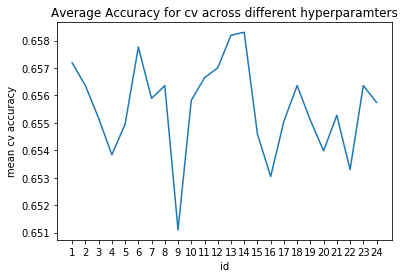

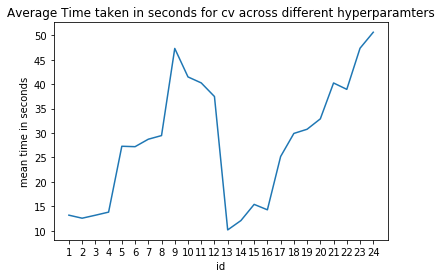


id: 1 | hyperparamter: {'batch_size': 32, 'epochs': 10, 'first_hidden_units': 30, 'hidden_activation_fun': 'relu', 'optimizer': 'adam', 'output_activation_func': 'sigmoid', 'second_hidden_units': 15}
id: 2 | hyperparamter: {'batch_size': 32, 'epochs': 10, 'first_hidden_units': 30, 'hidden_activation_fun': 'relu', 'optimizer': 'rmsprop', 'output_activation_func': 'sigmoid', 'second_hidden_units': 15}
id: 3 | hyperparamter: {'batch_size': 32, 'epochs': 10, 'first_hidden_units': 30, 'hidden_activation_fun': 'sigmoid', 'optimizer': 'adam', 'output_activation_func': 'sigmoid', 'second_hidden_units': 15}
id: 4 | hyperparamter: {'batch_size': 32, 'epochs': 10, 'first_hidden_units': 30, 'hidden_activation_fun': 'sigmoid', 'optimizer': 'rmsprop', 'output_activation_func': 'sigmoid', 'second_hidden_units': 15}
id: 5 | hyperparamter: {'batch_size': 32, 'epochs': 20, 'first_hidden_units': 30, 'hidden_activation_fun': 'relu', 'optimizer': 'adam', 'output_activation_func': 'sigmoid', 'second_hidden

Test accuracy score of best model: 0.6529



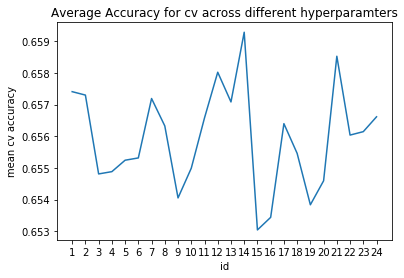

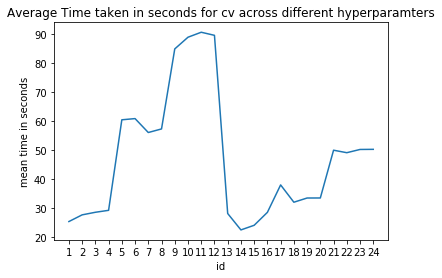


id: 1 | hyperparamter: {'batch_size': 32, 'epochs': 10, 'first_hidden_units': 20, 'hidden_activation_fun': 'relu', 'optimizer': 'adam', 'output_activation_func': 'sigmoid', 'second_hidden_units': 10}
id: 2 | hyperparamter: {'batch_size': 32, 'epochs': 10, 'first_hidden_units': 20, 'hidden_activation_fun': 'relu', 'optimizer': 'rmsprop', 'output_activation_func': 'sigmoid', 'second_hidden_units': 10}
id: 3 | hyperparamter: {'batch_size': 32, 'epochs': 10, 'first_hidden_units': 20, 'hidden_activation_fun': 'sigmoid', 'optimizer': 'adam', 'output_activation_func': 'sigmoid', 'second_hidden_units': 10}
id: 4 | hyperparamter: {'batch_size': 32, 'epochs': 10, 'first_hidden_units': 20, 'hidden_activation_fun': 'sigmoid', 'optimizer': 'rmsprop', 'output_activation_func': 'sigmoid', 'second_hidden_units': 10}
id: 5 | hyperparamter: {'batch_size': 32, 'epochs': 20, 'first_hidden_units': 20, 'hidden_activation_fun': 'relu', 'optimizer': 'adam', 'output_activation_func': 'sigmoid', 'second_hidden

Train accuracy score of best model: 0.6672
Test accuracy score of best model: 0.6524



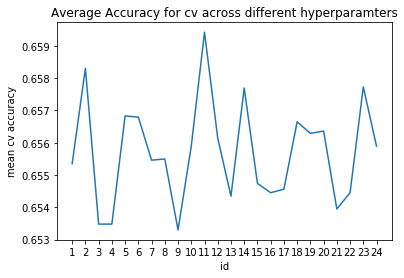

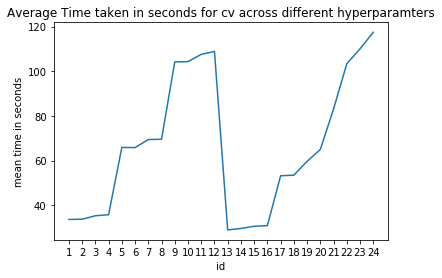


id: 1 | hyperparamter: {'batch_size': 32, 'epochs': 10, 'first_hidden_units': 30, 'hidden_activation_fun': 'relu', 'optimizer': 'adam', 'output_activation_func': 'sigmoid', 'second_hidden_units': 15, 'third_hidden_units': 8}
id: 2 | hyperparamter: {'batch_size': 32, 'epochs': 10, 'first_hidden_units': 30, 'hidden_activation_fun': 'relu', 'optimizer': 'rmsprop', 'output_activation_func': 'sigmoid', 'second_hidden_units': 15, 'third_hidden_units': 8}
id: 3 | hyperparamter: {'batch_size': 32, 'epochs': 10, 'first_hidden_units': 30, 'hidden_activation_fun': 'sigmoid', 'optimizer': 'adam', 'output_activation_func': 'sigmoid', 'second_hidden_units': 15, 'third_hidden_units': 8}
id: 4 | hyperparamter: {'batch_size': 32, 'epochs': 10, 'first_hidden_units': 30, 'hidden_activation_fun': 'sigmoid', 'optimizer': 'rmsprop', 'output_activation_func': 'sigmoid', 'second_hidden_units': 15, 'third_hidden_units': 8}
id: 5 | hyperparamter: {'batch_size': 32, 'epochs': 20, 'first_hidden_units': 30, 'hidd

Test accuracy score of best model: 0.656



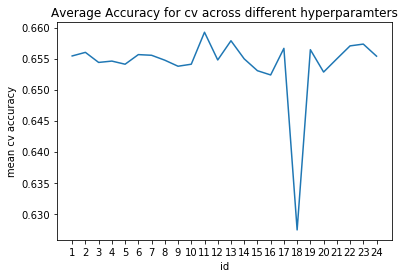

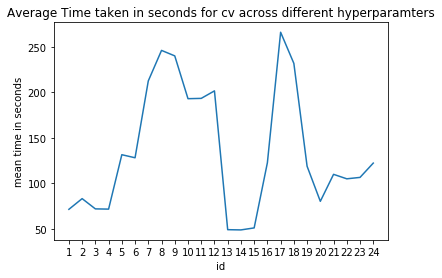


id: 1 | hyperparamter: {'batch_size': 32, 'epochs': 10, 'first_hidden_units': 20, 'hidden_activation_fun': 'relu', 'optimizer': 'adam', 'output_activation_func': 'sigmoid', 'second_hidden_units': 10, 'third_hidden_units': 5}
id: 2 | hyperparamter: {'batch_size': 32, 'epochs': 10, 'first_hidden_units': 20, 'hidden_activation_fun': 'relu', 'optimizer': 'rmsprop', 'output_activation_func': 'sigmoid', 'second_hidden_units': 10, 'third_hidden_units': 5}
id: 3 | hyperparamter: {'batch_size': 32, 'epochs': 10, 'first_hidden_units': 20, 'hidden_activation_fun': 'sigmoid', 'optimizer': 'adam', 'output_activation_func': 'sigmoid', 'second_hidden_units': 10, 'third_hidden_units': 5}
id: 4 | hyperparamter: {'batch_size': 32, 'epochs': 10, 'first_hidden_units': 20, 'hidden_activation_fun': 'sigmoid', 'optimizer': 'rmsprop', 'output_activation_func': 'sigmoid', 'second_hidden_units': 10, 'third_hidden_units': 5}
id: 5 | hyperparamter: {'batch_size': 32, 'epochs': 20, 'first_hidden_units': 20, 'hidd

In [22]:
#Results summary
print("Small network and large hidden units, cv results for first data set")
nn_result(small_network_large_hidden_1, X_train_1,Y_train_1,X_test_1,Y_test_1)

print("small network and small hidden units, cv results for first data set")
nn_result(small_network_small_hidden_1, X_train_1,Y_train_1,X_test_1,Y_test_1)

print("Large network and large hidden units, cv results for first data set")
nn_result(large_network_large_hidden_1, X_train_1,Y_train_1,X_test_1,Y_test_1)

print("Large network and small hidden units, cv results for first data set")
nn_result(large_network_small_hidden_1, X_train_1,Y_train_1,X_test_1,Y_test_1)


Second dataset

In [13]:
#first dataset
#paramters and calling function
small_parameters_1 = {'batch_size': [32,64],
          'epochs': [10,20,30],
          'optimizer': ['adam','rmsprop'],
             'first_hidden_units':[30],
             'second_hidden_units':[15],
              'hidden_activation_fun':['relu','sigmoid'],
            'output_activation_func':['sigmoid']
                   }

small_parameters_2 = {'batch_size': [32,64],
          'epochs': [10,20,30],
          'optimizer': ['adam','rmsprop'],
             'first_hidden_units':[20],
             'second_hidden_units':[10],
              'hidden_activation_fun':['relu','sigmoid'],
            'output_activation_func':['sigmoid']
                   }

large_parameters_1 = {'batch_size': [32,64],
          'epochs': [10,20,30],
          'optimizer': ['adam','rmsprop'],
             'first_hidden_units':[30],
             'second_hidden_units':[15],
              'third_hidden_units':[8],
             'hidden_activation_fun':['relu','sigmoid'],
            'output_activation_func':['sigmoid']
                   }

large_parameters_2 = {'batch_size': [32,64],
          'epochs': [10,20,30],
          'optimizer': ['adam','rmsprop'],
             'first_hidden_units':[20],
             'second_hidden_units':[10],
              'third_hidden_units':[5],
             'hidden_activation_fun':['relu','sigmoid'],
            'output_activation_func':['sigmoid']
                   }

small_network_large_hidden_2=small_network(X_train_2,Y_train_2,X_train_2.shape[1],1,small_parameters_1,cv=5)
print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")
small_network_small_hidden_2=small_network(X_train_2,Y_train_2,X_train_2.shape[1],1,small_parameters_2,cv=5)
print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")
large_network_large_hidden_2=large_network(X_train_2,Y_train_2,X_train_2.shape[1],1,large_parameters_1,cv=5)
print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")
large_network_small_hidden_2=large_network(X_train_2,Y_train_2,X_train_2.shape[1],1,large_parameters_2,cv=5)


C:\Users\saivi\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=63, units=30, kernel_initializer="uniform")`
  """
C:\Users\saivi\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=15, kernel_initializer="uniform")`
  import sys
C:\Users\saivi\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", units=1, kernel_initializer="uniform")`
  if __name__ == '__main__':


Epoch 1/10
23064/23064 [==============================] - 1s 39us/step - loss: 0.2435 - acc: 0.9044
Epoch 2/10
23064/23064 [==============================] - 1s 29us/step - loss: 0.1922 - acc: 0.9106
Epoch 3/10
23064/23064 [==============================] - 1s 39us/step - loss: 0.1896 - acc: 0.9093
Epoch 4/10
23064/23064 [==============================] - 1s 31us/step - loss: 0.1871 - acc: 0.9123
Epoch 5/10
23064/23064 [==============================] - 1s 29us/step - loss: 0.1852 - acc: 0.9129
Epoch 6/10
23064/23064 [==============================] - 1s 32us/step - loss: 0.1827 - acc: 0.9147
Epoch 7/10
23064/23064 [==============================] - 1s 28us/step - loss: 0.1810 - acc: 0.9145
Epoch 8/10
23064/23064 [==============================] - 1s 34us/step - loss: 0.1785 - acc: 0.9162
Epoch 9/10
23064/23064 [==============================] - 1s 32us/step - loss: 0.1770 - acc: 0.9164
Epoch 10/10
23064/23064 [==============================] - 1s 31us/step - loss: 0.1753 - acc: 0.9181

C:\Users\saivi\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", input_dim=63, units=30, kernel_initializer="uniform")`
  """
C:\Users\saivi\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", units=15, kernel_initializer="uniform")`
  import sys


Epoch 1/10
23064/23064 [==============================] - 1s 63us/step - loss: 0.3481 - acc: 0.8796
Epoch 2/10
23064/23064 [==============================] - 1s 34us/step - loss: 0.2620 - acc: 0.8869
Epoch 3/10
23064/23064 [==============================] - 1s 36us/step - loss: 0.2268 - acc: 0.8869
Epoch 4/10
23064/23064 [==============================] - 1s 33us/step - loss: 0.2079 - acc: 0.8869: 0s - loss: 0.2071 - acc:
Epoch 5/10
23064/23064 [==============================] - 1s 32us/step - loss: 0.1991 - acc: 0.8869: 0s - loss: 0.1951 - 
Epoch 6/10
23064/23064 [==============================] - 1s 32us/step - loss: 0.1952 - acc: 0.8984
Epoch 7/10
23064/23064 [==============================] - 1s 31us/step - loss: 0.1935 - acc: 0.9080
Epoch 8/10
23064/23064 [==============================] - 1s 33us/step - loss: 0.1928 - acc: 0.9082
Epoch 9/10
23064/23064 [==============================] - 1s 30us/step - loss: 0.1918 - acc: 0.9093
Epoch 10/10
23064/23064 [===========================

23065/23065 [==============================] - 1s 32us/step - loss: 0.1657 - acc: 0.9223
Epoch 20/20
23065/23065 [==============================] - 1s 32us/step - loss: 0.1648 - acc: 0.9230
Epoch 1/20
23065/23065 [==============================] - 1s 61us/step - loss: 0.2458 - acc: 0.9021
Epoch 2/20
23065/23065 [==============================] - 1s 32us/step - loss: 0.1947 - acc: 0.9078
Epoch 3/20
23065/23065 [==============================] - 1s 32us/step - loss: 0.1924 - acc: 0.9083
Epoch 4/20
23065/23065 [==============================] - 1s 33us/step - loss: 0.1902 - acc: 0.9084
Epoch 5/20
23065/23065 [==============================] - 1s 32us/step - loss: 0.1883 - acc: 0.9097
Epoch 6/20
23065/23065 [==============================] - 1s 32us/step - loss: 0.1866 - acc: 0.9107
Epoch 7/20
23065/23065 [==============================] - 1s 32us/step - loss: 0.1845 - acc: 0.9121
Epoch 8/20
23065/23065 [==============================] - 1s 33us/step - loss: 0.1830 - acc: 0.9128
Epoch 9/20

23064/23064 [==============================] - 1s 34us/step - loss: 0.1848 - acc: 0.9126
Epoch 20/20
23064/23064 [==============================] - 1s 34us/step - loss: 0.1840 - acc: 0.9131
Epoch 1/20
23065/23065 [==============================] - 2s 74us/step - loss: 0.3394 - acc: 0.8887
Epoch 2/20
23065/23065 [==============================] - 1s 38us/step - loss: 0.2597 - acc: 0.8887
Epoch 3/20
23065/23065 [==============================] - 1s 37us/step - loss: 0.2254 - acc: 0.8887
Epoch 4/20
23065/23065 [==============================] - 1s 38us/step - loss: 0.2070 - acc: 0.8887
Epoch 5/20
23065/23065 [==============================] - 1s 37us/step - loss: 0.1986 - acc: 0.8887
Epoch 6/20
23065/23065 [==============================] - 1s 37us/step - loss: 0.1951 - acc: 0.8975
Epoch 7/20
23065/23065 [==============================] - 1s 36us/step - loss: 0.1935 - acc: 0.9074
Epoch 8/20
23065/23065 [==============================] - 1s 36us/step - loss: 0.1925 - acc: 0.9090
Epoch 9/20

23065/23065 [==============================] - 1s 36us/step - loss: 0.1844 - acc: 0.9124
Epoch 20/20
23065/23065 [==============================] - 1s 35us/step - loss: 0.1839 - acc: 0.9124
Epoch 1/20
23064/23064 [==============================] - 2s 76us/step - loss: 0.3398 - acc: 0.8869
Epoch 2/20
23064/23064 [==============================] - 1s 38us/step - loss: 0.2686 - acc: 0.8869
Epoch 3/20
23064/23064 [==============================] - 1s 39us/step - loss: 0.2300 - acc: 0.8869
Epoch 4/20
23064/23064 [==============================] - 1s 38us/step - loss: 0.2088 - acc: 0.8869
Epoch 5/20
23064/23064 [==============================] - 1s 37us/step - loss: 0.1997 - acc: 0.8925
Epoch 6/20
23064/23064 [==============================] - 1s 36us/step - loss: 0.1965 - acc: 0.9093
Epoch 7/20
23064/23064 [==============================] - 1s 36us/step - loss: 0.1949 - acc: 0.9099
Epoch 8/20
23064/23064 [==============================] - 1s 36us/step - loss: 0.1942 - acc: 0.9110
Epoch 9/20

23065/23065 [==============================] - 1s 36us/step - loss: 0.1568 - acc: 0.9242
Epoch 1/30
23065/23065 [==============================] - 2s 85us/step - loss: 0.2519 - acc: 0.9014
Epoch 2/30
23065/23065 [==============================] - 1s 38us/step - loss: 0.1935 - acc: 0.9102: 0s - loss: 0.1932 - ac
Epoch 3/30
23065/23065 [==============================] - 1s 38us/step - loss: 0.1904 - acc: 0.9106
Epoch 4/30
23065/23065 [==============================] - 1s 37us/step - loss: 0.1880 - acc: 0.9117
Epoch 5/30
23065/23065 [==============================] - 1s 37us/step - loss: 0.1853 - acc: 0.9119
Epoch 6/30
23065/23065 [==============================] - 1s 37us/step - loss: 0.1836 - acc: 0.9141
Epoch 7/30
23065/23065 [==============================] - 1s 37us/step - loss: 0.1818 - acc: 0.9143
Epoch 8/30
23065/23065 [==============================] - 1s 37us/step - loss: 0.1797 - acc: 0.9151
Epoch 9/30
23065/23065 [==============================] - 1s 37us/step - loss: 0.1784 -

23065/23065 [==============================] - 1s 39us/step - loss: 0.1833 - acc: 0.9153
Epoch 11/30
23065/23065 [==============================] - 1s 40us/step - loss: 0.1822 - acc: 0.9165
Epoch 12/30
23065/23065 [==============================] - 1s 39us/step - loss: 0.1816 - acc: 0.9156
Epoch 13/30
23065/23065 [==============================] - 1s 38us/step - loss: 0.1804 - acc: 0.9150
Epoch 14/30
23065/23065 [==============================] - 1s 39us/step - loss: 0.1794 - acc: 0.9162
Epoch 15/30
23065/23065 [==============================] - 1s 38us/step - loss: 0.1787 - acc: 0.9172: 0s - loss: 0.1790 - acc: 
Epoch 16/30
23065/23065 [==============================] - 1s 39us/step - loss: 0.1771 - acc: 0.9180
Epoch 17/30
23065/23065 [==============================] - 1s 38us/step - loss: 0.1773 - acc: 0.9173
Epoch 18/30
23065/23065 [==============================] - 1s 39us/step - loss: 0.1759 - acc: 0.9198
Epoch 19/30
23065/23065 [==============================] - 1s 39us/step - lo

23065/23065 [==============================] - 1s 41us/step - loss: 0.1866 - acc: 0.9115
Epoch 20/30
23065/23065 [==============================] - 1s 41us/step - loss: 0.1860 - acc: 0.9116: 0s - loss: 0.1923 - a
Epoch 21/30
23065/23065 [==============================] - 1s 41us/step - loss: 0.1855 - acc: 0.9119
Epoch 22/30
23065/23065 [==============================] - 1s 41us/step - loss: 0.1847 - acc: 0.9121
Epoch 23/30
23065/23065 [==============================] - 1s 41us/step - loss: 0.1842 - acc: 0.9121
Epoch 24/30
23065/23065 [==============================] - 1s 42us/step - loss: 0.1837 - acc: 0.9135
Epoch 25/30
23065/23065 [==============================] - 1s 44us/step - loss: 0.1829 - acc: 0.9138
Epoch 26/30
23065/23065 [==============================] - 1s 47us/step - loss: 0.1820 - acc: 0.9138
Epoch 27/30
23065/23065 [==============================] - 1s 40us/step - loss: 0.1814 - acc: 0.9145
Epoch 28/30
23065/23065 [==============================] - 1s 40us/step - loss: 

23065/23065 [==============================] - 1s 44us/step - loss: 0.1903 - acc: 0.9122
Epoch 28/30
23065/23065 [==============================] - 1s 45us/step - loss: 0.1901 - acc: 0.9119
Epoch 29/30
23065/23065 [==============================] - 1s 45us/step - loss: 0.1896 - acc: 0.9124
Epoch 30/30
23065/23065 [==============================] - 1s 42us/step - loss: 0.1889 - acc: 0.9129
Epoch 1/30
23065/23065 [==============================] - 3s 113us/step - loss: 0.3417 - acc: 0.8853
Epoch 2/30
23065/23065 [==============================] - 1s 43us/step - loss: 0.2716 - acc: 0.8862
Epoch 3/30
23065/23065 [==============================] - 1s 44us/step - loss: 0.2341 - acc: 0.8862
Epoch 4/30
23065/23065 [==============================] - 1s 43us/step - loss: 0.2124 - acc: 0.8862
Epoch 5/30
23065/23065 [==============================] - 1s 45us/step - loss: 0.2030 - acc: 0.8885
Epoch 6/30
23065/23065 [==============================] - 1s 45us/step - loss: 0.1993 - acc: 0.9060
Epoch 7

23065/23065 [==============================] - 1s 25us/step - loss: 0.1806 - acc: 0.9154
Epoch 10/10
23065/23065 [==============================] - 1s 25us/step - loss: 0.1800 - acc: 0.9157
Epoch 1/10
23064/23064 [==============================] - 3s 111us/step - loss: 0.3802 - acc: 0.8869
Epoch 2/10
23064/23064 [==============================] - 1s 25us/step - loss: 0.2918 - acc: 0.8869
Epoch 3/10
23064/23064 [==============================] - 1s 26us/step - loss: 0.2629 - acc: 0.8869
Epoch 4/10
23064/23064 [==============================] - 1s 25us/step - loss: 0.2399 - acc: 0.8869
Epoch 5/10
23064/23064 [==============================] - 1s 31us/step - loss: 0.2228 - acc: 0.8869
Epoch 6/10
23064/23064 [==============================] - 1s 31us/step - loss: 0.2112 - acc: 0.8869
Epoch 7/10
23064/23064 [==============================] - 1s 27us/step - loss: 0.2036 - acc: 0.8869
Epoch 8/10
23064/23064 [==============================] - 1s 26us/step - loss: 0.1990 - acc: 0.8869
Epoch 9/1

23065/23065 [==============================] - 3s 125us/step - loss: 0.2891 - acc: 0.8964
Epoch 2/20
23065/23065 [==============================] - 1s 28us/step - loss: 0.1957 - acc: 0.9076
Epoch 3/20
23065/23065 [==============================] - 1s 28us/step - loss: 0.1927 - acc: 0.9067
Epoch 4/20
23065/23065 [==============================] - 1s 28us/step - loss: 0.1903 - acc: 0.9091
Epoch 5/20
23065/23065 [==============================] - 1s 28us/step - loss: 0.1889 - acc: 0.9093
Epoch 6/20
23065/23065 [==============================] - 1s 28us/step - loss: 0.1868 - acc: 0.9119
Epoch 7/20
23065/23065 [==============================] - 1s 28us/step - loss: 0.1853 - acc: 0.9122
Epoch 8/20
23065/23065 [==============================] - 1s 28us/step - loss: 0.1837 - acc: 0.9133
Epoch 9/20
23065/23065 [==============================] - 1s 28us/step - loss: 0.1821 - acc: 0.9145
Epoch 10/20
23065/23065 [==============================] - 1s 28us/step - loss: 0.1802 - acc: 0.9155
Epoch 11/

23065/23065 [==============================] - 1s 29us/step - loss: 0.2617 - acc: 0.8887
Epoch 4/20
23065/23065 [==============================] - 1s 29us/step - loss: 0.2390 - acc: 0.8887
Epoch 5/20
23065/23065 [==============================] - 1s 29us/step - loss: 0.2221 - acc: 0.8887
Epoch 6/20
23065/23065 [==============================] - 1s 29us/step - loss: 0.2104 - acc: 0.8887
Epoch 7/20
23065/23065 [==============================] - 1s 29us/step - loss: 0.2029 - acc: 0.8887
Epoch 8/20
23065/23065 [==============================] - 1s 29us/step - loss: 0.1984 - acc: 0.8887
Epoch 9/20
23065/23065 [==============================] - 1s 29us/step - loss: 0.1958 - acc: 0.8904
Epoch 10/20
23065/23065 [==============================] - 1s 30us/step - loss: 0.1942 - acc: 0.9016
Epoch 11/20
23065/23065 [==============================] - 1s 29us/step - loss: 0.1932 - acc: 0.9084
Epoch 12/20
23065/23065 [==============================] - 1s 29us/step - loss: 0.1923 - acc: 0.9084
Epoch 13

23065/23065 [==============================] - 1s 29us/step - loss: 0.2209 - acc: 0.8881
Epoch 6/20
23065/23065 [==============================] - 1s 33us/step - loss: 0.2075 - acc: 0.8881
Epoch 7/20
23065/23065 [==============================] - 1s 33us/step - loss: 0.2002 - acc: 0.8881
Epoch 8/20
23065/23065 [==============================] - 1s 43us/step - loss: 0.1963 - acc: 0.8949
Epoch 9/20
23065/23065 [==============================] - 1s 35us/step - loss: 0.1942 - acc: 0.9089
Epoch 10/20
23065/23065 [==============================] - 1s 48us/step - loss: 0.1930 - acc: 0.9105
Epoch 11/20
23065/23065 [==============================] - 1s 41us/step - loss: 0.1923 - acc: 0.9106
Epoch 12/20
23065/23065 [==============================] - 1s 36us/step - loss: 0.1919 - acc: 0.9106
Epoch 13/20
23065/23065 [==============================] - 1s 25us/step - loss: 0.1916 - acc: 0.9119
Epoch 14/20
23065/23065 [==============================] - 1s 36us/step - loss: 0.1913 - acc: 0.9106
Epoch 

23065/23065 [==============================] - 1s 27us/step - loss: 0.1636 - acc: 0.9237
Epoch 28/30
23065/23065 [==============================] - 1s 27us/step - loss: 0.1629 - acc: 0.9232
Epoch 29/30
23065/23065 [==============================] - 1s 27us/step - loss: 0.1626 - acc: 0.9245
Epoch 30/30
23065/23065 [==============================] - 1s 26us/step - loss: 0.1616 - acc: 0.9245
Epoch 1/30
23064/23064 [==============================] - 3s 129us/step - loss: 0.2677 - acc: 0.8974
Epoch 2/30
23064/23064 [==============================] - 1s 27us/step - loss: 0.1927 - acc: 0.9106
Epoch 3/30
23064/23064 [==============================] - 1s 26us/step - loss: 0.1908 - acc: 0.9100
Epoch 4/30
23064/23064 [==============================] - 1s 27us/step - loss: 0.1887 - acc: 0.9122
Epoch 5/30
23064/23064 [==============================] - 1s 27us/step - loss: 0.1869 - acc: 0.9131
Epoch 6/30
23064/23064 [==============================] - 1s 27us/step - loss: 0.1854 - acc: 0.9147
Epoch 7

23064/23064 [==============================] - 1s 28us/step - loss: 0.1968 - acc: 0.8869
Epoch 10/30
23064/23064 [==============================] - 1s 28us/step - loss: 0.1949 - acc: 0.8972
Epoch 11/30
23064/23064 [==============================] - 1s 28us/step - loss: 0.1935 - acc: 0.9058
Epoch 12/30
23064/23064 [==============================] - 1s 29us/step - loss: 0.1928 - acc: 0.9074
Epoch 13/30
23064/23064 [==============================] - 1s 27us/step - loss: 0.1919 - acc: 0.9080
Epoch 14/30
23064/23064 [==============================] - 1s 28us/step - loss: 0.1913 - acc: 0.9091
Epoch 15/30
23064/23064 [==============================] - 1s 28us/step - loss: 0.1908 - acc: 0.9098
Epoch 16/30
23064/23064 [==============================] - 1s 28us/step - loss: 0.1901 - acc: 0.9095
Epoch 17/30
23064/23064 [==============================] - 1s 27us/step - loss: 0.1896 - acc: 0.9100
Epoch 18/30
23064/23064 [==============================] - 1s 28us/step - loss: 0.1888 - acc: 0.9094
Ep

23065/23065 [==============================] - 1s 28us/step - loss: 0.1852 - acc: 0.9118
Epoch 1/30
23065/23065 [==============================] - 3s 140us/step - loss: 0.3846 - acc: 0.8862
Epoch 2/30
23065/23065 [==============================] - 1s 28us/step - loss: 0.2947 - acc: 0.8862
Epoch 3/30
23065/23065 [==============================] - 1s 28us/step - loss: 0.2661 - acc: 0.8862
Epoch 4/30
23065/23065 [==============================] - 1s 28us/step - loss: 0.2430 - acc: 0.8862
Epoch 5/30
23065/23065 [==============================] - 1s 28us/step - loss: 0.2256 - acc: 0.8862
Epoch 6/30
23065/23065 [==============================] - 1s 28us/step - loss: 0.2140 - acc: 0.8862
Epoch 7/30
23065/23065 [==============================] - 1s 29us/step - loss: 0.2064 - acc: 0.8862
Epoch 8/30
23065/23065 [==============================] - 1s 29us/step - loss: 0.2015 - acc: 0.8862
Epoch 9/30
23065/23065 [==============================] - 1s 28us/step - loss: 0.1989 - acc: 0.8864
Epoch 10/3

23065/23065 [==============================] - 1s 33us/step - loss: 0.1963 - acc: 0.9080
Epoch 12/30
23065/23065 [==============================] - 1s 35us/step - loss: 0.1958 - acc: 0.9076
Epoch 13/30
23065/23065 [==============================] - 1s 35us/step - loss: 0.1954 - acc: 0.9074
Epoch 14/30
23065/23065 [==============================] - 1s 33us/step - loss: 0.1952 - acc: 0.9077
Epoch 15/30
23065/23065 [==============================] - 1s 46us/step - loss: 0.1947 - acc: 0.9077
Epoch 16/30
23065/23065 [==============================] - 1s 44us/step - loss: 0.1946 - acc: 0.9068
Epoch 17/30
23065/23065 [==============================] - 1s 52us/step - loss: 0.1943 - acc: 0.9072
Epoch 18/30
23065/23065 [==============================] - 1s 59us/step - loss: 0.1941 - acc: 0.9077
Epoch 19/30
23065/23065 [==============================] - 1s 36us/step - loss: 0.1939 - acc: 0.9080
Epoch 20/30
23065/23065 [==============================] - 1s 42us/step - loss: 0.1936 - acc: 0.9080
Ep

C:\Users\saivi\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=63, units=20, kernel_initializer="uniform")`
  """
C:\Users\saivi\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=10, kernel_initializer="uniform")`
  import sys


Epoch 1/10
23064/23064 [==============================] - 5s 232us/step - loss: 0.2588 - acc: 0.9036
Epoch 2/10
23064/23064 [==============================] - 2s 80us/step - loss: 0.1916 - acc: 0.9109
Epoch 3/10
23064/23064 [==============================] - 2s 81us/step - loss: 0.1886 - acc: 0.9114
Epoch 4/10
23064/23064 [==============================] - 2s 84us/step - loss: 0.1866 - acc: 0.9125
Epoch 5/10
23064/23064 [==============================] - 2s 66us/step - loss: 0.1849 - acc: 0.9137
Epoch 6/10
23064/23064 [==============================] - 2s 68us/step - loss: 0.1831 - acc: 0.9134
Epoch 7/10
23064/23064 [==============================] - 1s 63us/step - loss: 0.1817 - acc: 0.9150
Epoch 8/10
23064/23064 [==============================] - 1s 64us/step - loss: 0.1800 - acc: 0.9159
Epoch 9/10
23064/23064 [==============================] - 1s 62us/step - loss: 0.1784 - acc: 0.9163
Epoch 10/10
23064/23064 [==============================] - 1s 64us/step - loss: 0.1771 - acc: 0.917

23065/23065 [==============================] - 2s 68us/step - loss: 0.1962 - acc: 0.9082
Epoch 3/10
23065/23065 [==============================] - 2s 76us/step - loss: 0.1946 - acc: 0.9077
Epoch 4/10
23065/23065 [==============================] - 2s 78us/step - loss: 0.1930 - acc: 0.9083
Epoch 5/10
23065/23065 [==============================] - 2s 75us/step - loss: 0.1911 - acc: 0.9101
Epoch 6/10
23065/23065 [==============================] - 2s 85us/step - loss: 0.1901 - acc: 0.9095
Epoch 7/10
23065/23065 [==============================] - 2s 75us/step - loss: 0.1886 - acc: 0.9113
Epoch 8/10
23065/23065 [==============================] - 2s 70us/step - loss: 0.1878 - acc: 0.9116
Epoch 9/10
23065/23065 [==============================] - 2s 73us/step - loss: 0.1872 - acc: 0.9121
Epoch 10/10
23065/23065 [==============================] - 1s 58us/step - loss: 0.1864 - acc: 0.9122
Epoch 1/10
23065/23065 [==============================] - 5s 211us/step - loss: 0.2601 - acc: 0.9008
Epoch 2/1

C:\Users\saivi\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", input_dim=63, units=20, kernel_initializer="uniform")`
  """
C:\Users\saivi\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", units=10, kernel_initializer="uniform")`
  import sys


Epoch 1/10
23064/23064 [==============================] - 4s 190us/step - loss: 0.3623 - acc: 0.8774
Epoch 2/10
23064/23064 [==============================] - 1s 57us/step - loss: 0.2663 - acc: 0.8869
Epoch 3/10
23064/23064 [==============================] - 1s 58us/step - loss: 0.2310 - acc: 0.8869
Epoch 4/10
23064/23064 [==============================] - 1s 57us/step - loss: 0.2109 - acc: 0.8869
Epoch 5/10
23064/23064 [==============================] - 1s 57us/step - loss: 0.2010 - acc: 0.8869
Epoch 6/10
23064/23064 [==============================] - 1s 63us/step - loss: 0.1967 - acc: 0.8910
Epoch 7/10
23064/23064 [==============================] - 1s 59us/step - loss: 0.1945 - acc: 0.9052
Epoch 8/10
23064/23064 [==============================] - 1s 58us/step - loss: 0.1932 - acc: 0.9088
Epoch 9/10
23064/23064 [==============================] - 1s 58us/step - loss: 0.1924 - acc: 0.9089
Epoch 10/10
23064/23064 [==============================] - 1s 58us/step - loss: 0.1919 - acc: 0.908

23065/23065 [==============================] - 2s 65us/step - loss: 0.1937 - acc: 0.9059: 1s - loss:
Epoch 4/20
23065/23065 [==============================] - 1s 65us/step - loss: 0.1924 - acc: 0.9074
Epoch 5/20
23065/23065 [==============================] - 1s 65us/step - loss: 0.1908 - acc: 0.9073
Epoch 6/20
23065/23065 [==============================] - 1s 64us/step - loss: 0.1893 - acc: 0.9073: 1s - loss:
Epoch 7/20
23065/23065 [==============================] - 2s 65us/step - loss: 0.1872 - acc: 0.9094
Epoch 8/20
23065/23065 [==============================] - 2s 65us/step - loss: 0.1858 - acc: 0.9111
Epoch 9/20
23065/23065 [==============================] - 2s 67us/step - loss: 0.1843 - acc: 0.9125
Epoch 10/20
23065/23065 [==============================] - 1s 65us/step - loss: 0.1829 - acc: 0.9126
Epoch 11/20
23065/23065 [==============================] - 1s 64us/step - loss: 0.1816 - acc: 0.9132
Epoch 12/20
23065/23065 [==============================] - 2s 65us/step - loss: 0.179

Epoch 4/20
23065/23065 [==============================] - 1s 65us/step - loss: 0.1910 - acc: 0.9125
Epoch 5/20
23065/23065 [==============================] - 1s 64us/step - loss: 0.1895 - acc: 0.9130
Epoch 6/20
23065/23065 [==============================] - 1s 64us/step - loss: 0.1886 - acc: 0.9132
Epoch 7/20
23065/23065 [==============================] - 1s 65us/step - loss: 0.1876 - acc: 0.9133
Epoch 8/20
23065/23065 [==============================] - 1s 64us/step - loss: 0.1865 - acc: 0.9148
Epoch 9/20
23065/23065 [==============================] - 1s 65us/step - loss: 0.1858 - acc: 0.9140
Epoch 10/20
23065/23065 [==============================] - 2s 70us/step - loss: 0.1847 - acc: 0.9155
Epoch 11/20
23065/23065 [==============================] - 2s 65us/step - loss: 0.1841 - acc: 0.9148
Epoch 12/20
23065/23065 [==============================] - 1s 64us/step - loss: 0.1833 - acc: 0.9164
Epoch 13/20
23065/23065 [==============================] - 1s 65us/step - loss: 0.1827 - acc: 0.9

23064/23064 [==============================] - 1s 64us/step - loss: 0.1974 - acc: 0.9070
Epoch 7/20
23064/23064 [==============================] - 1s 64us/step - loss: 0.1954 - acc: 0.9104
Epoch 8/20
23064/23064 [==============================] - 1s 63us/step - loss: 0.1946 - acc: 0.9103
Epoch 9/20
23064/23064 [==============================] - 1s 64us/step - loss: 0.1940 - acc: 0.9105
Epoch 10/20
23064/23064 [==============================] - 1s 64us/step - loss: 0.1935 - acc: 0.9106
Epoch 11/20
23064/23064 [==============================] - 1s 63us/step - loss: 0.1931 - acc: 0.9100
Epoch 12/20
23064/23064 [==============================] - 1s 64us/step - loss: 0.1929 - acc: 0.9114
Epoch 13/20
23064/23064 [==============================] - 1s 64us/step - loss: 0.1928 - acc: 0.9104
Epoch 14/20
23064/23064 [==============================] - 1s 65us/step - loss: 0.1926 - acc: 0.9107
Epoch 15/20
23064/23064 [==============================] - 1s 64us/step - loss: 0.1922 - acc: 0.9106
Epoch

23065/23065 [==============================] - 2s 70us/step - loss: 0.1895 - acc: 0.9104
Epoch 8/30
23065/23065 [==============================] - 2s 70us/step - loss: 0.1881 - acc: 0.9106
Epoch 9/30
23065/23065 [==============================] - 2s 69us/step - loss: 0.1875 - acc: 0.9120
Epoch 10/30
23065/23065 [==============================] - 2s 69us/step - loss: 0.1865 - acc: 0.9114
Epoch 11/30
23065/23065 [==============================] - 2s 70us/step - loss: 0.1851 - acc: 0.9121
Epoch 12/30
23065/23065 [==============================] - 2s 70us/step - loss: 0.1840 - acc: 0.9135
Epoch 13/30
23065/23065 [==============================] - 2s 70us/step - loss: 0.1829 - acc: 0.9126
Epoch 14/30
23065/23065 [==============================] - 2s 70us/step - loss: 0.1818 - acc: 0.9139
Epoch 15/30
23065/23065 [==============================] - 2s 76us/step - loss: 0.1809 - acc: 0.9134
Epoch 16/30
23065/23065 [==============================] - 2s 70us/step - loss: 0.1797 - acc: 0.9146
Epoc

23065/23065 [==============================] - 2s 77us/step - loss: 0.1795 - acc: 0.9169
Epoch 20/30
23065/23065 [==============================] - 2s 80us/step - loss: 0.1792 - acc: 0.9170
Epoch 21/30
23065/23065 [==============================] - 2s 78us/step - loss: 0.1785 - acc: 0.9173
Epoch 22/30
23065/23065 [==============================] - 2s 91us/step - loss: 0.1779 - acc: 0.9176
Epoch 23/30
23065/23065 [==============================] - 2s 82us/step - loss: 0.1774 - acc: 0.9186
Epoch 24/30
23065/23065 [==============================] - 2s 72us/step - loss: 0.1767 - acc: 0.9183
Epoch 25/30
23065/23065 [==============================] - 2s 80us/step - loss: 0.1760 - acc: 0.9181
Epoch 26/30
23065/23065 [==============================] - 2s 82us/step - loss: 0.1758 - acc: 0.9191
Epoch 27/30
23065/23065 [==============================] - 2s 82us/step - loss: 0.1756 - acc: 0.9195
Epoch 28/30
23065/23065 [==============================] - 2s 82us/step - loss: 0.1752 - acc: 0.9198
Ep

23065/23065 [==============================] - 6s 267us/step - loss: 0.3539 - acc: 0.8862
Epoch 2/30
23065/23065 [==============================] - 2s 72us/step - loss: 0.2694 - acc: 0.8862
Epoch 3/30
23065/23065 [==============================] - 2s 85us/step - loss: 0.2338 - acc: 0.8862
Epoch 4/30
23065/23065 [==============================] - 2s 84us/step - loss: 0.2133 - acc: 0.8862
Epoch 5/30
23065/23065 [==============================] - 2s 88us/step - loss: 0.2035 - acc: 0.8862
Epoch 6/30
23065/23065 [==============================] - 2s 89us/step - loss: 0.1990 - acc: 0.8868
Epoch 7/30
23065/23065 [==============================] - 2s 86us/step - loss: 0.1971 - acc: 0.9036
Epoch 8/30
23065/23065 [==============================] - 2s 99us/step - loss: 0.1960 - acc: 0.9067
Epoch 9/30
23065/23065 [==============================] - 2s 99us/step - loss: 0.1953 - acc: 0.9055
Epoch 10/30
23065/23065 [==============================] - 2s 97us/step - loss: 0.1948 - acc: 0.9067
Epoch 11/

23065/23065 [==============================] - 2s 108us/step - loss: 0.1957 - acc: 0.9072
Epoch 14/30
23065/23065 [==============================] - 3s 119us/step - loss: 0.1953 - acc: 0.9073
Epoch 15/30
23065/23065 [==============================] - 2s 106us/step - loss: 0.1954 - acc: 0.9080
Epoch 16/30
23065/23065 [==============================] - 2s 105us/step - loss: 0.1951 - acc: 0.9078
Epoch 17/30
23065/23065 [==============================] - 2s 105us/step - loss: 0.1950 - acc: 0.9075
Epoch 18/30
23065/23065 [==============================] - 2s 105us/step - loss: 0.1949 - acc: 0.9079
Epoch 19/30
23065/23065 [==============================] - 3s 113us/step - loss: 0.1948 - acc: 0.9076
Epoch 20/30
23065/23065 [==============================] - 2s 105us/step - loss: 0.1944 - acc: 0.9081
Epoch 21/30
23065/23065 [==============================] - 2s 100us/step - loss: 0.1940 - acc: 0.9082
Epoch 22/30
23065/23065 [==============================] - 2s 103us/step - loss: 0.1938 - acc:

23065/23065 [==============================] - 2s 67us/step - loss: 0.1954 - acc: 0.9065
Epoch 5/10
23065/23065 [==============================] - 2s 66us/step - loss: 0.1941 - acc: 0.9088
Epoch 6/10
23065/23065 [==============================] - 2s 68us/step - loss: 0.1924 - acc: 0.9090
Epoch 7/10
23065/23065 [==============================] - 1s 63us/step - loss: 0.1906 - acc: 0.9100
Epoch 8/10
23065/23065 [==============================] - 1s 57us/step - loss: 0.1886 - acc: 0.9112
Epoch 9/10
23065/23065 [==============================] - 1s 50us/step - loss: 0.1872 - acc: 0.9128
Epoch 10/10
23065/23065 [==============================] - 1s 50us/step - loss: 0.1854 - acc: 0.9124
Epoch 1/10
23065/23065 [==============================] - 7s 292us/step - loss: 0.3218 - acc: 0.8944
Epoch 2/10
23065/23065 [==============================] - 1s 51us/step - loss: 0.1947 - acc: 0.9105
Epoch 3/10
23065/23065 [==============================] - 1s 53us/step - loss: 0.1903 - acc: 0.9116
Epoch 4/1

23065/23065 [==============================] - 1s 59us/step - loss: 0.2118 - acc: 0.8881
Epoch 7/10
23065/23065 [==============================] - 1s 58us/step - loss: 0.2028 - acc: 0.8881
Epoch 8/10
23065/23065 [==============================] - 1s 60us/step - loss: 0.1978 - acc: 0.8893
Epoch 9/10
23065/23065 [==============================] - 1s 56us/step - loss: 0.1951 - acc: 0.9060
Epoch 10/10
23065/23065 [==============================] - 1s 55us/step - loss: 0.1936 - acc: 0.9097
Epoch 1/20
23064/23064 [==============================] - 8s 329us/step - loss: 0.3081 - acc: 0.8971
Epoch 2/20
23064/23064 [==============================] - 2s 67us/step - loss: 0.1931 - acc: 0.9116
Epoch 3/20
23064/23064 [==============================] - 1s 62us/step - loss: 0.1904 - acc: 0.9105
Epoch 4/20
23064/23064 [==============================] - 1s 54us/step - loss: 0.1892 - acc: 0.9113
Epoch 5/20
23064/23064 [==============================] - 1s 54us/step - loss: 0.1879 - acc: 0.9123
Epoch 6/2

23065/23065 [==============================] - 1s 55us/step - loss: 0.1804 - acc: 0.9155
Epoch 19/20
23065/23065 [==============================] - 1s 57us/step - loss: 0.1796 - acc: 0.9168
Epoch 20/20
23065/23065 [==============================] - 1s 61us/step - loss: 0.1788 - acc: 0.9170
Epoch 1/20
23065/23065 [==============================] - 7s 318us/step - loss: 0.2974 - acc: 0.8968
Epoch 2/20
23065/23065 [==============================] - 1s 55us/step - loss: 0.1978 - acc: 0.9082
Epoch 3/20
23065/23065 [==============================] - 1s 56us/step - loss: 0.1947 - acc: 0.9076
Epoch 4/20
23065/23065 [==============================] - 1s 56us/step - loss: 0.1927 - acc: 0.9077
Epoch 5/20
23065/23065 [==============================] - 1s 56us/step - loss: 0.1909 - acc: 0.9098
Epoch 6/20
23065/23065 [==============================] - 1s 55us/step - loss: 0.1895 - acc: 0.9098
Epoch 7/20
23065/23065 [==============================] - 1s 55us/step - loss: 0.1882 - acc: 0.9096
Epoch 8/

23064/23064 [==============================] - 1s 49us/step - loss: 0.1913 - acc: 0.9112
Epoch 1/20
23065/23065 [==============================] - 7s 305us/step - loss: 0.3870 - acc: 0.8887
Epoch 2/20
23065/23065 [==============================] - 1s 52us/step - loss: 0.2969 - acc: 0.8887
Epoch 3/20
23065/23065 [==============================] - 1s 49us/step - loss: 0.2702 - acc: 0.8887
Epoch 4/20
23065/23065 [==============================] - 1s 49us/step - loss: 0.2454 - acc: 0.8887
Epoch 5/20
23065/23065 [==============================] - 1s 49us/step - loss: 0.2256 - acc: 0.8887
Epoch 6/20
23065/23065 [==============================] - 1s 49us/step - loss: 0.2121 - acc: 0.8887
Epoch 7/20
23065/23065 [==============================] - 1s 49us/step - loss: 0.2035 - acc: 0.8887
Epoch 8/20
23065/23065 [==============================] - 1s 48us/step - loss: 0.1987 - acc: 0.8888
Epoch 9/20
23065/23065 [==============================] - 1s 49us/step - loss: 0.1958 - acc: 0.9044
Epoch 10/2

23065/23065 [==============================] - 1s 57us/step - loss: 0.1750 - acc: 0.9192
Epoch 23/30
23065/23065 [==============================] - 1s 53us/step - loss: 0.1745 - acc: 0.9197
Epoch 24/30
23065/23065 [==============================] - 1s 51us/step - loss: 0.1739 - acc: 0.9198
Epoch 25/30
23065/23065 [==============================] - 1s 50us/step - loss: 0.1732 - acc: 0.9203
Epoch 26/30
23065/23065 [==============================] - 1s 50us/step - loss: 0.1728 - acc: 0.9213
Epoch 27/30
23065/23065 [==============================] - 1s 50us/step - loss: 0.1721 - acc: 0.9201
Epoch 28/30
23065/23065 [==============================] - 1s 50us/step - loss: 0.1722 - acc: 0.9215
Epoch 29/30
23065/23065 [==============================] - 1s 50us/step - loss: 0.1712 - acc: 0.9209
Epoch 30/30
23065/23065 [==============================] - 1s 50us/step - loss: 0.1711 - acc: 0.9214
Epoch 1/30
23065/23065 [==============================] - 7s 309us/step - loss: 0.3075 - acc: 0.8974
Ep

23065/23065 [==============================] - 1s 57us/step - loss: 0.1933 - acc: 0.9077
Epoch 5/30
23065/23065 [==============================] - 2s 70us/step - loss: 0.1921 - acc: 0.9083
Epoch 6/30
23065/23065 [==============================] - 2s 78us/step - loss: 0.1908 - acc: 0.9085
Epoch 7/30
23065/23065 [==============================] - 1s 62us/step - loss: 0.1898 - acc: 0.9093
Epoch 8/30
23065/23065 [==============================] - 1s 50us/step - loss: 0.1885 - acc: 0.9095
Epoch 9/30
23065/23065 [==============================] - 2s 66us/step - loss: 0.1875 - acc: 0.9101
Epoch 10/30
23065/23065 [==============================] - 1s 57us/step - loss: 0.1870 - acc: 0.9111
Epoch 11/30
23065/23065 [==============================] - 1s 50us/step - loss: 0.1861 - acc: 0.9122
Epoch 12/30
23065/23065 [==============================] - 1s 52us/step - loss: 0.1854 - acc: 0.9121
Epoch 13/30
23065/23065 [==============================] - 1s 52us/step - loss: 0.1848 - acc: 0.9122
Epoch 1

Epoch 16/30
23065/23065 [==============================] - 1s 55us/step - loss: 0.1940 - acc: 0.9064
Epoch 17/30
23065/23065 [==============================] - 1s 55us/step - loss: 0.1935 - acc: 0.9067
Epoch 18/30
23065/23065 [==============================] - 2s 80us/step - loss: 0.1929 - acc: 0.9070
Epoch 19/30
23065/23065 [==============================] - 1s 57us/step - loss: 0.1923 - acc: 0.9073
Epoch 20/30
23065/23065 [==============================] - 2s 77us/step - loss: 0.1917 - acc: 0.9079
Epoch 21/30
23065/23065 [==============================] - 1s 59us/step - loss: 0.1911 - acc: 0.9079
Epoch 22/30
23065/23065 [==============================] - 1s 56us/step - loss: 0.1908 - acc: 0.9079
Epoch 23/30
23065/23065 [==============================] - 2s 73us/step - loss: 0.1902 - acc: 0.9086
Epoch 24/30
23065/23065 [==============================] - 1s 57us/step - loss: 0.1898 - acc: 0.9092
Epoch 25/30
23065/23065 [==============================] - 1s 58us/step - loss: 0.1894 - ac

23065/23065 [==============================] - 2s 68us/step - loss: 0.1921 - acc: 0.9086
Epoch 29/30
23065/23065 [==============================] - 1s 57us/step - loss: 0.1916 - acc: 0.9082
Epoch 30/30
23065/23065 [==============================] - 1s 57us/step - loss: 0.1913 - acc: 0.9086
Epoch 1/30
23065/23065 [==============================] - 8s 333us/step - loss: 0.3900 - acc: 0.8881
Epoch 2/30
23065/23065 [==============================] - 1s 53us/step - loss: 0.2990 - acc: 0.8881
Epoch 3/30
23065/23065 [==============================] - 1s 52us/step - loss: 0.2707 - acc: 0.8881
Epoch 4/30
23065/23065 [==============================] - 1s 53us/step - loss: 0.2447 - acc: 0.8881
Epoch 5/30
23065/23065 [==============================] - 1s 52us/step - loss: 0.2246 - acc: 0.8881
Epoch 6/30
23065/23065 [==============================] - 1s 54us/step - loss: 0.2107 - acc: 0.8881
Epoch 7/30
23065/23065 [==============================] - 1s 58us/step - loss: 0.2022 - acc: 0.8881
Epoch 8/

C:\Users\saivi\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=63, units=15, kernel_initializer="uniform")`
  
C:\Users\saivi\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=8, kernel_initializer="uniform")`
  import sys


Epoch 1/10
23064/23064 [==============================] - 9s 406us/step - loss: 0.2484 - acc: 0.9011
Epoch 2/10
23064/23064 [==============================] - 3s 118us/step - loss: 0.1926 - acc: 0.9093
Epoch 3/10
23064/23064 [==============================] - 3s 111us/step - loss: 0.1907 - acc: 0.9106
Epoch 4/10
23064/23064 [==============================] - 3s 112us/step - loss: 0.1885 - acc: 0.9123
Epoch 5/10
23064/23064 [==============================] - 3s 118us/step - loss: 0.1866 - acc: 0.9117
Epoch 6/10
23064/23064 [==============================] - 3s 111us/step - loss: 0.1834 - acc: 0.9130
Epoch 7/10
23064/23064 [==============================] - 3s 115us/step - loss: 0.1809 - acc: 0.9144
Epoch 8/10
23064/23064 [==============================] - 2s 106us/step - loss: 0.1790 - acc: 0.9155
Epoch 9/10
23064/23064 [==============================] - 3s 112us/step - loss: 0.1780 - acc: 0.9159
Epoch 10/10
23064/23064 [==============================] - 2s 106us/step - loss: 0.1762 - a

23065/23065 [==============================] - 2s 107us/step - loss: 0.1972 - acc: 0.9072
Epoch 3/10
23065/23065 [==============================] - 2s 107us/step - loss: 0.1959 - acc: 0.9065
Epoch 4/10
23065/23065 [==============================] - 2s 108us/step - loss: 0.1935 - acc: 0.9079
Epoch 5/10
23065/23065 [==============================] - 2s 107us/step - loss: 0.1919 - acc: 0.9092
Epoch 6/10
23065/23065 [==============================] - 2s 107us/step - loss: 0.1900 - acc: 0.9095
Epoch 7/10
23065/23065 [==============================] - 2s 107us/step - loss: 0.1888 - acc: 0.9107
Epoch 8/10
23065/23065 [==============================] - 2s 107us/step - loss: 0.1873 - acc: 0.9121
Epoch 9/10
23065/23065 [==============================] - 2s 108us/step - loss: 0.1862 - acc: 0.9121 0s - loss: 0.185
Epoch 10/10
23065/23065 [==============================] - 2s 107us/step - loss: 0.1856 - acc: 0.9124
Epoch 1/10
23065/23065 [==============================] - 10s 422us/step - loss: 0.2

C:\Users\saivi\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", input_dim=63, units=15, kernel_initializer="uniform")`
  
C:\Users\saivi\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", units=8, kernel_initializer="uniform")`
  import sys


Epoch 1/10
23064/23064 [==============================] - 10s 422us/step - loss: 0.3906 - acc: 0.8824
Epoch 2/10
23064/23064 [==============================] - 3s 112us/step - loss: 0.3088 - acc: 0.8869
Epoch 3/10
23064/23064 [==============================] - 3s 111us/step - loss: 0.2640 - acc: 0.8869
Epoch 4/10
23064/23064 [==============================] - 3s 111us/step - loss: 0.2286 - acc: 0.8869
Epoch 5/10
23064/23064 [==============================] - 3s 111us/step - loss: 0.2107 - acc: 0.8869
Epoch 6/10
23064/23064 [==============================] - 3s 111us/step - loss: 0.2029 - acc: 0.8869
Epoch 7/10
23064/23064 [==============================] - 3s 111us/step - loss: 0.2000 - acc: 0.8869
Epoch 8/10
23064/23064 [==============================] - 3s 117us/step - loss: 0.1980 - acc: 0.8871
Epoch 9/10
23064/23064 [==============================] - 3s 112us/step - loss: 0.1969 - acc: 0.8985
Epoch 10/10
23064/23064 [==============================] - 3s 111us/step - loss: 0.1956 - 

23065/23065 [==============================] - 10s 448us/step - loss: 0.2500 - acc: 0.8862
Epoch 2/20
23065/23065 [==============================] - 3s 119us/step - loss: 0.1981 - acc: 0.9027
Epoch 3/20
23065/23065 [==============================] - 3s 119us/step - loss: 0.1955 - acc: 0.9070
Epoch 4/20
23065/23065 [==============================] - 3s 118us/step - loss: 0.1926 - acc: 0.9075
Epoch 5/20
23065/23065 [==============================] - 3s 118us/step - loss: 0.1905 - acc: 0.9093
Epoch 6/20
23065/23065 [==============================] - 3s 118us/step - loss: 0.1883 - acc: 0.9116
Epoch 7/20
23065/23065 [==============================] - 3s 120us/step - loss: 0.1862 - acc: 0.9120
Epoch 8/20
23065/23065 [==============================] - 3s 118us/step - loss: 0.1838 - acc: 0.9142
Epoch 9/20
23065/23065 [==============================] - 3s 125us/step - loss: 0.1823 - acc: 0.9157
Epoch 10/20
23065/23065 [==============================] - 3s 121us/step - loss: 0.1809 - acc: 0.9156

23065/23065 [==============================] - 12s 516us/step - loss: 0.3855 - acc: 0.8865
Epoch 2/20
23065/23065 [==============================] - 3s 135us/step - loss: 0.3062 - acc: 0.8887
Epoch 3/20
23065/23065 [==============================] - 3s 135us/step - loss: 0.2630 - acc: 0.8887
Epoch 4/20
23065/23065 [==============================] - 3s 139us/step - loss: 0.2288 - acc: 0.8887
Epoch 5/20
23065/23065 [==============================] - 3s 137us/step - loss: 0.2103 - acc: 0.8887
Epoch 6/20
23065/23065 [==============================] - 3s 140us/step - loss: 0.2020 - acc: 0.8887
Epoch 7/20
23065/23065 [==============================] - 3s 142us/step - loss: 0.1988 - acc: 0.8887
Epoch 8/20
23065/23065 [==============================] - 3s 141us/step - loss: 0.1971 - acc: 0.8887
Epoch 9/20
23065/23065 [==============================] - 3s 140us/step - loss: 0.1958 - acc: 0.8986
Epoch 10/20
23065/23065 [==============================] - 3s 139us/step - loss: 0.1948 - acc: 0.9057

23065/23065 [==============================] - 13s 548us/step - loss: 0.3794 - acc: 0.8881
Epoch 2/20
23065/23065 [==============================] - 3s 144us/step - loss: 0.3213 - acc: 0.8881
Epoch 3/20
23065/23065 [==============================] - 3s 143us/step - loss: 0.2894 - acc: 0.8881
Epoch 4/20
23065/23065 [==============================] - 3s 148us/step - loss: 0.2515 - acc: 0.8881
Epoch 5/20
23065/23065 [==============================] - 4s 156us/step - loss: 0.2209 - acc: 0.8881
Epoch 6/20
23065/23065 [==============================] - 4s 154us/step - loss: 0.2061 - acc: 0.8881
Epoch 7/20
23065/23065 [==============================] - 5s 201us/step - loss: 0.2004 - acc: 0.8892
Epoch 8/20
23065/23065 [==============================] - 4s 158us/step - loss: 0.1983 - acc: 0.9074
Epoch 9/20
23065/23065 [==============================] - 3s 143us/step - loss: 0.1969 - acc: 0.9097
Epoch 10/20
23065/23065 [==============================] - 3s 143us/step - loss: 0.1957 - acc: 0.9113

23065/23065 [==============================] - 3s 144us/step - loss: 0.1609 - acc: 0.9258
Epoch 22/30
23065/23065 [==============================] - 3s 144us/step - loss: 0.1598 - acc: 0.9270
Epoch 23/30
23065/23065 [==============================] - 3s 143us/step - loss: 0.1590 - acc: 0.9274
Epoch 24/30
23065/23065 [==============================] - 3s 144us/step - loss: 0.1589 - acc: 0.9286
Epoch 25/30
23065/23065 [==============================] - 3s 147us/step - loss: 0.1574 - acc: 0.9281
Epoch 26/30
23065/23065 [==============================] - 3s 145us/step - loss: 0.1561 - acc: 0.9280
Epoch 27/30
23065/23065 [==============================] - 3s 145us/step - loss: 0.1558 - acc: 0.9293
Epoch 28/30
23065/23065 [==============================] - 3s 148us/step - loss: 0.1547 - acc: 0.9303
Epoch 29/30
23065/23065 [==============================] - 3s 144us/step - loss: 0.1543 - acc: 0.9292
Epoch 30/30
23065/23065 [==============================] - 4s 152us/step - loss: 0.1523 - acc:

23064/23064 [==============================] - 14s 587us/step - loss: 0.3816 - acc: 0.8869
Epoch 2/30
23064/23064 [==============================] - 4s 169us/step - loss: 0.3098 - acc: 0.8869
Epoch 3/30
23064/23064 [==============================] - 4s 166us/step - loss: 0.2651 - acc: 0.8869
Epoch 4/30
23064/23064 [==============================] - 4s 165us/step - loss: 0.2293 - acc: 0.8869
Epoch 5/30
23064/23064 [==============================] - 4s 168us/step - loss: 0.2108 - acc: 0.8869
Epoch 6/30
23064/23064 [==============================] - 4s 168us/step - loss: 0.2030 - acc: 0.8869
Epoch 7/30
23064/23064 [==============================] - 4s 177us/step - loss: 0.1995 - acc: 0.8869
Epoch 8/30
23064/23064 [==============================] - 4s 168us/step - loss: 0.1979 - acc: 0.8871
Epoch 9/30
23064/23064 [==============================] - 4s 170us/step - loss: 0.1966 - acc: 0.9015
Epoch 10/30
23064/23064 [==============================] - 4s 168us/step - loss: 0.1954 - acc: 0.9053

23064/23064 [==============================] - 3s 134us/step - loss: 0.1963 - acc: 0.9095
Epoch 12/30
23064/23064 [==============================] - 3s 141us/step - loss: 0.1955 - acc: 0.9106
Epoch 13/30
23064/23064 [==============================] - 4s 159us/step - loss: 0.1950 - acc: 0.9106
Epoch 14/30
23064/23064 [==============================] - 3s 143us/step - loss: 0.1945 - acc: 0.9102
Epoch 15/30
23064/23064 [==============================] - 3s 139us/step - loss: 0.1942 - acc: 0.9102
Epoch 16/30
23064/23064 [==============================] - 4s 152us/step - loss: 0.1938 - acc: 0.9106
Epoch 17/30
23064/23064 [==============================] - 4s 156us/step - loss: 0.1930 - acc: 0.9107
Epoch 18/30
23064/23064 [==============================] - 3s 145us/step - loss: 0.1930 - acc: 0.9115
Epoch 19/30
23064/23064 [==============================] - 3s 149us/step - loss: 0.1924 - acc: 0.9116
Epoch 20/30
23064/23064 [==============================] - 3s 132us/step - loss: 0.1919 - acc:

23065/23065 [==============================] - 13s 573us/step - loss: 0.3044 - acc: 0.8968
Epoch 2/10
23065/23065 [==============================] - 2s 82us/step - loss: 0.1953 - acc: 0.9100
Epoch 3/10
23065/23065 [==============================] - 2s 100us/step - loss: 0.1924 - acc: 0.9094
Epoch 4/10
23065/23065 [==============================] - 2s 83us/step - loss: 0.1908 - acc: 0.9100
Epoch 5/10
23065/23065 [==============================] - 2s 84us/step - loss: 0.1896 - acc: 0.9117
Epoch 6/10
23065/23065 [==============================] - 2s 94us/step - loss: 0.1876 - acc: 0.9119
Epoch 7/10
23065/23065 [==============================] - 2s 88us/step - loss: 0.1862 - acc: 0.9124
Epoch 8/10
23065/23065 [==============================] - 2s 95us/step - loss: 0.1847 - acc: 0.9133
Epoch 9/10
23065/23065 [==============================] - 2s 84us/step - loss: 0.1833 - acc: 0.9142
Epoch 10/10
23065/23065 [==============================] - 2s 89us/step - loss: 0.1816 - acc: 0.9145
Epoch 1

23065/23065 [==============================] - 2s 89us/step - loss: 0.3253 - acc: 0.8862
Epoch 4/10
23065/23065 [==============================] - 2s 90us/step - loss: 0.3072 - acc: 0.8862
Epoch 5/10
23065/23065 [==============================] - 2s 87us/step - loss: 0.2851 - acc: 0.8862
Epoch 6/10
23065/23065 [==============================] - 2s 88us/step - loss: 0.2609 - acc: 0.8862
Epoch 7/10
23065/23065 [==============================] - 2s 87us/step - loss: 0.2383 - acc: 0.8862
Epoch 8/10
23065/23065 [==============================] - 2s 86us/step - loss: 0.2214 - acc: 0.8862
Epoch 9/10
23065/23065 [==============================] - 2s 87us/step - loss: 0.2110 - acc: 0.8862
Epoch 10/10
23065/23065 [==============================] - 2s 87us/step - loss: 0.2057 - acc: 0.8862
Epoch 1/10
23065/23065 [==============================] - 13s 579us/step - loss: 0.4242 - acc: 0.8861
Epoch 2/10
23065/23065 [==============================] - 2s 99us/step - loss: 0.3350 - acc: 0.8881
Epoch 3/

23065/23065 [==============================] - 3s 115us/step - loss: 0.1924 - acc: 0.9103
Epoch 5/20
23065/23065 [==============================] - 3s 116us/step - loss: 0.1914 - acc: 0.9106
Epoch 6/20
23065/23065 [==============================] - 2s 105us/step - loss: 0.1899 - acc: 0.9130
Epoch 7/20
23065/23065 [==============================] - 2s 102us/step - loss: 0.1882 - acc: 0.9122
Epoch 8/20
23065/23065 [==============================] - 2s 104us/step - loss: 0.1867 - acc: 0.9133
Epoch 9/20
23065/23065 [==============================] - 2s 103us/step - loss: 0.1855 - acc: 0.9133
Epoch 10/20
23065/23065 [==============================] - 2s 105us/step - loss: 0.1837 - acc: 0.9148
Epoch 11/20
23065/23065 [==============================] - 2s 103us/step - loss: 0.1823 - acc: 0.9153
Epoch 12/20
23065/23065 [==============================] - 2s 101us/step - loss: 0.1814 - acc: 0.9160
Epoch 13/20
23065/23065 [==============================] - 2s 101us/step - loss: 0.1801 - acc: 0.91

23064/23064 [==============================] - 3s 108us/step - loss: 0.3041 - acc: 0.8869
Epoch 5/20
23064/23064 [==============================] - 2s 105us/step - loss: 0.2810 - acc: 0.8869
Epoch 6/20
23064/23064 [==============================] - 2s 103us/step - loss: 0.2562 - acc: 0.8869
Epoch 7/20
23064/23064 [==============================] - 2s 104us/step - loss: 0.2344 - acc: 0.8869
Epoch 8/20
23064/23064 [==============================] - 2s 102us/step - loss: 0.2180 - acc: 0.8869
Epoch 9/20
23064/23064 [==============================] - 2s 103us/step - loss: 0.2078 - acc: 0.8869
Epoch 10/20
23064/23064 [==============================] - 3s 109us/step - loss: 0.2026 - acc: 0.8869
Epoch 11/20
23064/23064 [==============================] - 3s 117us/step - loss: 0.2000 - acc: 0.8869
Epoch 12/20
23064/23064 [==============================] - 3s 119us/step - loss: 0.1987 - acc: 0.8948
Epoch 13/20
23064/23064 [==============================] - 3s 120us/step - loss: 0.1976 - acc: 0.90

23065/23065 [==============================] - 2s 85us/step - loss: 0.1880 - acc: 0.9108
Epoch 6/30
23065/23065 [==============================] - 2s 84us/step - loss: 0.1861 - acc: 0.9129
Epoch 7/30
23065/23065 [==============================] - 2s 85us/step - loss: 0.1839 - acc: 0.9129
Epoch 8/30
23065/23065 [==============================] - 2s 84us/step - loss: 0.1824 - acc: 0.9136
Epoch 9/30
23065/23065 [==============================] - 2s 84us/step - loss: 0.1805 - acc: 0.9147
Epoch 10/30
23065/23065 [==============================] - 2s 85us/step - loss: 0.1791 - acc: 0.9165
Epoch 11/30
23065/23065 [==============================] - 2s 84us/step - loss: 0.1778 - acc: 0.9162
Epoch 12/30
23065/23065 [==============================] - 2s 85us/step - loss: 0.1773 - acc: 0.9163
Epoch 13/30
23065/23065 [==============================] - 2s 84us/step - loss: 0.1762 - acc: 0.9175
Epoch 14/30
23065/23065 [==============================] - 2s 86us/step - loss: 0.1750 - acc: 0.9189
Epoch 

23065/23065 [==============================] - 2s 84us/step - loss: 0.1814 - acc: 0.9142
Epoch 18/30
23065/23065 [==============================] - 2s 84us/step - loss: 0.1805 - acc: 0.9148
Epoch 19/30
23065/23065 [==============================] - 2s 84us/step - loss: 0.1799 - acc: 0.9159
Epoch 20/30
23065/23065 [==============================] - 2s 84us/step - loss: 0.1792 - acc: 0.9151
Epoch 21/30
23065/23065 [==============================] - 2s 85us/step - loss: 0.1784 - acc: 0.9166
Epoch 22/30
23065/23065 [==============================] - 2s 85us/step - loss: 0.1779 - acc: 0.9166
Epoch 23/30
23065/23065 [==============================] - 2s 85us/step - loss: 0.1771 - acc: 0.9169
Epoch 24/30
23065/23065 [==============================] - 2s 88us/step - loss: 0.1763 - acc: 0.9172
Epoch 25/30
23065/23065 [==============================] - 2s 97us/step - loss: 0.1753 - acc: 0.9182
Epoch 26/30
23065/23065 [==============================] - 2s 86us/step - loss: 0.1751 - acc: 0.9182
Ep

23065/23065 [==============================] - 2s 87us/step - loss: 0.1855 - acc: 0.9110
Epoch 30/30
23065/23065 [==============================] - 2s 87us/step - loss: 0.1850 - acc: 0.9108
Epoch 1/30
23065/23065 [==============================] - 12s 537us/step - loss: 0.4346 - acc: 0.8862
Epoch 2/30
23065/23065 [==============================] - 2s 87us/step - loss: 0.3367 - acc: 0.8862
Epoch 3/30
23065/23065 [==============================] - 2s 87us/step - loss: 0.3147 - acc: 0.8862
Epoch 4/30
23065/23065 [==============================] - 2s 89us/step - loss: 0.2888 - acc: 0.8862
Epoch 5/30
23065/23065 [==============================] - 2s 88us/step - loss: 0.2622 - acc: 0.8862
Epoch 6/30
23065/23065 [==============================] - 2s 88us/step - loss: 0.2402 - acc: 0.8862
Epoch 7/30
23065/23065 [==============================] - 2s 87us/step - loss: 0.2246 - acc: 0.8862
Epoch 8/30
23065/23065 [==============================] - 2s 88us/step - loss: 0.2142 - acc: 0.8862
Epoch 9/

23065/23065 [==============================] - 2s 85us/step - loss: 0.2027 - acc: 0.8862
Epoch 12/30
23065/23065 [==============================] - 2s 86us/step - loss: 0.2010 - acc: 0.8918
Epoch 13/30
23065/23065 [==============================] - 2s 84us/step - loss: 0.2002 - acc: 0.9007
Epoch 14/30
23065/23065 [==============================] - 2s 84us/step - loss: 0.1994 - acc: 0.9054
Epoch 15/30
23065/23065 [==============================] - 2s 85us/step - loss: 0.1990 - acc: 0.9057
Epoch 16/30
23065/23065 [==============================] - 2s 84us/step - loss: 0.1982 - acc: 0.9070
Epoch 17/30
23065/23065 [==============================] - 2s 84us/step - loss: 0.1979 - acc: 0.9062
Epoch 18/30
23065/23065 [==============================] - 2s 99us/step - loss: 0.1972 - acc: 0.9063
Epoch 19/30
23065/23065 [==============================] - 2s 86us/step - loss: 0.1968 - acc: 0.9067
Epoch 20/30
23065/23065 [==============================] - 2s 84us/step - loss: 0.1960 - acc: 0.9060
Ep

C:\Users\saivi\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=63, units=10, kernel_initializer="uniform")`
  
C:\Users\saivi\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=5, kernel_initializer="uniform")`
  import sys


Epoch 1/10
23064/23064 [==============================] - 14s 624us/step - loss: 0.2683 - acc: 0.9010
Epoch 2/10
23064/23064 [==============================] - 4s 173us/step - loss: 0.1934 - acc: 0.9102
Epoch 3/10
23064/23064 [==============================] - 4s 173us/step - loss: 0.1917 - acc: 0.9101
Epoch 4/10
23064/23064 [==============================] - 4s 174us/step - loss: 0.1907 - acc: 0.9099
Epoch 5/10
23064/23064 [==============================] - 4s 173us/step - loss: 0.1899 - acc: 0.9109
Epoch 6/10
23064/23064 [==============================] - 4s 177us/step - loss: 0.1893 - acc: 0.9104
Epoch 7/10
23064/23064 [==============================] - 4s 179us/step - loss: 0.1881 - acc: 0.9102
Epoch 8/10
23064/23064 [==============================] - 4s 174us/step - loss: 0.1866 - acc: 0.9118
Epoch 9/10
23064/23064 [==============================] - 4s 174us/step - loss: 0.1858 - acc: 0.9129
Epoch 10/10
23064/23064 [==============================] - 4s 175us/step - loss: 0.1852 - 

C:\Users\saivi\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", input_dim=63, units=10, kernel_initializer="uniform")`
  
C:\Users\saivi\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", units=5, kernel_initializer="uniform")`
  import sys


Epoch 1/10
23064/23064 [==============================] - 15s 663us/step - loss: 0.4075 - acc: 0.8869
Epoch 2/10
23064/23064 [==============================] - 4s 186us/step - loss: 0.3188 - acc: 0.8869
Epoch 3/10
23064/23064 [==============================] - 4s 185us/step - loss: 0.2764 - acc: 0.8869
Epoch 4/10
23064/23064 [==============================] - 4s 187us/step - loss: 0.2395 - acc: 0.8869
Epoch 5/10
23064/23064 [==============================] - 4s 186us/step - loss: 0.2177 - acc: 0.8869
Epoch 6/10
23064/23064 [==============================] - 4s 187us/step - loss: 0.2067 - acc: 0.8869
Epoch 7/10
23064/23064 [==============================] - 4s 189us/step - loss: 0.2021 - acc: 0.8869
Epoch 8/10
23064/23064 [==============================] - 5s 195us/step - loss: 0.1997 - acc: 0.8869
Epoch 9/10
23064/23064 [==============================] - 4s 187us/step - loss: 0.1985 - acc: 0.8869
Epoch 10/10
23064/23064 [==============================] - 4s 187us/step - loss: 0.1973 - 

23065/23065 [==============================] - 16s 703us/step - loss: 0.5836 - acc: 0.8854
Epoch 2/20
23065/23065 [==============================] - 5s 198us/step - loss: 0.4478 - acc: 0.8862
Epoch 3/20
23065/23065 [==============================] - 4s 189us/step - loss: 0.3891 - acc: 0.8862
Epoch 4/20
23065/23065 [==============================] - 4s 188us/step - loss: 0.3656 - acc: 0.8862
Epoch 5/20
23065/23065 [==============================] - 4s 189us/step - loss: 0.3574 - acc: 0.8862
Epoch 6/20
23065/23065 [==============================] - 4s 189us/step - loss: 0.3550 - acc: 0.8862
Epoch 7/20
23065/23065 [==============================] - 4s 190us/step - loss: 0.3545 - acc: 0.8862
Epoch 8/20
23065/23065 [==============================] - 4s 190us/step - loss: 0.3544 - acc: 0.8862
Epoch 9/20
23065/23065 [==============================] - 4s 190us/step - loss: 0.3544 - acc: 0.8862
Epoch 10/20
23065/23065 [==============================] - 4s 189us/step - loss: 0.3544 - acc: 0.8862

23065/23065 [==============================] - 16s 698us/step - loss: 0.4154 - acc: 0.8780
Epoch 2/20
23065/23065 [==============================] - 4s 189us/step - loss: 0.3149 - acc: 0.8887
Epoch 3/20
23065/23065 [==============================] - 4s 190us/step - loss: 0.2730 - acc: 0.8887
Epoch 4/20
23065/23065 [==============================] - 4s 190us/step - loss: 0.2376 - acc: 0.8887
Epoch 5/20
23065/23065 [==============================] - 4s 192us/step - loss: 0.2163 - acc: 0.8887
Epoch 6/20
23065/23065 [==============================] - 4s 189us/step - loss: 0.2056 - acc: 0.8887
Epoch 7/20
23065/23065 [==============================] - 4s 190us/step - loss: 0.2010 - acc: 0.8887
Epoch 8/20
23065/23065 [==============================] - 4s 195us/step - loss: 0.1986 - acc: 0.8887
Epoch 9/20
23065/23065 [==============================] - 4s 190us/step - loss: 0.1972 - acc: 0.8889
Epoch 10/20
23065/23065 [==============================] - 4s 190us/step - loss: 0.1961 - acc: 0.8975

23065/23065 [==============================] - 17s 731us/step - loss: 0.3973 - acc: 0.8881
Epoch 2/20
23065/23065 [==============================] - 4s 187us/step - loss: 0.3270 - acc: 0.8881
Epoch 3/20
23065/23065 [==============================] - 4s 186us/step - loss: 0.2997 - acc: 0.8881
Epoch 4/20
23065/23065 [==============================] - 4s 187us/step - loss: 0.2631 - acc: 0.8881
Epoch 5/20
23065/23065 [==============================] - 4s 187us/step - loss: 0.2304 - acc: 0.8881
Epoch 6/20
23065/23065 [==============================] - 4s 187us/step - loss: 0.2112 - acc: 0.8881
Epoch 7/20
23065/23065 [==============================] - 4s 188us/step - loss: 0.2033 - acc: 0.8881
Epoch 8/20
23065/23065 [==============================] - 4s 190us/step - loss: 0.2000 - acc: 0.8953
Epoch 9/20
23065/23065 [==============================] - 4s 189us/step - loss: 0.1981 - acc: 0.9080
Epoch 10/20
23065/23065 [==============================] - 4s 189us/step - loss: 0.1971 - acc: 0.9099

23065/23065 [==============================] - 5s 196us/step - loss: 0.1737 - acc: 0.9197
Epoch 22/30
23065/23065 [==============================] - 5s 196us/step - loss: 0.1726 - acc: 0.9198
Epoch 23/30
23065/23065 [==============================] - 5s 197us/step - loss: 0.1721 - acc: 0.9194
Epoch 24/30
23065/23065 [==============================] - 5s 198us/step - loss: 0.1714 - acc: 0.9207
Epoch 25/30
23065/23065 [==============================] - 5s 197us/step - loss: 0.1708 - acc: 0.9214
Epoch 26/30
23065/23065 [==============================] - 5s 197us/step - loss: 0.1700 - acc: 0.9211
Epoch 27/30
23065/23065 [==============================] - 5s 199us/step - loss: 0.1690 - acc: 0.9223
Epoch 28/30
23065/23065 [==============================] - 5s 203us/step - loss: 0.1683 - acc: 0.9233
Epoch 29/30
23065/23065 [==============================] - 5s 197us/step - loss: 0.1675 - acc: 0.9232
Epoch 30/30
23065/23065 [==============================] - 5s 197us/step - loss: 0.1672 - acc:

23064/23064 [==============================] - 18s 775us/step - loss: 0.4102 - acc: 0.8869
Epoch 2/30
23064/23064 [==============================] - 5s 201us/step - loss: 0.3191 - acc: 0.8869
Epoch 3/30
23064/23064 [==============================] - 5s 200us/step - loss: 0.2766 - acc: 0.8869
Epoch 4/30
23064/23064 [==============================] - 5s 201us/step - loss: 0.2395 - acc: 0.8869
Epoch 5/30
23064/23064 [==============================] - 5s 202us/step - loss: 0.2175 - acc: 0.8869
Epoch 6/30
23064/23064 [==============================] - 5s 201us/step - loss: 0.2070 - acc: 0.8869
Epoch 7/30
23064/23064 [==============================] - 5s 202us/step - loss: 0.2023 - acc: 0.8869
Epoch 8/30
23064/23064 [==============================] - 5s 201us/step - loss: 0.1999 - acc: 0.8869
Epoch 9/30
23064/23064 [==============================] - 5s 202us/step - loss: 0.1987 - acc: 0.8869
Epoch 10/30
23064/23064 [==============================] - 5s 202us/step - loss: 0.1975 - acc: 0.8921

23064/23064 [==============================] - 5s 200us/step - loss: 0.1975 - acc: 0.9096
Epoch 12/30
23064/23064 [==============================] - 5s 201us/step - loss: 0.1966 - acc: 0.9094
Epoch 13/30
23064/23064 [==============================] - 5s 202us/step - loss: 0.1958 - acc: 0.9096
Epoch 14/30
23064/23064 [==============================] - 5s 201us/step - loss: 0.1951 - acc: 0.9098
Epoch 15/30
23064/23064 [==============================] - 5s 200us/step - loss: 0.1948 - acc: 0.9107
Epoch 16/30
23064/23064 [==============================] - 5s 201us/step - loss: 0.1940 - acc: 0.9103
Epoch 17/30
23064/23064 [==============================] - 5s 201us/step - loss: 0.1938 - acc: 0.9103
Epoch 18/30
23064/23064 [==============================] - 5s 201us/step - loss: 0.1933 - acc: 0.9117
Epoch 19/30
23064/23064 [==============================] - 5s 203us/step - loss: 0.1929 - acc: 0.9109
Epoch 20/30
23064/23064 [==============================] - 5s 202us/step - loss: 0.1923 - acc:

23065/23065 [==============================] - 16s 673us/step - loss: 0.3212 - acc: 0.8938
Epoch 2/10
23065/23065 [==============================] - 3s 108us/step - loss: 0.1961 - acc: 0.9091
Epoch 3/10
23065/23065 [==============================] - 2s 108us/step - loss: 0.1935 - acc: 0.9095
Epoch 4/10
23065/23065 [==============================] - 3s 108us/step - loss: 0.1923 - acc: 0.9092
Epoch 5/10
23065/23065 [==============================] - 2s 108us/step - loss: 0.1912 - acc: 0.9098
Epoch 6/10
23065/23065 [==============================] - 2s 105us/step - loss: 0.1896 - acc: 0.9109
Epoch 7/10
23065/23065 [==============================] - 2s 106us/step - loss: 0.1879 - acc: 0.9120
Epoch 8/10
23065/23065 [==============================] - 2s 105us/step - loss: 0.1869 - acc: 0.9122
Epoch 9/10
23065/23065 [==============================] - 2s 104us/step - loss: 0.1854 - acc: 0.9119
Epoch 10/10
23065/23065 [==============================] - 2s 104us/step - loss: 0.1847 - acc: 0.9125

23064/23064 [==============================] - 2s 106us/step - loss: 0.3433 - acc: 0.8869
Epoch 3/10
23064/23064 [==============================] - 2s 107us/step - loss: 0.3225 - acc: 0.8869
Epoch 4/10
23064/23064 [==============================] - 2s 108us/step - loss: 0.2987 - acc: 0.8869
Epoch 5/10
23064/23064 [==============================] - 2s 108us/step - loss: 0.2727 - acc: 0.8869
Epoch 6/10
23064/23064 [==============================] - 2s 107us/step - loss: 0.2496 - acc: 0.8869
Epoch 7/10
23064/23064 [==============================] - 2s 108us/step - loss: 0.2319 - acc: 0.8869
Epoch 8/10
23064/23064 [==============================] - 2s 107us/step - loss: 0.2194 - acc: 0.8869
Epoch 9/10
23064/23064 [==============================] - 2s 108us/step - loss: 0.2112 - acc: 0.8869
Epoch 10/10
23064/23064 [==============================] - 2s 107us/step - loss: 0.2061 - acc: 0.8869
Epoch 1/10
23065/23065 [==============================] - 16s 696us/step - loss: 0.4714 - acc: 0.8887

23065/23065 [==============================] - 3s 110us/step - loss: 0.3317 - acc: 0.8862
Epoch 4/10
23065/23065 [==============================] - 3s 108us/step - loss: 0.3162 - acc: 0.8862
Epoch 5/10
23065/23065 [==============================] - 3s 109us/step - loss: 0.2965 - acc: 0.8862
Epoch 6/10
23065/23065 [==============================] - 3s 109us/step - loss: 0.2734 - acc: 0.8862
Epoch 7/10
23065/23065 [==============================] - 3s 109us/step - loss: 0.2503 - acc: 0.8862
Epoch 8/10
23065/23065 [==============================] - 3s 109us/step - loss: 0.2311 - acc: 0.8862
Epoch 9/10
23065/23065 [==============================] - 3s 109us/step - loss: 0.2176 - acc: 0.8862
Epoch 10/10
23065/23065 [==============================] - 3s 109us/step - loss: 0.2096 - acc: 0.8862
Epoch 1/10
23065/23065 [==============================] - 16s 702us/step - loss: 0.4537 - acc: 0.8881
Epoch 2/10
23065/23065 [==============================] - 3s 108us/step - loss: 0.3395 - acc: 0.8881

23065/23065 [==============================] - 3s 111us/step - loss: 0.1966 - acc: 0.9082
Epoch 4/20
23065/23065 [==============================] - 3s 111us/step - loss: 0.1954 - acc: 0.9086
Epoch 5/20
23065/23065 [==============================] - 3s 111us/step - loss: 0.1951 - acc: 0.9083
Epoch 6/20
23065/23065 [==============================] - 3s 110us/step - loss: 0.1946 - acc: 0.9085
Epoch 7/20
23065/23065 [==============================] - 3s 110us/step - loss: 0.1944 - acc: 0.9087
Epoch 8/20
23065/23065 [==============================] - 3s 111us/step - loss: 0.1940 - acc: 0.9087
Epoch 9/20
23065/23065 [==============================] - 3s 110us/step - loss: 0.1938 - acc: 0.9091
Epoch 10/20
23065/23065 [==============================] - 3s 110us/step - loss: 0.1931 - acc: 0.9096
Epoch 11/20
23065/23065 [==============================] - 3s 111us/step - loss: 0.1928 - acc: 0.9103
Epoch 12/20
23065/23065 [==============================] - 3s 112us/step - loss: 0.1923 - acc: 0.909

23064/23064 [==============================] - 3s 112us/step - loss: 0.3306 - acc: 0.8869
Epoch 4/20
23064/23064 [==============================] - 3s 113us/step - loss: 0.3158 - acc: 0.8869
Epoch 5/20
23064/23064 [==============================] - 3s 113us/step - loss: 0.2968 - acc: 0.8869
Epoch 6/20
23064/23064 [==============================] - 3s 113us/step - loss: 0.2746 - acc: 0.8869
Epoch 7/20
23064/23064 [==============================] - 3s 113us/step - loss: 0.2510 - acc: 0.8869
Epoch 8/20
23064/23064 [==============================] - 3s 113us/step - loss: 0.2305 - acc: 0.8869
Epoch 9/20
23064/23064 [==============================] - 3s 114us/step - loss: 0.2159 - acc: 0.8869
Epoch 10/20
23064/23064 [==============================] - 3s 114us/step - loss: 0.2071 - acc: 0.8869
Epoch 11/20
23064/23064 [==============================] - 3s 114us/step - loss: 0.2028 - acc: 0.8869
Epoch 12/20
23064/23064 [==============================] - 3s 114us/step - loss: 0.2007 - acc: 0.886

23065/23065 [==============================] - 3s 116us/step - loss: 0.1949 - acc: 0.9083
Epoch 4/30
23065/23065 [==============================] - 3s 115us/step - loss: 0.1945 - acc: 0.9086
Epoch 5/30
23065/23065 [==============================] - 3s 116us/step - loss: 0.1936 - acc: 0.9086
Epoch 6/30
23065/23065 [==============================] - 3s 115us/step - loss: 0.1933 - acc: 0.9088
Epoch 7/30
23065/23065 [==============================] - 3s 115us/step - loss: 0.1927 - acc: 0.9095
Epoch 8/30
23065/23065 [==============================] - 3s 114us/step - loss: 0.1925 - acc: 0.9093
Epoch 9/30
23065/23065 [==============================] - 3s 117us/step - loss: 0.1912 - acc: 0.9088
Epoch 10/30
23065/23065 [==============================] - 3s 116us/step - loss: 0.1907 - acc: 0.9095
Epoch 11/30
23065/23065 [==============================] - 3s 116us/step - loss: 0.1905 - acc: 0.9103
Epoch 12/30
23065/23065 [==============================] - 3s 115us/step - loss: 0.1894 - acc: 0.909

23065/23065 [==============================] - 3s 117us/step - loss: 0.1904 - acc: 0.9103
Epoch 14/30
23065/23065 [==============================] - 3s 116us/step - loss: 0.1899 - acc: 0.9104
Epoch 15/30
23065/23065 [==============================] - 3s 116us/step - loss: 0.1889 - acc: 0.9106
Epoch 16/30
23065/23065 [==============================] - 3s 116us/step - loss: 0.1879 - acc: 0.9100
Epoch 17/30
23065/23065 [==============================] - 3s 116us/step - loss: 0.1872 - acc: 0.9105
Epoch 18/30
23065/23065 [==============================] - 3s 116us/step - loss: 0.1862 - acc: 0.9105
Epoch 19/30
23065/23065 [==============================] - 3s 117us/step - loss: 0.1850 - acc: 0.9105
Epoch 20/30
23065/23065 [==============================] - 3s 116us/step - loss: 0.1841 - acc: 0.9114
Epoch 21/30
23065/23065 [==============================] - 3s 116us/step - loss: 0.1839 - acc: 0.9116
Epoch 22/30
23065/23065 [==============================] - 3s 116us/step - loss: 0.1826 - acc:

23065/23065 [==============================] - 3s 114us/step - loss: 0.1907 - acc: 0.9079
Epoch 24/30
23065/23065 [==============================] - 3s 114us/step - loss: 0.1901 - acc: 0.9083
Epoch 25/30
23065/23065 [==============================] - 3s 113us/step - loss: 0.1895 - acc: 0.9091
Epoch 26/30
23065/23065 [==============================] - 3s 113us/step - loss: 0.1888 - acc: 0.9087
Epoch 27/30
23065/23065 [==============================] - 3s 113us/step - loss: 0.1882 - acc: 0.9089
Epoch 28/30
23065/23065 [==============================] - 3s 115us/step - loss: 0.1878 - acc: 0.9089
Epoch 29/30
23065/23065 [==============================] - 3s 116us/step - loss: 0.1871 - acc: 0.9095
Epoch 30/30
23065/23065 [==============================] - 3s 120us/step - loss: 0.1869 - acc: 0.9096
Epoch 1/30
23065/23065 [==============================] - 19s 804us/step - loss: 0.4858 - acc: 0.8628
Epoch 2/30
23065/23065 [==============================] - 3s 120us/step - loss: 0.3472 - acc: 

23065/23065 [==============================] - 3s 119us/step - loss: 0.3311 - acc: 0.8862
Epoch 4/30
23065/23065 [==============================] - 3s 118us/step - loss: 0.3158 - acc: 0.8862
Epoch 5/30
23065/23065 [==============================] - 3s 118us/step - loss: 0.2957 - acc: 0.8862
Epoch 6/30
23065/23065 [==============================] - 3s 119us/step - loss: 0.2723 - acc: 0.8862
Epoch 7/30
23065/23065 [==============================] - 3s 121us/step - loss: 0.2485 - acc: 0.8862
Epoch 8/30
23065/23065 [==============================] - 3s 117us/step - loss: 0.2290 - acc: 0.8862
Epoch 9/30
23065/23065 [==============================] - 3s 119us/step - loss: 0.2159 - acc: 0.8862
Epoch 10/30
23065/23065 [==============================] - 3s 118us/step - loss: 0.2085 - acc: 0.8862
Epoch 11/30
23065/23065 [==============================] - 3s 122us/step - loss: 0.2047 - acc: 0.8862
Epoch 12/30
23065/23065 [==============================] - 3s 120us/step - loss: 0.2027 - acc: 0.886

Small network and large hidden units, cv results for first data set

CV results:
{'batch_size': 32, 'epochs': 10, 'first_hidden_units': 30, 'hidden_activation_fun': 'relu', 'optimizer': 'adam', 'output_activation_func': 'sigmoid', 'second_hidden_units': 15} | acv acc: 0.9126 | time in seconds: 7.6
{'batch_size': 32, 'epochs': 10, 'first_hidden_units': 30, 'hidden_activation_fun': 'relu', 'optimizer': 'rmsprop', 'output_activation_func': 'sigmoid', 'second_hidden_units': 15} | acv acc: 0.9122 | time in seconds: 7.6
{'batch_size': 32, 'epochs': 10, 'first_hidden_units': 30, 'hidden_activation_fun': 'sigmoid', 'optimizer': 'adam', 'output_activation_func': 'sigmoid', 'second_hidden_units': 15} | acv acc: 0.908 | time in seconds: 8.4
{'batch_size': 32, 'epochs': 10, 'first_hidden_units': 30, 'hidden_activation_fun': 'sigmoid', 'optimizer': 'rmsprop', 'output_activation_func': 'sigmoid', 'second_hidden_units': 15} | acv acc: 0.9097 | time in seconds: 8.02
{'batch_size': 32, 'epochs': 20, 'f

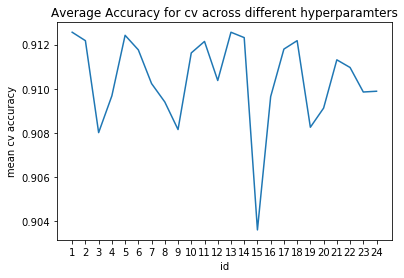

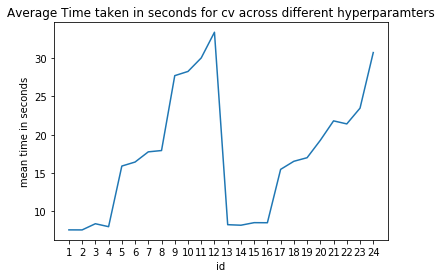


id: 1 | hyperparamter: {'batch_size': 32, 'epochs': 10, 'first_hidden_units': 30, 'hidden_activation_fun': 'relu', 'optimizer': 'adam', 'output_activation_func': 'sigmoid', 'second_hidden_units': 15}
id: 2 | hyperparamter: {'batch_size': 32, 'epochs': 10, 'first_hidden_units': 30, 'hidden_activation_fun': 'relu', 'optimizer': 'rmsprop', 'output_activation_func': 'sigmoid', 'second_hidden_units': 15}
id: 3 | hyperparamter: {'batch_size': 32, 'epochs': 10, 'first_hidden_units': 30, 'hidden_activation_fun': 'sigmoid', 'optimizer': 'adam', 'output_activation_func': 'sigmoid', 'second_hidden_units': 15}
id: 4 | hyperparamter: {'batch_size': 32, 'epochs': 10, 'first_hidden_units': 30, 'hidden_activation_fun': 'sigmoid', 'optimizer': 'rmsprop', 'output_activation_func': 'sigmoid', 'second_hidden_units': 15}
id: 5 | hyperparamter: {'batch_size': 32, 'epochs': 20, 'first_hidden_units': 30, 'hidden_activation_fun': 'relu', 'optimizer': 'adam', 'output_activation_func': 'sigmoid', 'second_hidden

Train accuracy score of best model: 0.9202
Test accuracy score of best model: 0.9182



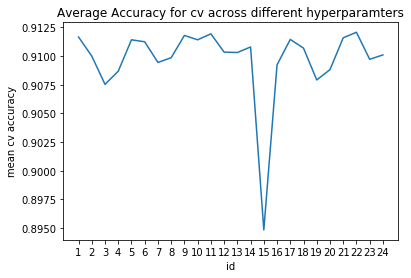

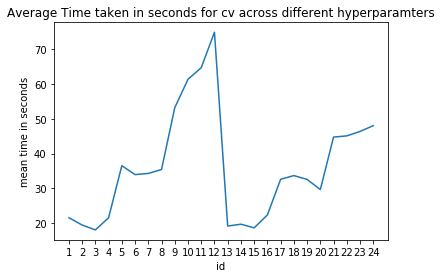


id: 1 | hyperparamter: {'batch_size': 32, 'epochs': 10, 'first_hidden_units': 20, 'hidden_activation_fun': 'relu', 'optimizer': 'adam', 'output_activation_func': 'sigmoid', 'second_hidden_units': 10}
id: 2 | hyperparamter: {'batch_size': 32, 'epochs': 10, 'first_hidden_units': 20, 'hidden_activation_fun': 'relu', 'optimizer': 'rmsprop', 'output_activation_func': 'sigmoid', 'second_hidden_units': 10}
id: 3 | hyperparamter: {'batch_size': 32, 'epochs': 10, 'first_hidden_units': 20, 'hidden_activation_fun': 'sigmoid', 'optimizer': 'adam', 'output_activation_func': 'sigmoid', 'second_hidden_units': 10}
id: 4 | hyperparamter: {'batch_size': 32, 'epochs': 10, 'first_hidden_units': 20, 'hidden_activation_fun': 'sigmoid', 'optimizer': 'rmsprop', 'output_activation_func': 'sigmoid', 'second_hidden_units': 10}
id: 5 | hyperparamter: {'batch_size': 32, 'epochs': 20, 'first_hidden_units': 20, 'hidden_activation_fun': 'relu', 'optimizer': 'adam', 'output_activation_func': 'sigmoid', 'second_hidden

Train accuracy score of best model: 0.9166
Test accuracy score of best model: 0.9158



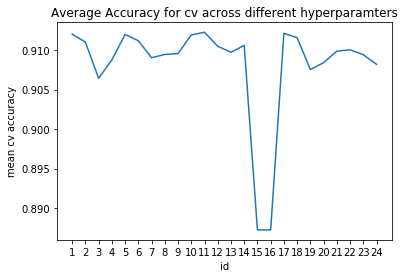

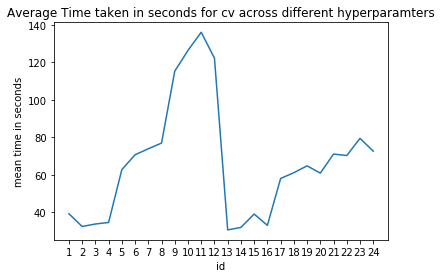


id: 1 | hyperparamter: {'batch_size': 32, 'epochs': 10, 'first_hidden_units': 30, 'hidden_activation_fun': 'relu', 'optimizer': 'adam', 'output_activation_func': 'sigmoid', 'second_hidden_units': 15, 'third_hidden_units': 8}
id: 2 | hyperparamter: {'batch_size': 32, 'epochs': 10, 'first_hidden_units': 30, 'hidden_activation_fun': 'relu', 'optimizer': 'rmsprop', 'output_activation_func': 'sigmoid', 'second_hidden_units': 15, 'third_hidden_units': 8}
id: 3 | hyperparamter: {'batch_size': 32, 'epochs': 10, 'first_hidden_units': 30, 'hidden_activation_fun': 'sigmoid', 'optimizer': 'adam', 'output_activation_func': 'sigmoid', 'second_hidden_units': 15, 'third_hidden_units': 8}
id: 4 | hyperparamter: {'batch_size': 32, 'epochs': 10, 'first_hidden_units': 30, 'hidden_activation_fun': 'sigmoid', 'optimizer': 'rmsprop', 'output_activation_func': 'sigmoid', 'second_hidden_units': 15, 'third_hidden_units': 8}
id: 5 | hyperparamter: {'batch_size': 32, 'epochs': 20, 'first_hidden_units': 30, 'hidd

Train accuracy score of best model: 0.9218
Test accuracy score of best model: 0.9159



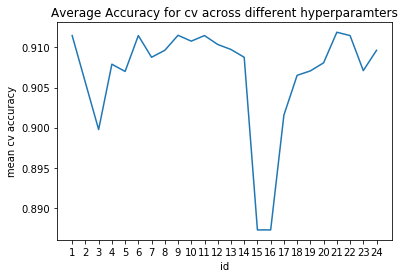

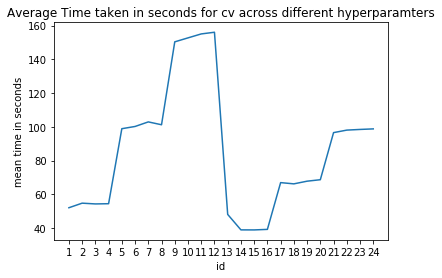


id: 1 | hyperparamter: {'batch_size': 32, 'epochs': 10, 'first_hidden_units': 20, 'hidden_activation_fun': 'relu', 'optimizer': 'adam', 'output_activation_func': 'sigmoid', 'second_hidden_units': 10, 'third_hidden_units': 5}
id: 2 | hyperparamter: {'batch_size': 32, 'epochs': 10, 'first_hidden_units': 20, 'hidden_activation_fun': 'relu', 'optimizer': 'rmsprop', 'output_activation_func': 'sigmoid', 'second_hidden_units': 10, 'third_hidden_units': 5}
id: 3 | hyperparamter: {'batch_size': 32, 'epochs': 10, 'first_hidden_units': 20, 'hidden_activation_fun': 'sigmoid', 'optimizer': 'adam', 'output_activation_func': 'sigmoid', 'second_hidden_units': 10, 'third_hidden_units': 5}
id: 4 | hyperparamter: {'batch_size': 32, 'epochs': 10, 'first_hidden_units': 20, 'hidden_activation_fun': 'sigmoid', 'optimizer': 'rmsprop', 'output_activation_func': 'sigmoid', 'second_hidden_units': 10, 'third_hidden_units': 5}
id: 5 | hyperparamter: {'batch_size': 32, 'epochs': 20, 'first_hidden_units': 20, 'hidd

In [14]:
#Results summary
print("Small network and large hidden units, cv results for first data set")
nn_result(small_network_large_hidden_2, X_train_2,Y_train_2,X_test_2,Y_test_2)

print("small network and small hidden units, cv results for first data set")
nn_result(small_network_small_hidden_2, X_train_2,Y_train_2,X_test_2,Y_test_2)

print("Large network and large hidden units, cv results for first data set")
nn_result(large_network_large_hidden_2, X_train_2,Y_train_2,X_test_2,Y_test_2)

print("Large network and small hidden units, cv results for first data set")
nn_result(large_network_small_hidden_2, X_train_2,Y_train_2,X_test_2,Y_test_2)


# NN varying size

In [8]:
def vary_func1_helper(X_train,Y_train,input_dims,output_dims,parameters,cv):
    def build_classifier(optimizer,first_hidden_units,second_hidden_units,hidden_activation_fun,output_activation_func):
        classifier = Sequential()
        classifier.add(Dense(output_dim = first_hidden_units, init = 'uniform', activation = hidden_activation_fun, input_dim = input_dims))
        # Adding the second hidden layer
        classifier.add(Dense(output_dim = second_hidden_units, init = 'uniform', activation = hidden_activation_fun))
        # Adding the output layer
        classifier.add(Dense(output_dim = output_dims, init = 'uniform', activation = output_activation_func))
        classifier.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
        return classifier

    classifier = KerasClassifier(build_fn = build_classifier)

    grid_search = GridSearchCV(estimator = classifier,
                       param_grid = parameters,
                       scoring = 'accuracy',
                       cv = cv)
    #grid_search = grid_search.fit(X_train, Y_train)
    
    return grid_search

In [9]:
def vary_func1(X_train,Y_train,X_test,Y_test,input_dims,output_dims,parameters,cv,trainsize):
    times=[]
    cv_acc=[]
    train_acc=[]
    test_acc=[]
    for i in trainsize:
        start_time_iter = time.time()
        data_size=int(i*X_train.shape[0])
        X_train_temp=X_train.head(data_size)
        Y_train_temp=Y_train[0:data_size]
        grid_search=vary_func1_helper(X_train_temp,Y_train_temp,X_train_temp.shape[1],output_dims,parameters,cv)
        grid_search = grid_search.fit(X_train_temp, Y_train_temp)
        cv_acc.append(np.round(grid_search.cv_results_['mean_test_score'],4)*100)
        train_acc.append(np.round(accuracy_score(grid_search.predict(X_train_temp),Y_train_temp),4)*100)
        test_acc.append(np.round(accuracy_score(grid_search.predict(X_test),Y_test),4)*100)
        times.append(time.time()-start_time_iter) 
    return grid_search,times,cv_acc,train_acc,test_acc

In [22]:
def svm_size_vary_plot(size,train_acc,cv_acc,times,title):
    print()
    print("kernel:",title)
    print()
    print("% of the training data:",size)
    print("training data accuracy:",train_acc)
    print("cross validaiton accuracy:",cv_acc)
    print("time taken:",times)
    print()
    p1=pl.plot(size,train_acc,c="red")
    p2=pl.plot(size,cv_acc,c="green")
    p1+p2
    pl.xlabel('size')
    pl.ylabel('accuracy')
    pl.title('Train and CV accuracy across % of training used')
    pointtypes = np.array(['training accuracy', 'cross validation accuracy'])
    pl.legend(pointtypes)
    pl.show()
    pl.plot(size,times)
    pl.xlabel('size')
    pl.ylabel('Mean cv time taken (sec)')
    pl.title('Mean Time taken across % training data used')
    pl.show()
    return(None)

First dataset

In [10]:
vary_1_param_1 = {'batch_size': [64],'epochs': [10],'optimizer': ['rmsprop'],'first_hidden_units':[20],'second_hidden_units':[10],'hidden_activation_fun':['relu'],'output_activation_func':['sigmoid']}
    
trainsize=[0.2,0.4,0.6,0.8,1.0]

vary_grid_1_1,times_1_1,cv_acc_1_1,train_acc_1_1,test_acc_1_1=vary_func1(X_train_1,Y_train_1,X_test_1,Y_test_1,X_train_1.shape[1],1,vary_1_param_1,5,trainsize)


C:\Users\saivi\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=58, units=20, kernel_initializer="uniform")`
  after removing the cwd from sys.path.
C:\Users\saivi\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=10, kernel_initializer="uniform")`
  
C:\Users\saivi\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", units=1, kernel_initializer="uniform")`
  


Epoch 1/10
4440/4440 [==============================] - 0s 65us/step - loss: 0.6889 - acc: 0.5770
Epoch 2/10
4440/4440 [==============================] - 0s 30us/step - loss: 0.6601 - acc: 0.6394
Epoch 3/10
4440/4440 [==============================] - 0s 27us/step - loss: 0.6345 - acc: 0.6498
Epoch 4/10
4440/4440 [==============================] - 0s 26us/step - loss: 0.6247 - acc: 0.6577
Epoch 5/10
4440/4440 [==============================] - 0s 29us/step - loss: 0.6188 - acc: 0.6592
Epoch 6/10
4440/4440 [==============================] - 0s 25us/step - loss: 0.6140 - acc: 0.6664
Epoch 7/10
4440/4440 [==============================] - 0s 44us/step - loss: 0.6111 - acc: 0.6669
Epoch 8/10
4440/4440 [==============================] - 0s 39us/step - loss: 0.6083 - acc: 0.6680
Epoch 9/10
4440/4440 [==============================] - 0s 31us/step - loss: 0.6057 - acc: 0.6707
Epoch 10/10
4440/4440 [==============================] - 0s 27us/step - loss: 0.6038 - acc: 0.6752
Epoch 1/10
4440/444

13320/13320 [==============================] - 0s 31us/step - loss: 0.6136 - acc: 0.6637
Epoch 7/10
13320/13320 [==============================] - 0s 30us/step - loss: 0.6119 - acc: 0.6654
Epoch 8/10
13320/13320 [==============================] - 0s 30us/step - loss: 0.6099 - acc: 0.6648
Epoch 9/10
13320/13320 [==============================] - 0s 30us/step - loss: 0.6084 - acc: 0.6697
Epoch 10/10
13320/13320 [==============================] - 0s 30us/step - loss: 0.6068 - acc: 0.6692
Epoch 1/10
16650/16650 [==============================] - 1s 63us/step - loss: 0.6627 - acc: 0.6103
Epoch 2/10
16650/16650 [==============================] - 1s 35us/step - loss: 0.6288 - acc: 0.6514
Epoch 3/10
16650/16650 [==============================] - 1s 34us/step - loss: 0.6206 - acc: 0.6581
Epoch 4/10
16650/16650 [==============================] - 1s 36us/step - loss: 0.6169 - acc: 0.6622
Epoch 5/10
16650/16650 [==============================] - 1s 36us/step - loss: 0.6140 - acc: 0.6639
Epoch 6/10

Epoch 8/10
22200/22200 [==============================] - 1s 40us/step - loss: 0.6133 - acc: 0.6642
Epoch 9/10
22200/22200 [==============================] - 1s 41us/step - loss: 0.6119 - acc: 0.6653
Epoch 10/10
22200/22200 [==============================] - 1s 39us/step - loss: 0.6099 - acc: 0.6691
Epoch 1/10
22200/22200 [==============================] - 1s 64us/step - loss: 0.6577 - acc: 0.6206
Epoch 2/10
22200/22200 [==============================] - 1s 36us/step - loss: 0.6297 - acc: 0.6495
Epoch 3/10
22200/22200 [==============================] - 1s 35us/step - loss: 0.6240 - acc: 0.6535
Epoch 4/10
22200/22200 [==============================] - 1s 34us/step - loss: 0.6204 - acc: 0.6564
Epoch 5/10
22200/22200 [==============================] - 1s 34us/step - loss: 0.6185 - acc: 0.6600
Epoch 6/10
22200/22200 [==============================] - 1s 34us/step - loss: 0.6162 - acc: 0.6618
Epoch 7/10
22200/22200 [==============================] - 1s 35us/step - loss: 0.6145 - acc: 0.6614


kernel: {'batch_size': [64], 'epochs': [10], 'optimizer': ['rmsprop'], 'first_hidden_units': [20], 'second_hidden_units': [10], 'hidden_activation_fun': ['relu'], 'output_activation_func': ['sigmoid']}

% of the training data: [0.2, 0.4, 0.6, 0.8, 1.0]
training data accuracy: [67.53, 67.89, 67.62, 67.23, 67.25]
cross validaiton accuracy: [array([65.03]), array([65.74]), array([65.97]), array([65.51]), array([65.61])]
time taken: [10.817066669464111, 21.175363540649414, 35.69933557510376, 46.87907385826111, 61.59541463851929]



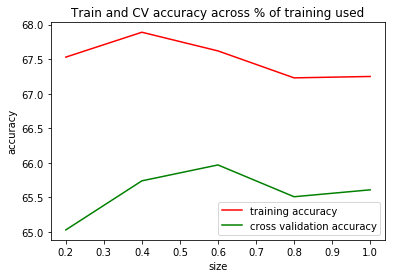

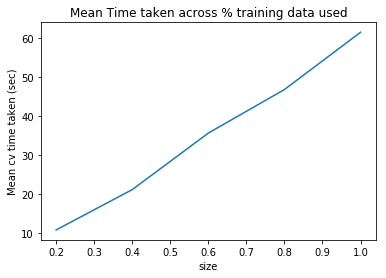

In [23]:
svm_size_vary_plot(trainsize,train_acc_1_1,cv_acc_1_1,times_1_1,str(vary_1_param_1))

In [26]:
confusion_matrix(vary_grid_1_1.predict(X_test_1),Y_test_1)

array([[4115, 2168],
       [1953, 3658]])

second dataset

In [12]:
vary_1_param = {'batch_size': [32],'epochs': [10],'optimizer': ['adam'],'first_hidden_units':[30],'second_hidden_units':[15],'hidden_activation_fun':['relu'],'output_activation_func':['sigmoid']}
vary_2_param = {'batch_size': [32],'epochs': [5],'optimizer': ['adam'],'first_hidden_units':[30],'second_hidden_units':[15],'hidden_activation_fun':['relu'],'output_activation_func':['sigmoid']}
vary_3_param = {'batch_size': [64],'epochs': [10],'optimizer': ['adam'],'first_hidden_units':[30],'second_hidden_units':[15],'hidden_activation_fun':['relu'],'output_activation_func':['sigmoid']}

trainsize=[0.2,0.4,0.6,0.8,1.0]

vary_grid_1,times_1,cv_acc_1,train_acc_1,test_acc_1=vary_func1(X_train_2,Y_train_2,X_test_2,Y_test_2,X_train_2.shape[1],1,vary_1_param,5,trainsize)


C:\Users\saivi\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=63, units=30, kernel_initializer="uniform")`
  after removing the cwd from sys.path.
C:\Users\saivi\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=15, kernel_initializer="uniform")`
  
C:\Users\saivi\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", units=1, kernel_initializer="uniform")`
  


Epoch 1/10
4612/4612 [==============================] - 0s 72us/step - loss: 0.4030 - acc: 0.8914
Epoch 2/10
4612/4612 [==============================] - 0s 33us/step - loss: 0.2144 - acc: 0.9081
Epoch 3/10
4612/4612 [==============================] - 0s 32us/step - loss: 0.1940 - acc: 0.9098
Epoch 4/10
4612/4612 [==============================] - 0s 34us/step - loss: 0.1908 - acc: 0.9109
Epoch 5/10
4612/4612 [==============================] - 0s 33us/step - loss: 0.1878 - acc: 0.9141
Epoch 6/10
4612/4612 [==============================] - 0s 32us/step - loss: 0.1863 - acc: 0.9100
Epoch 7/10
4612/4612 [==============================] - 0s 33us/step - loss: 0.1847 - acc: 0.9135
Epoch 8/10
4612/4612 [==============================] - 0s 35us/step - loss: 0.1842 - acc: 0.9161
Epoch 9/10
4612/4612 [==============================] - 0s 35us/step - loss: 0.1830 - acc: 0.9146
Epoch 10/10
4612/4612 [==============================] - 0s 30us/step - loss: 0.1821 - acc: 0.9159
Epoch 1/10
4613/461

13839/13839 [==============================] - 1s 36us/step - loss: 0.1915 - acc: 0.9092
Epoch 7/10
13839/13839 [==============================] - 0s 35us/step - loss: 0.1903 - acc: 0.9102
Epoch 8/10
13839/13839 [==============================] - 1s 40us/step - loss: 0.1890 - acc: 0.9100
Epoch 9/10
13839/13839 [==============================] - 0s 36us/step - loss: 0.1876 - acc: 0.9099
Epoch 10/10
13839/13839 [==============================] - 0s 36us/step - loss: 0.1866 - acc: 0.9126
Epoch 1/10
17298/17298 [==============================] - 1s 70us/step - loss: 0.2611 - acc: 0.8992
Epoch 2/10
17298/17298 [==============================] - 1s 46us/step - loss: 0.1946 - acc: 0.9079
Epoch 3/10
17298/17298 [==============================] - 1s 44us/step - loss: 0.1912 - acc: 0.9106
Epoch 4/10
17298/17298 [==============================] - 1s 45us/step - loss: 0.1886 - acc: 0.9089
Epoch 5/10
17298/17298 [==============================] - 1s 46us/step - loss: 0.1864 - acc: 0.9109
Epoch 6/10

Epoch 8/10
23064/23064 [==============================] - 1s 35us/step - loss: 0.1791 - acc: 0.9154
Epoch 9/10
23064/23064 [==============================] - 1s 34us/step - loss: 0.1774 - acc: 0.9156
Epoch 10/10
23064/23064 [==============================] - 1s 36us/step - loss: 0.1761 - acc: 0.9159
Epoch 1/10
23065/23065 [==============================] - 2s 69us/step - loss: 0.2483 - acc: 0.9030
Epoch 2/10
23065/23065 [==============================] - 1s 35us/step - loss: 0.1921 - acc: 0.9090
Epoch 3/10
23065/23065 [==============================] - 1s 44us/step - loss: 0.1888 - acc: 0.9113
Epoch 4/10
23065/23065 [==============================] - 1s 54us/step - loss: 0.1866 - acc: 0.9116
Epoch 5/10
23065/23065 [==============================] - 1s 43us/step - loss: 0.1848 - acc: 0.9119
Epoch 6/10
23065/23065 [==============================] - 1s 41us/step - loss: 0.1831 - acc: 0.9131
Epoch 7/10
23065/23065 [==============================] - 1s 41us/step - loss: 0.1809 - acc: 0.9127


kernel: {'batch_size': [32], 'epochs': [10], 'optimizer': ['adam'], 'first_hidden_units': [30], 'second_hidden_units': [15], 'hidden_activation_fun': ['relu'], 'output_activation_func': ['sigmoid']}

% of the training data: [0.2, 0.4, 0.6, 0.8, 1.0]
training data accuracy: [91.64, 91.2, 91.71000000000001, 91.8, 91.96]
cross validaiton accuracy: [array([90.65]), array([90.7]), array([90.92]), array([91.1]), array([91.19])]
time taken: [14.171516180038452, 27.1649329662323, 41.50851035118103, 56.362757444381714, 79.09746289253235]



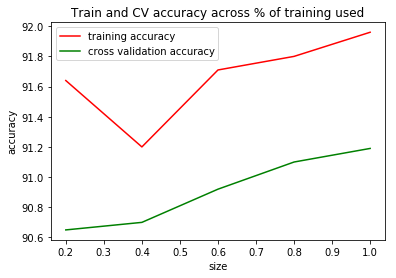

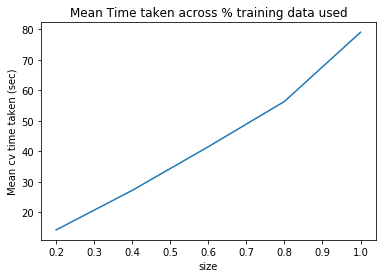

In [22]:
svm_size_vary_plot(trainsize,train_acc_1,cv_acc_1,times_1,str(vary_1_param))

In [24]:
confusion_matrix(vary_grid_1.predict(X_test_2),Y_test_2)

array([[10571,   617],
       [  397,   772]])

NN epochs 

In [18]:
classifier = Sequential()
classifier.add(Dense(output_dim = 20, init = 'uniform', activation = 'relu', input_dim = X_train_1.shape[1]))
classifier.add(Dense(output_dim = 10, init = 'uniform', activation = 'relu'))
classifier.add(Dense(output_dim = 1, init = 'uniform', activation = 'sigmoid'))
classifier.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])
history = classifier.fit(X_train_1, Y_train_1, validation_split=0.33, epochs=100, batch_size=64, verbose=0)


C:\Users\saivi\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=58, units=20, kernel_initializer="uniform")`
  
C:\Users\saivi\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=10, kernel_initializer="uniform")`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\saivi\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="sigmoid", units=1, kernel_initializer="uniform")`
  after removing the cwd from sys.path.


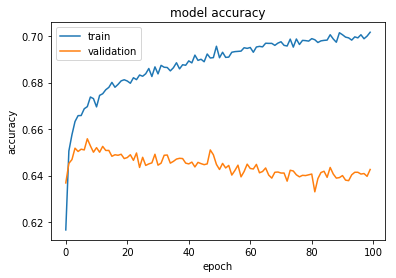

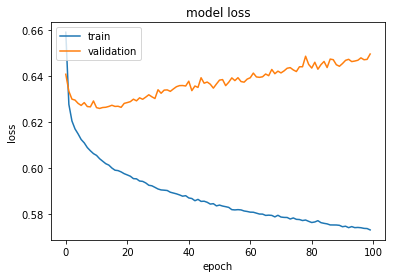

In [22]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# KNN

first dataset


CV results:
{'algorithm': 'ball_tree', 'n_neighbors': 1, 'p': 1, 'weights': 'uniform'} | acv acc: 0.577 | time in seconds: 0.23
{'algorithm': 'ball_tree', 'n_neighbors': 1, 'p': 1, 'weights': 'distance'} | acv acc: 0.577 | time in seconds: 0.23
{'algorithm': 'ball_tree', 'n_neighbors': 1, 'p': 2, 'weights': 'uniform'} | acv acc: 0.5686 | time in seconds: 0.19
{'algorithm': 'ball_tree', 'n_neighbors': 1, 'p': 2, 'weights': 'distance'} | acv acc: 0.5686 | time in seconds: 0.23
{'algorithm': 'ball_tree', 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'} | acv acc: 0.6039 | time in seconds: 0.21
{'algorithm': 'ball_tree', 'n_neighbors': 5, 'p': 1, 'weights': 'distance'} | acv acc: 0.6039 | time in seconds: 0.22
{'algorithm': 'ball_tree', 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'} | acv acc: 0.5958 | time in seconds: 0.21
{'algorithm': 'ball_tree', 'n_neighbors': 5, 'p': 2, 'weights': 'distance'} | acv acc: 0.5956 | time in seconds: 0.2
{'algorithm': 'ball_tree', 'n_neighbors': 15, 'p':

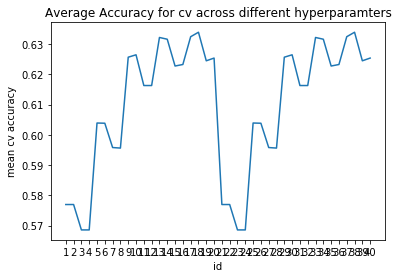

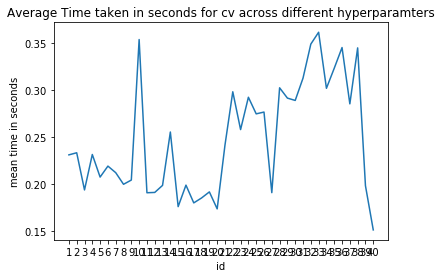


id: 1 | hyperparamter: {'algorithm': 'ball_tree', 'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}
id: 2 | hyperparamter: {'algorithm': 'ball_tree', 'n_neighbors': 1, 'p': 1, 'weights': 'distance'}
id: 3 | hyperparamter: {'algorithm': 'ball_tree', 'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}
id: 4 | hyperparamter: {'algorithm': 'ball_tree', 'n_neighbors': 1, 'p': 2, 'weights': 'distance'}
id: 5 | hyperparamter: {'algorithm': 'ball_tree', 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
id: 6 | hyperparamter: {'algorithm': 'ball_tree', 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
id: 7 | hyperparamter: {'algorithm': 'ball_tree', 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
id: 8 | hyperparamter: {'algorithm': 'ball_tree', 'n_neighbors': 5, 'p': 2, 'weights': 'distance'}
id: 9 | hyperparamter: {'algorithm': 'ball_tree', 'n_neighbors': 15, 'p': 1, 'weights': 'uniform'}
id: 10 | hyperparamter: {'algorithm': 'ball_tree', 'n_neighbors': 15, 'p': 1, 'weights': 'distance'}
id: 11 | hy

In [17]:
#first dataset
n_neighbors = [1,5,15,25,49]
weights = ['uniform','distance']
algorithm = ['ball_tree','brute']
p = [1,2]
cv=3
parameters = [{'n_neighbors': n_neighbors, 'weights':weights, 'algorithm':algorithm, 'p':p}]

clf_1 = neighbors.KNeighborsClassifier()
clf_1 = GridSearchCV(clf_1, parameters, refit=True,cv=cv,scoring='accuracy')
clf_1.fit(X_train_1, Y_train_1)
nn_result(clf_1, X_train_1,Y_train_1,X_test_1,Y_test_1)

second dataset


CV results:
{'algorithm': 'ball_tree', 'n_neighbors': 1, 'p': 1, 'weights': 'uniform'} | acv acc: 0.8803 | time in seconds: 0.18
{'algorithm': 'ball_tree', 'n_neighbors': 1, 'p': 1, 'weights': 'distance'} | acv acc: 0.8803 | time in seconds: 0.17
{'algorithm': 'ball_tree', 'n_neighbors': 1, 'p': 2, 'weights': 'uniform'} | acv acc: 0.882 | time in seconds: 0.16
{'algorithm': 'ball_tree', 'n_neighbors': 1, 'p': 2, 'weights': 'distance'} | acv acc: 0.882 | time in seconds: 0.18
{'algorithm': 'ball_tree', 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'} | acv acc: 0.8979 | time in seconds: 0.16
{'algorithm': 'ball_tree', 'n_neighbors': 5, 'p': 1, 'weights': 'distance'} | acv acc: 0.8971 | time in seconds: 0.16
{'algorithm': 'ball_tree', 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'} | acv acc: 0.8991 | time in seconds: 0.15
{'algorithm': 'ball_tree', 'n_neighbors': 5, 'p': 2, 'weights': 'distance'} | acv acc: 0.8985 | time in seconds: 0.15
{'algorithm': 'ball_tree', 'n_neighbors': 15, 'p'

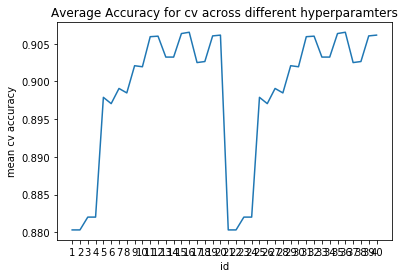

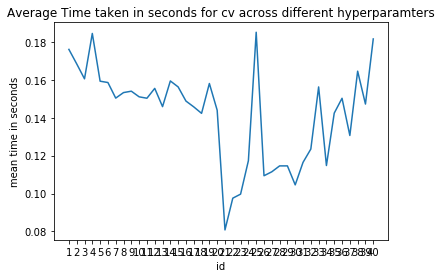


id: 1 | hyperparamter: {'algorithm': 'ball_tree', 'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}
id: 2 | hyperparamter: {'algorithm': 'ball_tree', 'n_neighbors': 1, 'p': 1, 'weights': 'distance'}
id: 3 | hyperparamter: {'algorithm': 'ball_tree', 'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}
id: 4 | hyperparamter: {'algorithm': 'ball_tree', 'n_neighbors': 1, 'p': 2, 'weights': 'distance'}
id: 5 | hyperparamter: {'algorithm': 'ball_tree', 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
id: 6 | hyperparamter: {'algorithm': 'ball_tree', 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
id: 7 | hyperparamter: {'algorithm': 'ball_tree', 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
id: 8 | hyperparamter: {'algorithm': 'ball_tree', 'n_neighbors': 5, 'p': 2, 'weights': 'distance'}
id: 9 | hyperparamter: {'algorithm': 'ball_tree', 'n_neighbors': 15, 'p': 1, 'weights': 'uniform'}
id: 10 | hyperparamter: {'algorithm': 'ball_tree', 'n_neighbors': 15, 'p': 1, 'weights': 'distance'}
id: 11 | hy

In [18]:
#second dataset
n_neighbors = [1,5,15,25,49]
weights = ['uniform','distance']
algorithm = ['ball_tree','brute']
p = [1,2]
cv=3
parameters = [{'n_neighbors': n_neighbors, 'weights':weights, 'algorithm':algorithm, 'p':p}]

clf_2 = neighbors.KNeighborsClassifier()
clf_2 = GridSearchCV(clf_2, parameters, refit=True,cv=cv,scoring='accuracy')
clf_2.fit(X_train_2, Y_train_2)
nn_result(clf_2, X_train_2,Y_train_2,X_test_2,Y_test_2)

# KNN vary size

first datset

In [ ]:
cv=3
vary_2_param_d1 = [{'n_neighbors': [49], 'weights':['distance'], 'algorithm':['ball_tree'], 'p':[1]}]
    
trainsize=[0.2,0.4,0.6,0.8,1.0]

vary_grid_2_d1,times_2_d1,cv_acc_2_d1,train_acc_2_d1,test_acc_2_d1=vary_func1(X_train_1,Y_train_1,X_test_1,Y_test_1,vary_2_param_d1,3,trainsize)


kernel: [{'n_neighbors': [49], 'weights': ['distance'], 'algorithm': ['ball_tree'], 'p': [1]}]

% of the training data: [0.2, 0.4, 0.6, 0.8, 1.0]
training data accuracy: [100.0, 100.0, 100.0, 100.0, 100.0]
cross validaiton accuracy: [array([62.32]), array([62.8]), array([63.77]), array([63.62]), array([63.39])]
time taken: [11.575813293457031, 39.65642762184143, 119.39572358131409, 254.27152848243713, 382.68295335769653]



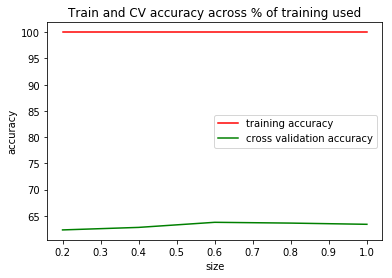

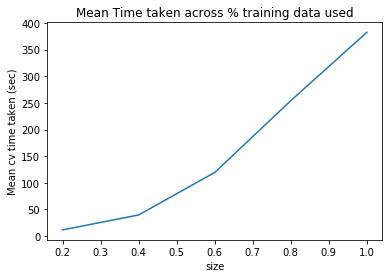

In [44]:
svm_size_vary_plot(trainsize,train_acc_2_d1,cv_acc_2_d1,times_2_d1,str(vary_2_param_d1))

In [43]:
confusion_matrix(vary_grid_2_d1.predict(X_test_1),Y_test_1)

array([[4389, 2682],
       [1679, 3144]])

second dataset

In [ ]:
cv=3
vary_2_param_d2 = [{'n_neighbors': [25], 'weights':['distance'], 'algorithm':['ball_tree'], 'p':[2]}]

trainsize=[0.2,0.4,0.6,0.8,1.0]

vary_grid_2_d2,times_2_d2,cv_acc_2_d2,train_acc_2_d2,test_acc_2_d2=vary_func1(X_train_2,Y_train_2,X_test_2,Y_test_2,vary_2_param_d2,3,trainsize)


kernel: [{'n_neighbors': [25], 'weights': ['distance'], 'algorithm': ['ball_tree'], 'p': [2]}]

% of the training data: [0.2, 0.4, 0.6, 0.8, 1.0]
training data accuracy: [100.0, 100.0, 100.0, 100.0, 100.0]
cross validaiton accuracy: [array([90.06]), array([89.98]), array([90.27]), array([90.62]), array([90.65])]
time taken: [16.04752802848816, 61.41998100280762, 151.2269411087036, 284.1510992050171, 343.7237021923065]



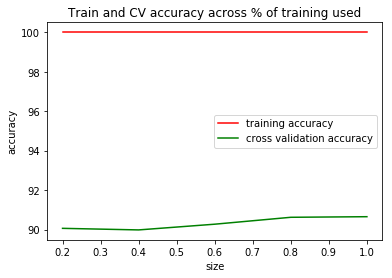

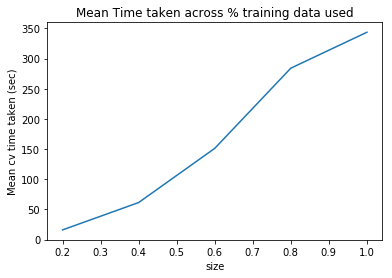

In [45]:
svm_size_vary_plot(trainsize,train_acc_2_d2,cv_acc_2_d2,times_2_d2,str(vary_2_param_d2))

In [46]:
confusion_matrix(vary_grid_2_d2.predict(X_test_2),Y_test_2)

array([[10697,   857],
       [  271,   532]])